Reproducing the pre-processing of EEG data for ML models with reproduction of earlier work in ming.

# Prepare EEG data for training of machine-learning models

In this notebook, the preprocessing for machine learning purposes is done. Also, some exploration and visualization is done to better understand the data at hand.

+ Import data.
+ Apply filters (bandpass).
+ Detect potential bad channels and replace them by interpolation.
+ Detect potential bad epochs and remove them.
+ Select features

## Import packages & links

In [1]:
# Import packages
import os
import sys

sys.path.insert(0, os.path.dirname(os.getcwd()))

import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mne

sns.set_theme(style="whitegrid")
%matplotlib inline
# %matplotlib qt

In [2]:
import fnmatch
import warnings
import re
warnings.filterwarnings('ignore')

import helper_functions

In [3]:
from config_for_repro_prepro  import PATH_RAW_DATA, PATH_METADATA, PATH_DATA_PROCESSED_ML

In [4]:
# add overwrite step 
PATH_RAW_DATA= 'C:/Projects/EEG_explorer/Data'

## Search all *.cnt files and get paths, code, and age group

In [5]:


# dir_names = {5: '5mnd mmn',
#              11: '11mnd mmn',
#              17: '17mnd mmn',
#              23: '23mnd mmn',
#              29: '29mnd mmn',
#              35: '35mnd mmn',
#              41: '41mnd mmn',
#              47: '47mnd mmn'}

# dir_names = {11: '11mnd mmn',
#              17: '17mnd mmn',
#              23: '23mnd mmn',
#              29: '29mnd mmn',
#              35: '35mnd mmn',
#              41: '41mnd mmn',
#              47: '47mnd mmn',
# }
    
# df_list = []

# for age_group, directory in dir_names.items(): # Go into every age group folder        
#     dir_path = os.path.join('C:/Projects/EEG_explorer/Data', directory)
#     file_names = os.listdir(dir_path)
#     cnt_paths = [os.path.join(dir_path, file_name) for file_name in fnmatch.filter(file_names, "*.cnt")]
#     cnt_files = [x.split('/')[-1][:-4] for x in cnt_paths]
#     codes = [int(re.search(r'\d+', x).group()) for x in cnt_files]
#     df = pd.DataFrame(list(zip(codes, cnt_paths, cnt_files)), columns =['code', 'cnt_path','cnt_file']) 
    
#     df['age_group'] = age_group
#     df_list.append(df)

# cnt_files = pd.concat(df_list)

In [6]:
dir_names = {11: '11mnd mmn',
             17: '17mnd mmn',
             23: '23mnd mmn',
             29: '29mnd mmn',
             35: '35mnd mmn',
             41: '41mnd mmn',
             47: '47mnd mmn'}
    
df_list = []

for age_group, directory in dir_names.items(): # Go into every age group folder        
    dir_path = os.path.join('C:/Projects/EEG_explorer/Data', directory)
    file_names = os.listdir(dir_path)
    
    cnt_paths = [os.path.join(dir_path, file_name) for file_name in fnmatch.filter(file_names, "*.cnt")]
    # list comprehension - creates a list of all cnt file names with thisdirectory
    cnt_files = [os.path.basename(x)[:-4] for x in cnt_paths]
    # list comprehension
    codes = [int(re.search(r'\d+', x).group()) for x in cnt_files]
    # takes number out of string (\d+ takes out digits)
    df = pd.DataFrame(list(zip(codes, cnt_paths, cnt_files)), columns=['code', 'cnt_path','cnt_file']) 
    
    df['age_group'] = age_group
    df_list.append(df)

cnt_files = pd.concat(df_list)

In [7]:
cnt_files.head()

code                                           cnt_path  \
0     1  C:/Projects/EEG_explorer/Data\11mnd mmn\001_11...   
1     3  C:/Projects/EEG_explorer/Data\11mnd mmn\003_11...   
2     4  C:/Projects/EEG_explorer/Data\11mnd mmn\004_11...   
3     5  C:/Projects/EEG_explorer/Data\11mnd mmn\005_11...   
4     7  C:/Projects/EEG_explorer/Data\11mnd mmn\007_11...   

                                           cnt_file  age_group  
0     001_11_jc_mmn36_wk_mmn25_wk_mmn47_wk_mmn58_wk         11  
1  003_11_jc_mmn36_slp_mmn25_wk_mmn47_slp_mmn58_slp         11  
2                                     004_11_mc_mmn         11  
3                                    005_11_jc_mmn2         11  
4                              007_11_jc_mmn2_36_wk         11

## Search for all age files and create DataFrame containing all ages per subject code

In [8]:
# age_files = {5: 'ages_5mnths.txt',
#              11: 'ages_11mnths.txt',
#              17: 'ages_17mnths.txt',
#              23: 'ages_23mnths.txt',
#              29: 'ages_29mnths.txt',
#              35: 'ages_35mnths.txt',
#              41: 'ages_41mnths.txt',
#              47: 'ages_47mnths.txt'}

age_files = {11: 'ages_11mnths.txt',
             17: 'ages_17mnths.txt',
             23: 'ages_23mnths.txt',
             29: 'ages_29mnths.txt',
             35: 'ages_35mnths.txt',
             41: 'ages_41mnths.txt',
             47: 'ages_47mnths.txt'}

df_list = []

for age_group, age_file in age_files.items():
    df = pd.read_csv(os.path.join(PATH_METADATA, 'ages', age_file), sep="\t")
    df['age_group'] = age_group
    df_list.append(df)

age_df = pd.concat(df_list)

In [9]:
age_df

code  age_days  age_months  age_years  age_group
0      1       329   10.966667   0.913889         11
1      3       336   11.200000   0.933333         11
2      5       329   10.966667   0.913889         11
3      6       319   10.633333   0.886111         11
4      7       329   10.966667   0.913889         11
..   ...       ...         ...        ...        ...
74   731      1409   46.966667   3.913889         47
75   732      1412   47.066667   3.922222         47
76   733      1404   46.800000   3.900000         47
77   734      1405   46.833333   3.902778         47
78   735      1398   46.600000   3.883333         47

[1717 rows x 5 columns]

### Merge the .cnt files with the age information we have on the subjects

In [10]:
#merged_df = pd.merge(age_df, cnt_files, how='left', on=['age_group','code'])

In [11]:
merged_df = pd.merge(cnt_files, age_df, how='left', on=['age_group', 'code'])

In [12]:
merged_df.head()

code                                           cnt_path  \
0     1  C:/Projects/EEG_explorer/Data\11mnd mmn\001_11...   
1     3  C:/Projects/EEG_explorer/Data\11mnd mmn\003_11...   
2     4  C:/Projects/EEG_explorer/Data\11mnd mmn\004_11...   
3     5  C:/Projects/EEG_explorer/Data\11mnd mmn\005_11...   
4     7  C:/Projects/EEG_explorer/Data\11mnd mmn\007_11...   

                                           cnt_file  age_group  age_days  \
0     001_11_jc_mmn36_wk_mmn25_wk_mmn47_wk_mmn58_wk         11     329.0   
1  003_11_jc_mmn36_slp_mmn25_wk_mmn47_slp_mmn58_slp         11     336.0   
2                                     004_11_mc_mmn         11       NaN   
3                                    005_11_jc_mmn2         11     329.0   
4                              007_11_jc_mmn2_36_wk         11     329.0   

   age_months  age_years  
0   10.966667   0.913889  
1   11.200000   0.933333  
2         NaN        NaN  
3   10.966667   0.913889  
4   10.966667   0.913889

## Visualize the age ranges within groups

In [13]:
data_11 = merged_df.loc[merged_df['age_group'] == 11]
data_17 = merged_df.loc[merged_df['age_group'] == 17]
data_23 = merged_df.loc[merged_df['age_group'] == 23]
data_29 = merged_df.loc[merged_df['age_group'] == 29]
data_35 = merged_df.loc[merged_df['age_group'] == 35]
data_41 = merged_df.loc[merged_df['age_group'] == 41]
data_47 = merged_df.loc[merged_df['age_group'] == 47]
data = [data_11, data_17, data_23, data_29, data_35, data_41, data_47]

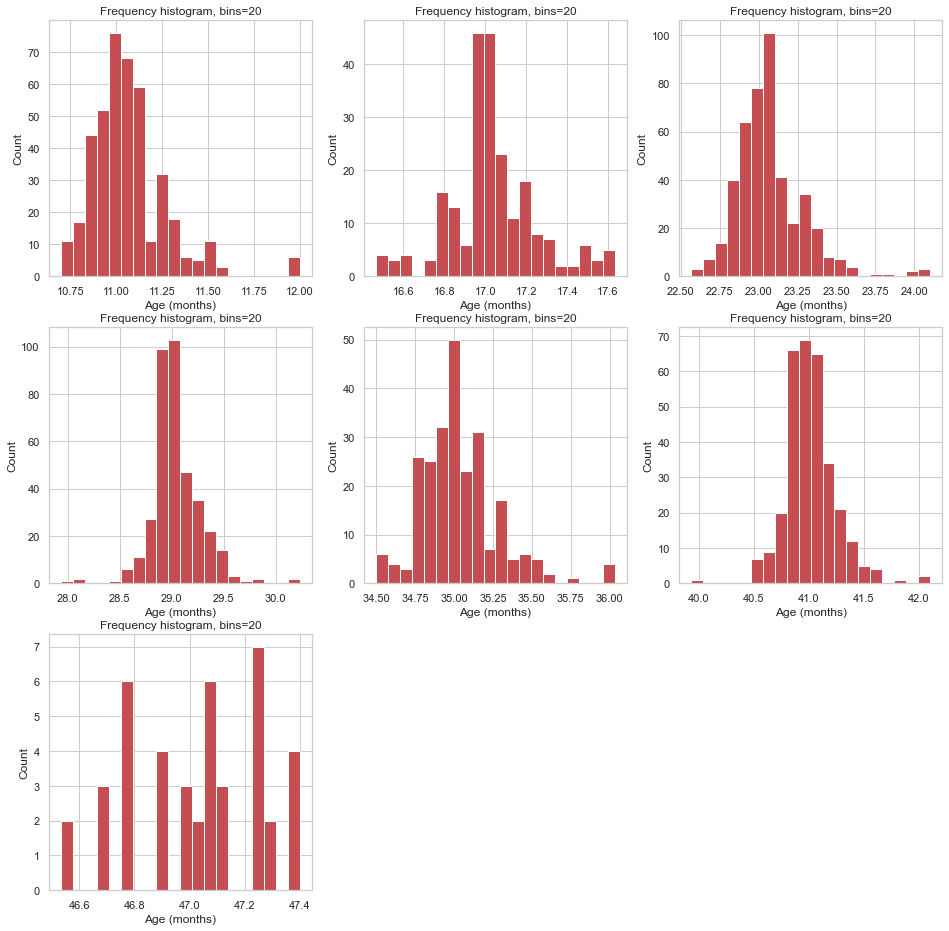

In [14]:
%matplotlib inline

bins = 20

fig, axes = plt.subplots(3, 3, figsize=(16,16))
for i, ax in enumerate(axes.flat):
    if i+1 > len(data):
        ax.remove()
    else:
        ax.hist(data[i]['age_months'], bins=bins, color='r')
        ax.set_xlabel('Age (months)')
        ax.set_ylabel('Count')
        ax.set_title(f'Frequency histogram, bins={bins}')

## Important note: we should examine any discrepancy in numbers from original pro-processing.
Below is a picture from the original pre-processing 

![title](../bjorn_bars.png)

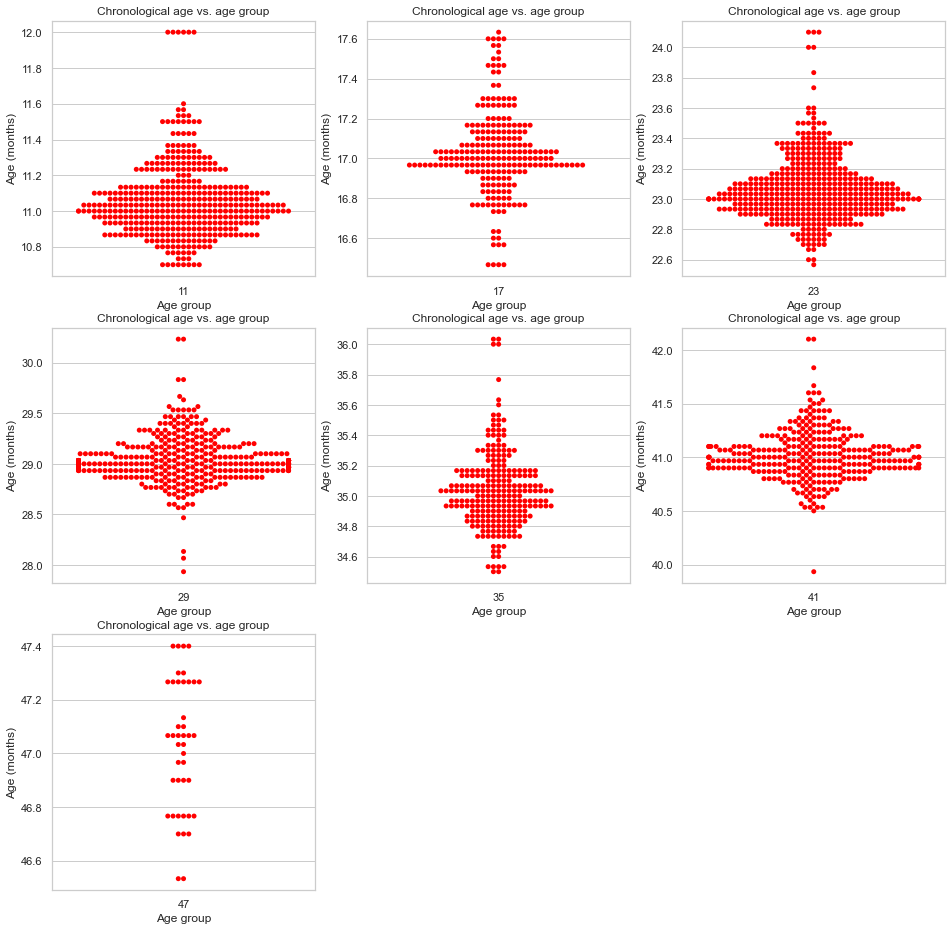

In [15]:
fig, axes = plt.subplots(3, 3, figsize=(16,16))
for i, ax in enumerate(axes.flat):
    if i+1 > len(data):
        ax.remove()
    else:
        sns.swarmplot(ax=ax, x="age_group", y="age_months", data=data[i], color = 'red')
        ax.set_xlabel('Age group')
        ax.set_ylabel('Age (months)')
        ax.set_title('Chronological age vs. age group')

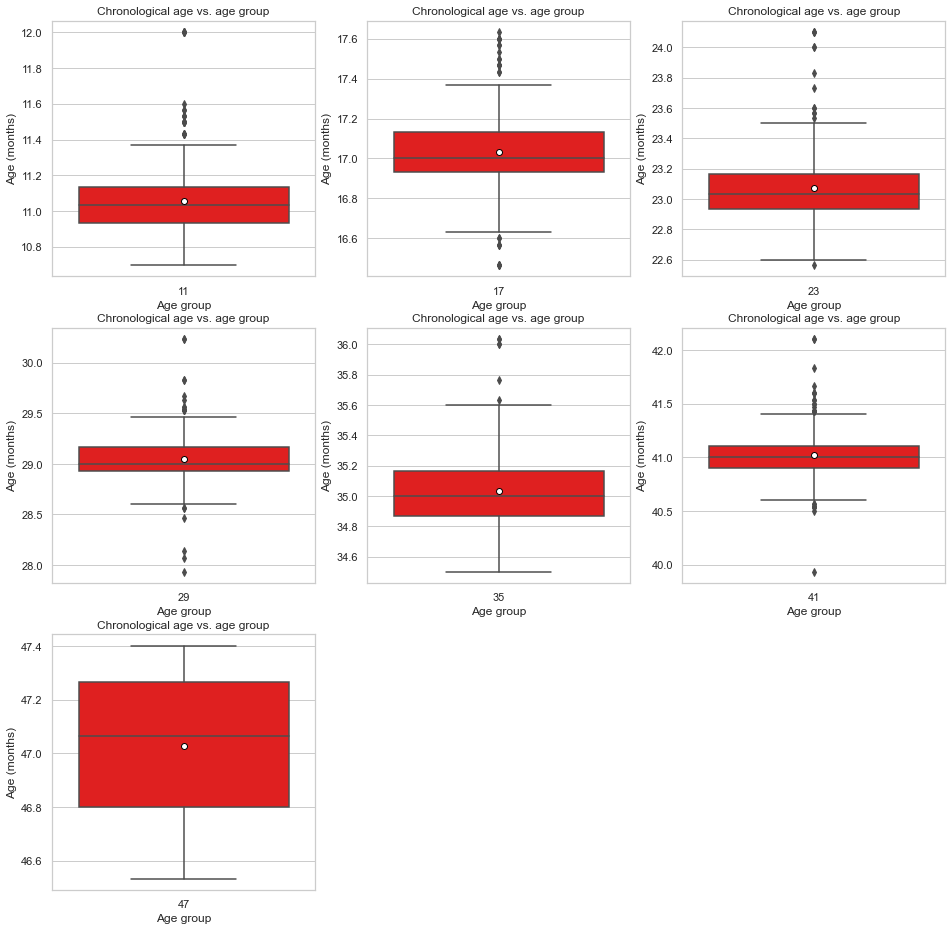

In [16]:
fig, axes = plt.subplots(3, 3, figsize=(16,16))
for i, ax in enumerate(axes.flat):
    if i+1 > len(data):
        ax.remove()
    else:    
        sns.boxplot(ax=ax, x="age_group", y="age_months", data=data[i], showmeans=True, 
                meanprops={"marker":"o",
                           "markerfacecolor":"white", 
                           "markeredgecolor":"black",
                           "markersize":"6"}, color = 'red')
        ax.set_xlabel('Age group')
        ax.set_ylabel('Age (months)')
        ax.set_title('Chronological age vs. age group')

## Check files with no label 

In [17]:
merged_df.loc[merged_df['age_days'].isnull()]

code                                           cnt_path  \
2        4  C:/Projects/EEG_explorer/Data\11mnd mmn\004_11...   
9        9  C:/Projects/EEG_explorer/Data\11mnd mmn\009_11...   
10       9  C:/Projects/EEG_explorer/Data\11mnd mmn\009_11...   
35      31  C:/Projects/EEG_explorer/Data\11mnd mmn\031_11...   
49     101  C:/Projects/EEG_explorer/Data\11mnd mmn\101_11...   
...    ...                                                ...   
1978   433  C:/Projects/EEG_explorer/Data\41mnd mmn\433_41...   
1979   433  C:/Projects/EEG_explorer/Data\41mnd mmn\433_41...   
2031   616  C:/Projects/EEG_explorer/Data\41mnd mmn\616-24...   
2123   119  C:/Projects/EEG_explorer/Data\47mnd mmn\119_47...   
2127   126  C:/Projects/EEG_explorer/Data\47mnd mmn\126_47...   

                         cnt_file  age_group  age_days  age_months  age_years  
2                   004_11_mc_mmn         11       NaN         NaN        NaN  
9     009_11_jc_mmn36_wk_mmn25_wk         11       NaN         NaN        NaN  
10             009_11_jc_mmn47_wk         11       NaN         NaN        NaN  
35             031_11_mc_mmn36_wk         11       NaN         NaN        NaN  
49                  101_11_jr_mmn         11       NaN         NaN        NaN  
...                           ...        ...       ...         ...        ...  
1978          433_41_jd_mmn25_slp         41       NaN         NaN        NaN  
1979          433_41_jd_mmn36_mix         41       NaN         NaN        NaN  
2031         616-240-41m-mc-mmn39         41       NaN         NaN        NaN  
2123              119_47_jr_mmn39         47       NaN         NaN        NaN  
2127              126_47_md_mmn36         47       NaN         NaN        NaN  

[73 rows x 7 columns]

## Great! WE got exactly the same number of files with missing age labels

### Fill in the missing age data based on the age group the subject is in

We know the age group (i.e. 11, 17, 23, .. months etc) of all the subjects, based on the folder the files are in and based on the file name. We have got the exact ages (in days) of most subjects seperately, which we have added to the DataFrame above. For some of the subjects, we don't have the exact age and therefore we set this equal to the age group.

In [18]:
merged_df['age_months'].fillna(merged_df['age_group'], inplace=True)
merged_df['age_days'].fillna(merged_df['age_group']*30, inplace=True)
merged_df['age_years'].fillna(merged_df['age_group']/12, inplace=True)

Below should now return an empty dataframe, because all empty fields have been filled

In [19]:
merged_df.loc[merged_df['age_days'].isnull()]

Empty DataFrame
Columns: [code, cnt_path, cnt_file, age_group, age_days, age_months, age_years]
Index: []

In [20]:
merged_df

code                                           cnt_path  \
0        1  C:/Projects/EEG_explorer/Data\11mnd mmn\001_11...   
1        3  C:/Projects/EEG_explorer/Data\11mnd mmn\003_11...   
2        4  C:/Projects/EEG_explorer/Data\11mnd mmn\004_11...   
3        5  C:/Projects/EEG_explorer/Data\11mnd mmn\005_11...   
4        7  C:/Projects/EEG_explorer/Data\11mnd mmn\007_11...   
...    ...                                                ...   
2144   704  C:/Projects/EEG_explorer/Data\47mnd mmn\704-03...   
2145   705  C:/Projects/EEG_explorer/Data\47mnd mmn\705-05...   
2146   709  C:/Projects/EEG_explorer/Data\47mnd mmn\709-07...   
2147   710  C:/Projects/EEG_explorer/Data\47mnd mmn\710-07...   
2148   711  C:/Projects/EEG_explorer/Data\47mnd mmn\711-08...   

                                              cnt_file  age_group  age_days  \
0        001_11_jc_mmn36_wk_mmn25_wk_mmn47_wk_mmn58_wk         11     329.0   
1     003_11_jc_mmn36_slp_mmn25_wk_mmn47_slp_mmn58_slp         11     336.0   
2                                        004_11_mc_mmn         11     330.0   
3                                       005_11_jc_mmn2         11     329.0   
4                                 007_11_jc_mmn2_36_wk         11     329.0   
...                                                ...        ...       ...   
2144                              704-032-47m-jr-mmn36         47    1422.0   
2145                              705-050-47m-jr-mmn36         47    1407.0   
2146                              709-078-47m-jr-mmn36         47    1419.0   
2147                              710-078-47m-jr-mmn36         47    1412.0   
2148                              711-085-47m-jr-mmn36         47    1413.0   

      age_months  age_years  
0      10.966667   0.913889  
1      11.200000   0.933333  
2      11.000000   0.916667  
3      10.966667   0.913889  
4      10.966667   0.913889  
...          ...        ...  
2144   47.400000   3.950000  
2145   46.900000   3.908333  
2146   47.300000   3.941667  
2147   47.066667   3.922222  
2148   47.100000   3.925000  

[2149 rows x 7 columns]

## But we don't get the same number of files...discussed in data_overview notebook

## Explore EEG data

### Import EEG data (from .cnt files)

In [21]:
# Select a file
file = merged_df['cnt_path'][500] # just a random file number

# Import file 
data_raw = mne.io.read_raw_cnt(file, eog='auto', preload=True)

Reading 0 ... 1497319  =      0.000 ...  2994.638 secs...


## What does the data look like?

In [22]:
print('Data type: {}\n\n{}\n'.format(type(data_raw), data_raw))

# Get the sample rate
print('Sample rate:', data_raw.info['sfreq'], 'Hz')

# Get the size of the matrix
print('Size of the matrix: {}\n'.format(data_raw.get_data().shape))

# The mne.info class can be used to learn more about the data.
print(data_raw.info)

Data type: <class 'mne.io.cnt.cnt.RawCNT'>

<RawCNT | 119_17_jr_mmn.cnt, 64 x 1497320 (2994.6 s), ~731.2 MB, data loaded>

Sample rate: 500.0 Hz
Size of the matrix: (64, 1497320)

<Info | 8 non-empty values
 bads: []
 ch_names: O2, O1, OZ, PZ, P4, CP4, P8, C4, TP8, T8, P7, P3, CP3, CPZ, CZ, ...
 chs: 62 EEG, 2 EOG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 500.0 Hz
 subject_info: 5 items (dict)
>


### Show data as pandas dataframe (i.e. as a table).
The raw data itself is just an array dimensions are no. of channels and timepoint.

In [23]:
raw_df = data_raw.to_data_frame()
raw_df.head()

time          O2         O1          OZ          PZ          P4  \
0     0  175.054330  29.468177  150.890922  286.713284  415.074493   
1     2  185.658416  30.514385  158.192096  272.027969  414.373353   
2     4  194.350289  32.781167  163.233382  266.433563  414.548638   
3     6  199.043901  36.791629  166.188619  269.580417  417.002626   
4     8  200.086926  40.802091  168.100832  276.398598  420.858892   

          CP4          P8          C4        TP8  ...          F2          F6  \
0  291.448520  178.184993  175.347231  91.880159  ...  229.772628  137.177278   
1  292.321120  177.661433  186.631953  87.190623  ...  239.210638  148.881236   
2  293.542760  178.708553  197.569454  84.932699  ...  247.790646  158.691907   
3  295.462481  180.977314  204.687510  85.627445  ...  251.909050  162.134248   
4  298.254802  182.198955  207.986121  88.059056  ...  251.051049  158.691907   

         FC5         F1         AF4         AF8         F5        AF7  \
0  11.968776  68.487220  128.269314  115.574839   7.313887 -27.772926   
1  19.774500  78.370186  140.353906  128.069416  -5.398345 -13.624454   
2  26.192539  87.386225  149.503668  135.357919  -3.308663  -1.572052   
3  30.529052  91.200703  151.920587  134.837312  10.274270   3.842795   
4  35.559408  89.640235  148.640483  129.457702  26.643445   3.668122   

         AF3         FPZ  
0 -47.252270  177.356866  
1 -42.059713  190.615583  
2 -27.866723  202.324580  
3 -14.539160  206.629358  
4 -11.250541  204.390874  

[5 rows x 65 columns]

In [24]:
data_raw.info['bads']

[]

In [25]:
# Band-pass filter (between 1 and 40 Hz. was 0.5 to 30Hz in Stober 2016)
data_raw.filter(1, 40, fir_design='firwin')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 sec)



<RawCNT | 119_17_jr_mmn.cnt, 64 x 1497320 (2994.6 s), ~731.2 MB, data loaded>

### Plot channels

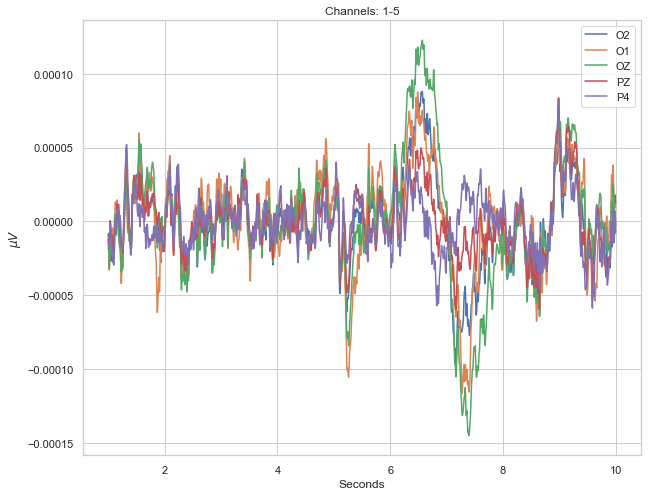

In [26]:
# Extract data from the first 5 channels, from 1 s to 10 s.
sfreq = data_raw.info['sfreq']
data, times = data_raw[:5, int(sfreq * 1):int(sfreq * 10)]

fig = plt.subplots(figsize=(10,8))
plt.plot(times, data.T)
plt.xlabel('Seconds')
plt.ylabel('$\mu V$')
plt.title('Channels: 1-5')
plt.legend(data_raw.ch_names[:5])

## We now get about the same picture (see other site)

### mne plots
There are many nice plotting options included in mne. They are, however, not always interactive and fully functional in Jupyter notebooks... so better try them out from a python script.

In [27]:
data_raw.plot(duration=10, block=True)

Using qt as 2D backend.
Opening raw-browser...
Closing raw-browser...
Channels marked as bad:
none


## In our case we made a pop-out window, but an EEG is there.

### Look at events 

In [28]:
# get the events
events, event_id = mne.events_from_annotations(data_raw)
print(events[:10,:])
print(event_id)

Used Annotations descriptions: ['0', '12', '13', '2', '3', '55', '66']
[[ 7684     0     5]
 [ 8410     0     5]
 [ 9136     0     5]
 [ 9858     0     5]
 [10584     0     5]
 [11310     0     5]
 [12036     0     3]
 [12762     0     7]
 [13488     0     5]
 [14214     0     5]]
{'0': 1, '12': 2, '13': 3, '2': 4, '3': 5, '55': 6, '66': 7}


In [29]:
# Check which unique event indentifiers there are
unique_event_types = set(events[:,2])
print(unique_event_types)

{1, 2, 3, 4, 5, 6, 7}


## It's a match.

### Search for most common event

In [30]:
tmin = -0.2
tmax = 0.8

baseline = (None, 0)  # means from the first instant to t = 0
counts = pd.Series()

# for i, path in enumerate(merged_df['cnt_path']):        
#     # Import file 
#     try:
#         raw = mne.io.read_raw_cnt(path, eog='auto', preload=True, verbose=False)
#     except: 
#         continue
    
#     # Load events
#     events_count, event_id_count = mne.events_from_annotations(raw, verbose=False)    
#     event_id_count = {y:x for x,y in event_id_count.items()}
    
#     temp_df = pd.DataFrame(events_count) 
#     temp_df[2].replace(event_id_count, inplace=True)
#     counts = counts.add(temp_df[2].value_counts(),fill_value=0)

# print(counts)

# 0        3567.0
# 1       13263.0
# 10         18.0
# 104         1.0
# 11         12.0
# 112         2.0
# 12      44920.0
# 127       304.0
# 13     120790.0
# 14       8649.0
# 15       6600.0
# 16         13.0
# 17         13.0
# 18         93.0
# 19         75.0
# 2      357282.0
# 20         15.0
# 201         2.0
# 202         2.0
# 203         2.0
# 204         2.0
# 205         2.0
# 206         2.0
# 208         2.0
# 209         2.0
# 21         10.0
# 210         2.0
# 211         2.0
# 255         2.0
# 26          1.0
# 27          1.0
# 3      878840.0
# 31          1.0
# 33        614.0
# 35          1.0
# 36          2.0
# 4       72045.0
# 40         12.0
# 41          4.0
# 45          1.0
# 48         18.0
# 49         10.0
# 5       55476.0
# 55      44602.0
# 58          5.0
# 6          12.0
# 60          9.0
# 65          5.0
# 66      91848.0
# 7          12.0
# 72          4.0
# 73          7.0
# 77       8969.0
# 8          13.0
# 80         62.0
# 81         31.0
# 82          8.0
# 88       6894.0
# 9          12.0
# 99      28749.0
# dtype: float64

In [31]:
#previous_common_events = pd.read_csv('../bjorn_common_events.txt')
#previous_common_events


old_set1= '../bjorn_common_events.txt'
with open(old_set1, 'r') as text:
    textfile = text.read()
    print(textfile)

0        3567.0
1       13263.0
10         18.0
104         1.0
11         12.0
112         2.0
12      44920.0
127       304.0
13     120790.0
14       8649.0
15       6600.0
16         13.0
17         13.0
18         93.0
19         75.0
2      357282.0
20         15.0
201         2.0
202         2.0
203         2.0
204         2.0
205         2.0
206         2.0
208         2.0
209         2.0
21         10.0
210         2.0
211         2.0
255         2.0
26          1.0
27          1.0
3      878840.0
31          1.0
33        614.0
35          1.0
36          2.0
4       72045.0
40         12.0
41          4.0
45          1.0
48         18.0
49         10.0
5       55476.0
55      44602.0
58          5.0
6          12.0
60          9.0
65          5.0
66      91848.0
7          12.0
72          4.0
73          7.0
77       8969.0
8          13.0
80         62.0
81         31.0
82          8.0
88       6894.0
9          12.0
99      28749.0
dtype: float64


## OK so here we see a very different distribution. Interesting.

### Display signal around one type of event
Selects signal for specific event ID and plots time window from tmin to tmax.

In [32]:
# event_id = [1, 2, 3, 4] # select events for the given event IDs
tmin = -0.2  # start of each epoch (200ms before the trigger)
tmax = 0.5  # end of each epoch (500ms after the trigger)

baseline = (None, 0)  # means from the first instant to t = 0
picks = mne.pick_types(data_raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')

print(picks)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63]


In [33]:
epochs = mne.Epochs(data_raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                    baseline=baseline, preload=True, verbose=True)

print(epochs)

Not setting metadata
2012 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2012 events and 351 original time points ...
0 bad epochs dropped
<Epochs |  2012 events (all good), -0.2 - 0.5 sec, baseline -0.2 – 0 sec, ~334.1 MB, data loaded,
 '0': 12
 '12': 100
 '13': 100
 '2': 800
 '3': 800
 '55': 100
 '66': 100>


In [34]:
# Export data in tabular structure as a pandas DataFrame.
epochs_df = epochs.to_data_frame()
epochs_df.head()

time condition  epoch         O2         O1         OZ         PZ  \
0  -200         3      0  19.733487  22.597901  20.047278  11.217764   
1  -198         3      0  20.655105  23.620044  21.116976  12.893161   
2  -196         3      0  21.837246  24.527912  22.449666  14.617161   
3  -194         3      0  23.185903  25.159274  23.834357  16.295032   
4  -192         3      0  24.521683  25.356660  24.990797  17.801691   

         P4        CP4        P8  ...         F2        F6       FC5  \
0  2.835124   7.186990 -4.227798  ...   0.470223 -7.124972  2.163766   
1  4.508536   8.701691 -3.361994  ...   3.613162 -4.806182  2.521073   
2  6.066433   9.963521 -2.762263  ...   6.810397 -2.267107  3.239110   
3  7.396069  10.996093 -2.481381  ...   9.839636  0.406558  4.405409   
4  8.419938  11.847577 -2.519168  ...  12.475150  3.079324  6.023836   

          F1        AF4        AF8         F5        AF7        AF3       FPZ  
0   2.438343   2.643083   2.230914   6.519844   1.897849   2.119677  0.088040  
1   5.027857   5.431945   5.048605   7.564638   3.832950   4.351600  1.953257  
2   7.844382   8.297986   7.850240   9.621177   6.715257   6.696419  4.096949  
3  10.674934  11.066978  10.475421  12.428237  10.308709   9.007766  6.491404  
4  13.294821  13.559116  12.794901  15.606350  14.251309  11.168117  9.045967  

[5 rows x 65 columns]

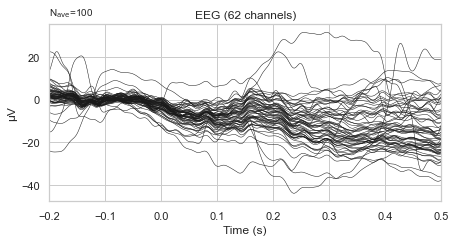

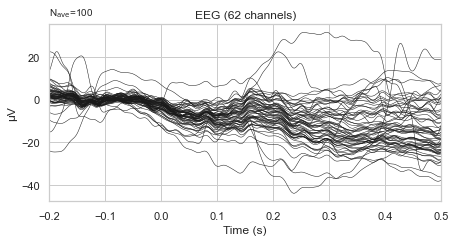

In [35]:
evoked = epochs['66'].average()
evoked.plot()

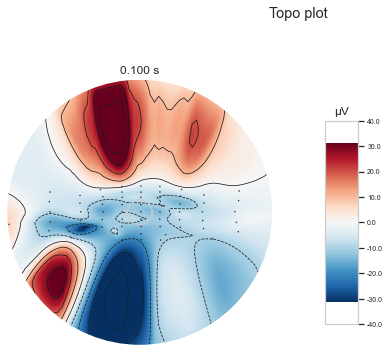

In [36]:
# Spatial plot:
evoked.plot_topomap(times=[0.1], size=3., title="Topo plot", time_unit='s');

### Plot topomaps for different time points

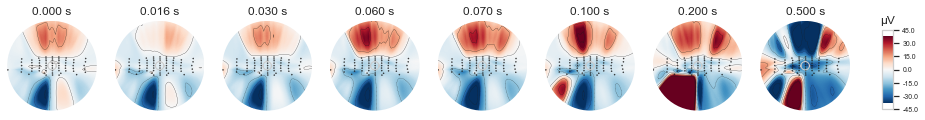

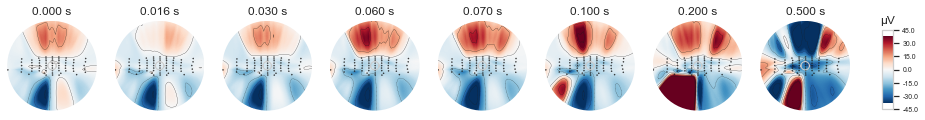

In [37]:
evoked.plot_topomap(times=np.array([0, 0.016, 0.030, 0.060, 0.070, 0.1, 0.2, 0.5]), time_unit='s')

### Test other event type

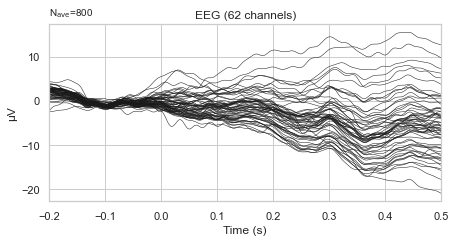

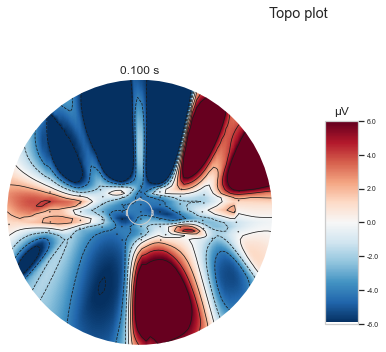

In [38]:
evoked = epochs['3'].average()
evoked.plot()
evoked.plot_topomap(times=[0.1], size=3., title="Topo plot", time_unit='s');

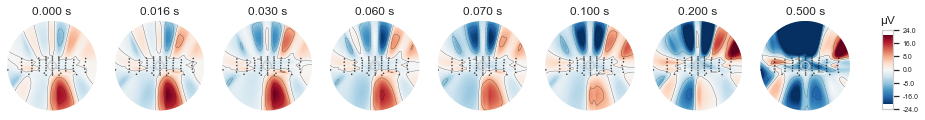

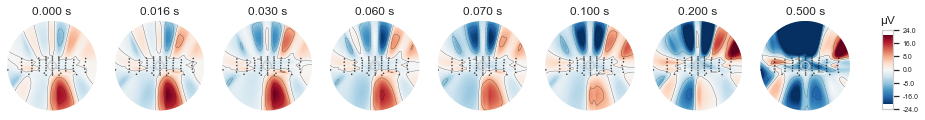

In [39]:
evoked.plot_topomap(times=np.array([0, 0.016, 0.030, 0.060, 0.070, 0.1, 0.2, 0.5]), time_unit='s')

# Adding a montage to the data

Montages specify the exact electrode placement on the scalp of the subject. This contains coordinates relative to a point on the scalp. Often this data is included in the EEG data (.cnt file). Unfortunately for us, we don't have this information. The electrode placement information can be used to fix broken channels by using the channels surrounding this channel. Even though we don't have the exact locations, we do know the electrode placement system used: 10-20. We can use this to approximate the locations.

### When looking at the maps above, the electrode placement seems to be incorrect

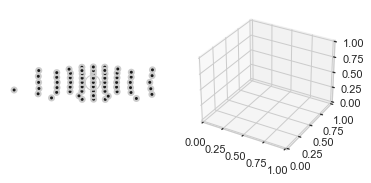

In [40]:
fig = plt.figure()
ax2d = fig.add_subplot(121)
ax3d = fig.add_subplot(122, projection='3d')
data_raw.plot_sensors(ch_type='eeg', axes=ax2d)
data_raw.plot_sensors(ch_type='eeg', axes=ax3d, kind='3d')
ax3d.view_init(azim=70, elev=15)

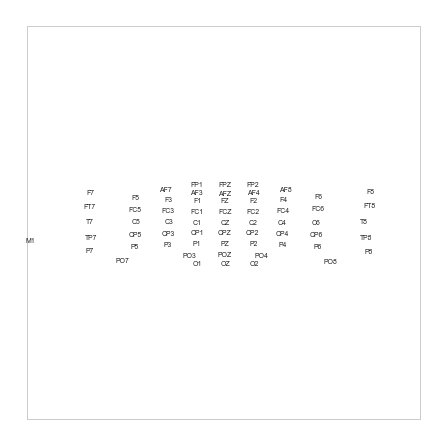

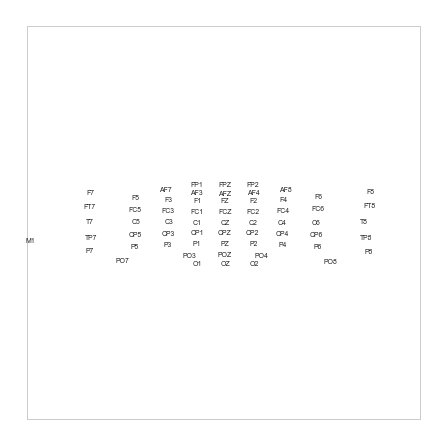

In [41]:
layout_from_raw = mne.channels.make_eeg_layout(data_raw.info)
layout_from_raw.plot()

### Unfortunately, we don't have the exact sensor locations. Therefore, we try to approximate them with a standard montage.

Standard montages come with the mne package. They're based on well known and often used electrode placement systems (10-20 in our case).

In [42]:
print(data_raw.ch_names)

['O2', 'O1', 'OZ', 'PZ', 'P4', 'CP4', 'P8', 'C4', 'TP8', 'T8', 'P7', 'P3', 'CP3', 'CPZ', 'CZ', 'FC4', 'FT8', 'TP7', 'C3', 'FCZ', 'FZ', 'F4', 'F8', 'T7', 'FT7', 'FC3', 'F3', 'FP2', 'F7', 'FP1', 'HEOG', 'VEOG', 'AFZ', 'PO3', 'P1', 'POZ', 'P2', 'PO4', 'CP2', 'P6', 'M1', 'CP6', 'C6', 'PO8', 'PO7', 'P5', 'CP5', 'CP1', 'C1', 'C2', 'FC2', 'FC6', 'C5', 'FC1', 'F2', 'F6', 'FC5', 'F1', 'AF4', 'AF8', 'F5', 'AF7', 'AF3', 'FPZ']


In [43]:
len(data_raw.ch_names)

64

In [44]:
montage = mne.channels.make_standard_montage('standard_1020')
montage.ch_names = [ch_name.upper() for ch_name in montage.ch_names]

4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 90 unique labels.
Creating RawArray with float64 data, n_channels=90, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


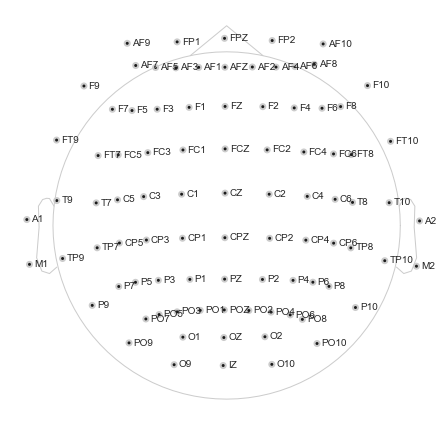

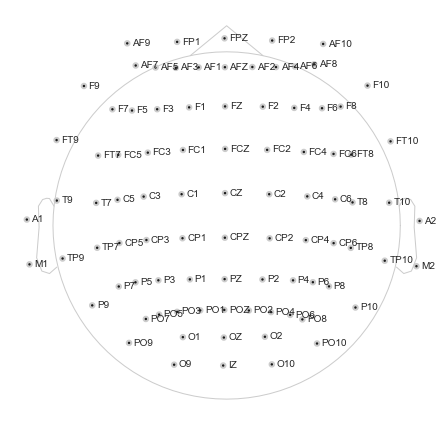

In [45]:
montage.plot(kind='topomap', show_names=True)

In [46]:
data_raw_1020 = data_raw.copy().set_montage(montage)

### Now, after setting the 1020 montage, the maps look different

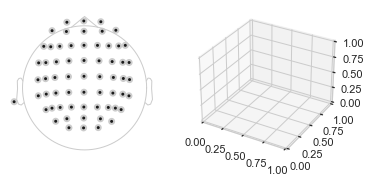

In [47]:
fig = plt.figure()
ax2d = fig.add_subplot(121)
ax3d = fig.add_subplot(122, projection='3d')
data_raw_1020.plot_sensors(ch_type='eeg', axes=ax2d)
data_raw_1020.plot_sensors(ch_type='eeg', axes=ax3d, kind='3d')
ax3d.view_init(azim=70, elev=15)

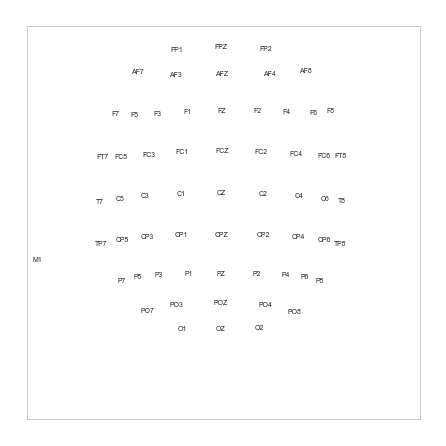

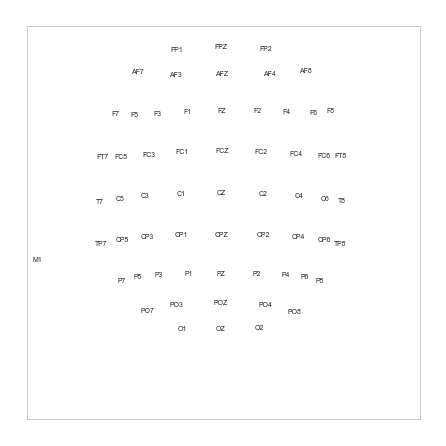

In [48]:
layout_from_raw = mne.channels.make_eeg_layout(data_raw_1020.info)
layout_from_raw.plot()

## Custom cnt-file import function:

In [49]:
def read_cnt_file_b(file,
                  label_group,
                  event_idx = [2, 3, 4, 5, 12, 13, 14, 15],
                  channel_set = "30",
                  tmin = -0.2,
                  tmax = 0.8,
                  lpass = 0.5, 
                  hpass = 40, 
                  threshold = 5, 
                  max_bad_fraction = 0.2,
                  max_bad_channels = 2):
    """ Function to read cnt file. Run bandpass filter. 
    Then detect and correct/remove bad channels and bad epochs.
    Store resulting epochs as arrays.
    
    Args:
    --------
    file: str
        Name of file to import.
    label_group: int
        Unique ID of specific group (must be >0).
    channel_set: str
        Select among pre-defined channel sets. Here: "30" or "62"
    """
    
    if channel_set == "30":
        channel_set = ['O2', 'O1', 'OZ', 'PZ', 'P4', 'CP4', 'P8', 'C4', 'TP8', 'T8', 'P7', 
                       'P3', 'CP3', 'CPZ', 'CZ', 'FC4', 'FT8', 'TP7', 'C3', 'FCZ', 'FZ', 
                       'F4', 'F8', 'T7', 'FT7', 'FC3', 'F3', 'FP2', 'F7', 'FP1']
    elif channel_set == "62":
        channel_set = ['O2', 'O1', 'OZ', 'PZ', 'P4', 'CP4', 'P8', 'C4', 'TP8', 'T8', 'P7', 
                       'P3', 'CP3', 'CPZ', 'CZ', 'FC4', 'FT8', 'TP7', 'C3', 'FCZ', 'FZ', 
                       'F4', 'F8', 'T7', 'FT7', 'FC3', 'F3', 'FP2', 'F7', 'FP1', 'AFZ', 'PO3', 
                       'P1', 'POZ', 'P2', 'PO4', 'CP2', 'P6', 'M1', 'CP6', 'C6', 'PO8', 'PO7', 
                       'P5', 'CP5', 'CP1', 'C1', 'C2', 'FC2', 'FC6', 'C5', 'FC1', 'F2', 'F6', 
                       'FC5', 'F1', 'AF4', 'AF8', 'F5', 'AF7', 'AF3', 'FPZ']
    else:
        print("Predefined channel set given by 'channel_set' not known...")
        
    
    # Initialize array
    signal_collection = np.zeros((0,len(channel_set),501))
    label_collection = [] #np.zeros((0))
    channel_names_collection = []
    
    # Import file
    try:
        data_raw = mne.io.read_raw_cnt(file, eog='auto', preload=True, verbose=False)
    except ValueError:
        print("ValueError")
        print("Could not load file:", file)
        return None, None, None
    
    # Band-pass filter (between 0.5 and 40 Hz. was 0.5 to 30Hz in Stober 2016)
    data_raw.filter(0.5, 40, fir_design='firwin')

    # Get events from annotations in the data
    events_from_annot, event_dict = mne.events_from_annotations(data_raw)
    
    # Set baseline:
    baseline = (None, 0)  # means from the first instant to t = 0

    # Select channels to exclude (if any)
    channels_exclude = [x for x in data_raw.ch_names if x not in channel_set]
    channels_exclude = [x for x in channels_exclude if x not in ['HEOG', 'VEOG']]
    
    for event_id in event_idx:
        if str(event_id) in event_dict:
            # Pick EEG channels
            picks = mne.pick_types(data_raw.info, meg=False, eeg=True, stim=False, eog=False,
                               #exclude=data_exclude)#'bads'])
                                   include=channel_set, exclude=channels_exclude)#'bads'])

            epochs = mne.Epochs(data_raw, events=events_from_annot, event_id=event_dict,
                                tmin=tmin, tmax=tmax, proj=True, picks=picks,
                                baseline=baseline, preload=True, event_repeated='merge', verbose=False)

            # Detect potential bad channels and epochs
            bad_channels, bad_epochs = helper_functions.select_bad_epochs(epochs,
                                                                          event_id,
                                                                          threshold = threshold,
                                                                          max_bad_fraction = max_bad_fraction)

            # Interpolate bad channels
            # ------------------------------------------------------------------
            if len(bad_channels) > 0:
                if len(bad_channels) > max_bad_channels:
                    print(20*'--')
                    print("Found too many bad channels (" + str(len(bad_channels)) + ")")
                    return None, None, None
                else:
                    # MARK: Setting the montage is not verified yet (choice of standard montage)
                    montage = mne.channels.make_standard_montage('standard_1020')
                    montage.ch_names = [ch_name.upper() for ch_name in montage.ch_names]
                    data_raw.set_montage(montage)
                    
                    # TODO: Think about using all channels before removing (62 -> 30), to enable for better interpolation
                    
                    # Mark bad channels:
                    data_raw.info['bads'] = bad_channels
                    # Pick EEG channels:
                    picks = mne.pick_types(data_raw.info, meg=False, eeg=True, stim=False, eog=False,
                                       #exclude=data_exclude)#'bads'])
                                       include=channel_set, exclude=channels_exclude)#'bads'])
                    epochs = mne.Epochs(data_raw, events=events_from_annot, event_id=event_dict,
                                        tmin=tmin, tmax=tmax, proj=True, picks=picks,
                                        baseline=baseline, preload=True, verbose=False)
                    
                    # Interpolate bad channels using functionality of 'mne'
                    epochs.interpolate_bads()
                    

            # Get signals as array and add to total collection
            channel_names_collection.append(epochs.ch_names)
            signals_cleaned = epochs[str(event_id)].drop(bad_epochs).get_data()
            signal_collection = np.concatenate((signal_collection, signals_cleaned), axis=0)
            label_collection += [event_id + label_group] * signals_cleaned.shape[0]

    return signal_collection, label_collection, channel_names_collection

In [50]:
def read_cnt_file(file,
                  label_group,
                  event_idx = [2, 3, 4, 5, 12, 13, 14, 15],
                  channel_set = "30",
                  tmin = -0.2,
                  tmax = 0.8,
                  lpass = 0.5, 
                  hpass = 40, 
                  threshold = 5, 
                  max_bad_fraction = 0.2,
                  max_bad_channels = 2):
    """ Function to read cnt file. Run bandpass filter. 
    Then detect and correct/remove bad channels and bad epochs.
    Store resulting epochs as arrays.
    
    Args:
    --------
    file: str
        Name of file to import.
    label_group: int
        Unique ID of specific group (must be >0).
    channel_set: str
        Select among pre-defined channel sets. Here: "30" or "62"
    """
    
    if channel_set == "30":
        channel_set = ['O2', 'O1', 'OZ', 'PZ', 'P4', 'CP4', 'P8', 'C4', 'TP8', 'T8', 'P7', 
                       'P3', 'CP3', 'CPZ', 'CZ', 'FC4', 'FT8', 'TP7', 'C3', 'FCZ', 'FZ', 
                       'F4', 'F8', 'T7', 'FT7', 'FC3', 'F3', 'FP2', 'F7', 'FP1']
    elif channel_set == "62":
        channel_set = ['O2', 'O1', 'OZ', 'PZ', 'P4', 'CP4', 'P8', 'C4', 'TP8', 'T8', 'P7', 
                       'P3', 'CP3', 'CPZ', 'CZ', 'FC4', 'FT8', 'TP7', 'C3', 'FCZ', 'FZ', 
                       'F4', 'F8', 'T7', 'FT7', 'FC3', 'F3', 'FP2', 'F7', 'FP1', 'AFZ', 'PO3', 
                       'P1', 'POZ', 'P2', 'PO4', 'CP2', 'P6', 'M1', 'CP6', 'C6', 'PO8', 'PO7', 
                       'P5', 'CP5', 'CP1', 'C1', 'C2', 'FC2', 'FC6', 'C5', 'FC1', 'F2', 'F6', 
                       'FC5', 'F1', 'AF4', 'AF8', 'F5', 'AF7', 'AF3', 'FPZ']
    else:
        print("Predefined channel set given by 'channel_set' not known...")
        
    
    # Initialize array
    signal_collection = np.zeros((0,len(channel_set),501))
    label_collection = [] #np.zeros((0))
    channel_names_collection = []
    
    # Import file
    try:
        data_raw = mne.io.read_raw_cnt(file, eog='auto', preload=True, verbose=False)
    except ValueError:
        print("ValueError")
        print("Could not load file:", file)
        return None, None, None
    
    # Band-pass filter (between 0.5 and 40 Hz. was 0.5 to 30Hz in Stober 2016)
    data_raw.filter(0.5, 40, fir_design='firwin')

    # Get events from annotations in the data
    events_from_annot, event_dict = mne.events_from_annotations(data_raw)
    
    # Set baseline:
    baseline = (None, 0)  # means from the first instant to t = 0

    # Select channels to exclude (if any)
    channels_exclude = [x for x in data_raw.ch_names if x not in channel_set]
    channels_exclude = [x for x in channels_exclude if x not in ['HEOG', 'VEOG']]
    
    for event_id in event_idx:
        if str(event_id) in event_dict:
            # Pick EEG channels
            picks = mne.pick_types(data_raw.info, meg=False, eeg=True, stim=False, eog=False,
                               #exclude=data_exclude)#'bads'])
                                   include=channel_set, exclude=channels_exclude)#'bads'])

            epochs = mne.Epochs(data_raw, events=events_from_annot, event_id=event_dict,
                                tmin=tmin, tmax=tmax, proj=True, picks=picks,
                                baseline=baseline, preload=True, event_repeated='merge', verbose=False)

            # Detect potential bad channels and epochs
            bad_channels, bad_epochs = helper_functions.select_bad_epochs(epochs,
                                                                          event_id,
                                                                          threshold = threshold,
                                                                          max_bad_fraction = max_bad_fraction)

            # Interpolate bad channels
            # ------------------------------------------------------------------
            if len(bad_channels) > 0:
                if len(bad_channels) > max_bad_channels:
                    print(20*'--')
                    print("Found too many bad channels (" + str(len(bad_channels)) + ")")
                    return None, None, None
                else:
                    # MARK: Setting the montage is not verified yet (choice of standard montage)
                    montage = mne.channels.make_standard_montage('standard_1020')
                    montage.ch_names = [ch_name.upper() for ch_name in montage.ch_names]
                    data_raw.set_montage(montage)
                    
                    # TODO: Think about using all channels before removing (62 -> 30), to enable for better interpolation
                    
                    # Mark bad channels:
                    data_raw.info['bads'] = bad_channels
                    # Pick EEG channels:
                    picks = mne.pick_types(data_raw.info, meg=False, eeg=True, stim=False, eog=False,
                                       #exclude=data_exclude)#'bads'])
                                       include=channel_set, exclude=channels_exclude)#'bads'])
                    epochs = mne.Epochs(data_raw, events=events_from_annot, event_id=event_dict,
                                        tmin=tmin, tmax=tmax, proj=True, picks=picks,
                                        baseline=baseline, preload=True, verbose=False)
                    
                    # Interpolate bad channels using functionality of 'mne'
                    epochs.interpolate_bads()
                    

            # Get signals as array and add to total collection
            channel_names_collection.append(epochs.ch_names)
            signals_cleaned = epochs[str(event_id)].drop(bad_epochs).get_data()
            signal_collection = np.concatenate((signal_collection, signals_cleaned), axis=0)
            label_collection += [event_id + label_group] * signals_cleaned.shape[0]

    return signal_collection, label_collection, channel_names_collection

In [51]:
signal_collect, label_collect, channel_names_collection = read_cnt_file(merged_df['cnt_path'][20], 
                                                                        merged_df['age_months'][0],
                                                                        event_idx = [2, 3, 4, 5, 12, 13, 14, 15],
                                                                        channel_set = "30",
                                                                        tmin = -0.2,
                                                                        tmax = 0.8,
                                                                        lpass = 0.5, 
                                                                        hpass = 40, 
                                                                        threshold = 5, 
                                                                        max_bad_fraction = 0.2,
                                                                        max_bad_channels = 2)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '13', '14', '15', '2', '3', '4', '5', '55', '66', '77', '88']
No outliers found with given threshold.
Dropped 0 epochs: 
Found 38 bad epochs in a total of 14  channels.
Marked 38 bad epochs in a total of 560  epochs.
Dropped 38 epochs: 4, 27, 29, 90, 95, 114, 118, 181, 196, 207, 214, 222, 225, 228, 234, 235, 236, 241, 244, 249, 251, 252, 254, 259, 262, 272, 284, 290, 299, 314, 320, 342, 3

In [52]:
signal_collect.shape

(1917, 30, 501)

In [53]:
len(label_collect)

1917

In [54]:
signal_collect.shape , #label_collect.shape

((1917, 30, 501),)

 label_collection, label_collect? We had a variable that in the original produced 329, as a shape. but our label_collect is 1917 long

In [55]:
### Here we see the previous had a variable based on delted code...we can't do much

In [56]:
#metadata_collection[:10]

### The above code is again produced by deleted processing, no where else is the variable referenced.

# Feature extraction and save processed data

## Determine how to store the processed data

Below we're determining what the best method is to extract and save the features. At the end, we combine all the parts.

In [57]:
local_processed_data4 = 'C:/Projects/EEG_explorer/Data/data_processed_ML4'

In [58]:
for i, file in merged_df.iterrows():
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [59]:
for i, file in merged_df.head(10).iterrows():
    
    # Import data and labels
    signal_collect, label_collect, ch_names = read_cnt_file(file['cnt_path'],
                                                            file['age_months'],
                                                            event_idx = [2, 3, 4, 5, 12, 13, 14, 15],
                                                            channel_set = "30",
                                                            tmin = -0.2,
                                                            tmax = 0.8,
                                                            lpass = 0.5, 
                                                            hpass = 40, 
                                                            threshold = 5, 
                                                            max_bad_fraction = 0.2,
                                                            max_bad_channels = 2)    
        
    # Save data and labels
    # ---------------------------------------------------------
#     if signal_collect is None:
#         continue

    # Firstly, save the metadata which will be the same for all files derived from this .cnt file
    filename_metadata = os.path.join(local_processed_data4, "processed_data_" + file['cnt_file'] + ".csv")
    pd.DataFrame(file).transpose().to_csv(filename_metadata, sep=',', index=False, header=True)        
    
    # Save all the epochs to separate files
    filename_signal = os.path.join(local_processed_data4, "processed_data_" + file['cnt_file'] + ".npy")
    np.save(filename_signal, signal_collect)
    
    #break # MARK: Remove this!

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['2', '3', '4', '5', '55', '66', '77', '88']
Found 247 bad epochs in a total of 30  channels.
Found bad channel (more than 72.0  bad epochs): Channel no:  9
Found bad channel (more than 72.0  bad epochs): Channel no:  4
Marked 129 bad epochs in a total of 360  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 28 sensor positions
In

Found 9 bad epochs in a total of 5  channels.
Marked 9 bad epochs in a total of 400  epochs.
Dropped 9 epochs: 13, 35, 61, 92, 97, 107, 269, 387, 389
Found 44 bad epochs in a total of 13  channels.
Marked 44 bad epochs in a total of 400  epochs.
Dropped 44 epochs: 0, 3, 4, 6, 7, 20, 21, 29, 30, 45, 46, 57, 58, 61, 66, 67, 68, 72, 73, 74, 75, 76, 89, 93, 94, 95, 97, 98, 100, 147, 208, 209, 210, 211, 213, 214, 215, 241, 258, 311, 325, 391, 394, 399
Found 1 bad epochs in a total of 1  channels.
Marked 1 bad epochs in a total of 50  epochs.
Dropped 1 epoch: 12
Found 3 bad epochs in a total of 4  channels.
Marked 3 bad epochs in a total of 50  epochs.
Dropped 3 epochs: 0, 2, 5
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- 

Found 1 bad epochs in a total of 3  channels.
Marked 1 bad epochs in a total of 50  epochs.
Dropped 1 epoch: 23
No outliers found with given threshold.
Dropped 0 epochs: 
Found 6 bad epochs in a total of 12  channels.
Marked 6 bad epochs in a total of 50  epochs.
Dropped 6 epochs: 8, 13, 15, 16, 28, 29
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '13', '2', '3', '55', '66']
Found 58 bad epochs in a total of 21  channels.
Marked 58 b

## Extract features that can be used for machine learning models

In [60]:
from mne_features.feature_extraction import extract_features

### Extract features from the raw data to reduce dimensionality

In [61]:
# User defined functions

def compute_rms(data):
    """Root-mean squared value of the data (per channel).
    Parameters
    ----------
    data : ndarray, shape (n_channels, n_times)
    Returns
    -------
    output : ndarray, shape (n_channels,)
    Notes
    -----
    Alias of the feature function: *rms*
    """
    return np.sqrt(np.mean(np.power(data, 2), axis=-1))

In [62]:
# print(len(signal_collect))

In [63]:
# Select features from the raw data for machine learning
selected_features = {'mean', ('root_mean_squared', compute_rms), 'hjorth_mobility', 'hjorth_complexity', 'variance', 'std', 'kurtosis', 'skewness', 'app_entropy', 'zero_crossings', 'energy_freq_bands', 'spect_edge_freq', 'ptp_amp'}

X_new = extract_features(signal_collect, 500.0, selected_features, return_as_df=1)

In [64]:
X_new

root_mean_squared                                                    \
                  ch0       ch1       ch2       ch3       ch4       ch5   
0            0.000028  0.000053  0.000120  0.000029  0.000034  0.000051   
1            0.000159  0.000151  0.000079  0.000050  0.000067  0.000065   
2            0.000032  0.000047  0.000043  0.000048  0.000057  0.000045   
3            0.000035  0.000097  0.000029  0.000033  0.000023  0.000020   
4            0.000046  0.000099  0.000046  0.000089  0.000037  0.000069   
..                ...       ...       ...       ...       ...       ...   
755          0.000042  0.000038  0.000039  0.000043  0.000030  0.000039   
756          0.000026  0.000034  0.000029  0.000049  0.000020  0.000020   
757          0.000032  0.000081  0.000054  0.000073  0.000023  0.000022   
758          0.000022  0.000054  0.000021  0.000029  0.000020  0.000025   
759          0.000045  0.000098  0.000077  0.000073  0.000050  0.000037   

                                             ...  kurtosis            \
          ch6       ch7       ch8       ch9  ...      ch20      ch21   
0    0.000029  0.000029  0.000024  0.000037  ...  1.978483  2.614803   
1    0.000022  0.000057  0.000034  0.000053  ...  2.591128  3.653344   
2    0.000034  0.000037  0.000029  0.000025  ...  2.083672  2.136444   
3    0.000033  0.000028  0.000018  0.000016  ...  2.220732  2.364227   
4    0.000046  0.000074  0.000027  0.000023  ...  2.548853  3.077483   
..        ...       ...       ...       ...  ...       ...       ...   
755  0.000029  0.000038  0.000017  0.000037  ...  2.793232  2.634549   
756  0.000021  0.000022  0.000027  0.000020  ...  2.229015  2.135139   
757  0.000017  0.000057  0.000018  0.000037  ...  2.050617  2.254622   
758  0.000023  0.000028  0.000015  0.000029  ...  3.854861  3.341746   
759  0.000021  0.000046  0.000014  0.000041  ...  1.689137  1.913418   

                                                                           \
         ch22      ch23      ch24      ch25      ch26      ch27      ch28   
0    2.271703  2.431155  2.405322  1.835858  1.675360  2.844457  2.857400   
1    2.499726  2.202240  2.767382  2.684717  2.723927  2.914039  2.202543   
2    2.482654  2.819949  2.673439  2.710487  2.358040  2.674119  2.305462   
3    2.281821  2.908570  2.840928  2.622109  2.282409  2.379820  2.240766   
4    3.525629  2.904073  2.567781  2.519603  2.750753  3.616133  3.045537   
..        ...       ...       ...       ...       ...       ...       ...   
755  3.063078  2.948522  3.157867  2.430412  2.702498  3.084855  2.897348   
756  1.894995  2.457646  2.708530  2.196646  1.952376  2.034571  1.941243   
757  2.072493  2.523056  2.445793  2.055213  2.200698  2.078957  2.416243   
758  2.529400  2.526121  2.110009  2.539371  2.758215  3.044209  1.958076   
759  2.232493  2.299974  2.333486  1.904280  1.827163  1.844818  1.668002   

               
         ch29  
0    2.311749  
1    2.256713  
2    2.499220  
3    2.472453  
4    2.741512  
..        ...  
755  3.072720  
756  1.902446  
757  2.154057  
758  3.721358  
759  1.840603  

[760 rows x 510 columns]

The raw data had a shape of (1917, 30, 501) - the extracted features data is almost 30 times smaller (before feature selection):

In [65]:
X_new.shape

(760, 510)

### here we see a very different number than the original notebook. Why? The original data collection was done over a larger set, and the notebook is probably an inaccurate representation. Let's try doing it on all

In [66]:
print(len(merged_df))

2149


In [67]:


class FileReader:
    
    default_args = {
        'event_idx': [2, 3, 4, 5, 12, 13, 14, 15],
        'channel_set': '30',
        'tmin': -0.2,
        'tmax': 0.8,
        'lpass': 0.5, 
        'hpass': 40 ,
        'threshold': 5, 
        'max_bad_fraction': 0.2,
        'max_bad_channels': 2,
    }

    def read_cnt(self, row):
        return read_cnt_file(row['cnt_path'], row['age_months'], **self.default_args)
    
    def store_all(self, df, store_prefix, nrows=None):
        if nrows is None:
            rows = df.iterrows()
        else:
            rows = df.head(nrows).iterrows()

        for i, row in rows:
            signal_collect, label_collect, ch_names = self.read_cnt(row)

            if signal_collect is None:
                continue

            store_path = os.path.join(store_prefix, 'processed_data_' + row['cnt_file'])
            store_csv = store_path + '.csv'
            store_npy = store_path + '.npy'

            pd.DataFrame(row).transpose().to_csv(store_csv, sep=',', index=False, header=True)        
            np.save(store_npy, signal_collect)

In [68]:
FileReader().store_all(merged_df, local_processed_data4)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['2', '3', '4', '5', '55', '66', '77', '88']
Found 247 bad epochs in a total of 30  channels.
Found bad channel (more than 72.0  bad epochs): Channel no:  9
Found bad channel (more than 72.0  bad epochs): Channel no:  4
Marked 129 bad epochs in a total of 360  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 28 sensor positions
In

Found 9 bad epochs in a total of 5  channels.
Marked 9 bad epochs in a total of 400  epochs.
Dropped 9 epochs: 13, 35, 61, 92, 97, 107, 269, 387, 389
Found 44 bad epochs in a total of 13  channels.
Marked 44 bad epochs in a total of 400  epochs.
Dropped 44 epochs: 0, 3, 4, 6, 7, 20, 21, 29, 30, 45, 46, 57, 58, 61, 66, 67, 68, 72, 73, 74, 75, 76, 89, 93, 94, 95, 97, 98, 100, 147, 208, 209, 210, 211, 213, 214, 215, 241, 258, 311, 325, 391, 394, 399
Found 1 bad epochs in a total of 1  channels.
Marked 1 bad epochs in a total of 50  epochs.
Dropped 1 epoch: 12
Found 3 bad epochs in a total of 4  channels.
Marked 3 bad epochs in a total of 50  epochs.
Dropped 3 epochs: 0, 2, 5
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- 

Found 1 bad epochs in a total of 3  channels.
Marked 1 bad epochs in a total of 50  epochs.
Dropped 1 epoch: 23
No outliers found with given threshold.
Dropped 0 epochs: 
Found 6 bad epochs in a total of 12  channels.
Marked 6 bad epochs in a total of 50  epochs.
Dropped 6 epochs: 8, 13, 15, 16, 28, 29
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '13', '2', '3', '55', '66']
Found 58 bad epochs in a total of 21  channels.
Marked 58 b

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['12', '13', '14', '15', '2', '3', '4', '5', '55', '66', '77', '88']
Found 16 bad epochs in a total of 2  channels.
Marked 16 bad epochs in a total of 400  epochs.
Dropped 16 epochs: 2, 33, 50, 51, 77, 90, 137, 175, 226, 228, 233, 247, 248, 298, 340, 354
Found 23 bad epochs in a total of 4  channels.
Marked 23 bad epochs in a total of 400  epochs.
Dropped 23 epochs: 4, 12, 13, 32, 34, 37, 49, 56, 57,

Found 53 bad epochs in a total of 18  channels.
Marked 53 bad epochs in a total of 400  epochs.
Dropped 53 epochs: 12, 13, 14, 15, 16, 27, 28, 34, 35, 38, 39, 226, 228, 238, 239, 250, 251, 252, 258, 259, 260, 261, 265, 273, 287, 288, 306, 307, 308, 311, 330, 331, 342, 343, 350, 351, 352, 354, 355, 360, 361, 362, 363, 364, 365, 372, 373, 377, 380, 385, 388, 389, 390
Found 4 bad epochs in a total of 4  channels.
Marked 4 bad epochs in a total of 50  epochs.
Dropped 4 epochs: 19, 20, 21, 22
Found 6 bad epochs in a total of 8  channels.
Marked 6 bad epochs in a total of 50  epochs.
Dropped 6 epochs: 27, 32, 33, 42, 44, 47
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth:

Found 5 bad epochs in a total of 14  channels.
Marked 5 bad epochs in a total of 50  epochs.
Dropped 5 epochs: 4, 17, 21, 29, 31
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 11 bad epochs in a total of 20  channels.
Marked 11 bad epochs in a total of 400  epochs.
Dropped 11 epochs: 149, 219, 231, 232, 234, 276, 300, 320, 349, 396, 398
Found 4 bad epochs in a total of 5  channels.
Marked 4 bad epochs in a total of 50

Found 31 bad epochs in a total of 12  channels.
Found bad channel (more than 10.0  bad epochs): Channel no:  17
Marked 10 bad epochs in a total of 50  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 10 epochs: 3, 16, 17, 20, 22, 24, 26, 35, 43, 45
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 33

Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 28 sensor positions
Interpolating 2 sensors
Dropped 6 epochs: 126, 187, 198, 199, 326, 362
Found 46 bad epochs in a total of 6  channels.
Found bad channel (more than 10.0  bad epochs): Channel no:  8
Marked 11 bad epochs in a total of 50  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 11 epochs: 10, 24, 27, 31, 34, 37, 38, 43, 45, 47, 48
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upp

Found 44 bad epochs in a total of 19  channels.
Marked 44 bad epochs in a total of 400  epochs.
Dropped 44 epochs: 192, 210, 211, 212, 213, 214, 215, 219, 220, 222, 223, 224, 225, 228, 229, 230, 231, 232, 233, 267, 268, 279, 280, 281, 284, 315, 319, 336, 337, 338, 339, 340, 341, 345, 351, 355, 356, 362, 363, 364, 365, 373, 374, 396
Found 7 bad epochs in a total of 4  channels.
Marked 7 bad epochs in a total of 42  epochs.
Dropped 7 epochs: 9, 16, 18, 20, 21, 25, 41
Found 6 bad epochs in a total of 5  channels.
Marked 6 bad epochs in a total of 50  epochs.
Dropped 6 epochs: 1, 28, 29, 42, 43, 44
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff f

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['2', '3', '4', '5', '55', '66', '77', '80', '81', '88']
Found 20 bad epochs in a total of 4  channels.
Marked 20 bad epochs in a total of 450  epochs.
Dropped 20 epochs: 5, 38, 70, 90, 151, 235, 242, 249, 269, 290, 305, 329, 332, 376, 377, 394, 402, 413, 438, 439
Found 8 bad epochs in a total of 4  channels.
Marked 8 bad epochs in a total of 450  epochs.
Dropped 8 epochs: 38, 110, 127, 135, 140, 230

Found 25 bad epochs in a total of 8  channels.
Marked 25 bad epochs in a total of 400  epochs.
Dropped 25 epochs: 4, 149, 161, 162, 165, 166, 168, 176, 184, 187, 189, 197, 205, 206, 207, 216, 217, 218, 219, 241, 271, 275, 284, 344, 357
Found 106 bad epochs in a total of 8  channels.
Found bad channel (more than 80.0  bad epochs): Channel no:  11
Marked 38 bad epochs in a total of 400  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 38 epochs: 26, 31, 100, 101, 126, 127, 132, 188, 264, 265, 266, 267, 285, 286, 287, 288, 304, 324, 328, 330, 332, 333, 335, 336, 338, 339, 351, 364, 369, 371, 374, 375, 376, 378, 380, 389, 391, 397
Found 6 bad epochs in a total of 5  channels.
Marked 6 bad epochs in a total of 50  epochs.
Dropped 6 epochs: 5, 7, 28, 43, 44, 48
Found 7 bad epochs in a total of 6  channels.
Marked 7 bad epochs in a total of 50  epochs.
Dropped 7 epochs: 0

Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '13', '14', '15', '18', '19', '2', '3', '35', '4', '48', '5', '55', '66', '77', '80', '81', '88']
Found 312 bad epochs in a total of 30  channels.
Found bad channel (more than 80.2  bad epochs): Channel no:  17
Found bad channel (more than 80.2  bad epochs): Channel no:  6
Found bad channel (more than 80.2  bad epochs): Channel no:  8
Found bad channel (more than 80.2  bad epochs): Channel no:  9
Marked 148 bad epochs in a total o

- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '13', '14', '2', '3', '4', '55', '66', '77']
Found 164 bad epochs in a total of 29  channels.
Found bad channel (more than 80.0  bad epochs): Channel no:  1
Marked 115 bad epochs in a total of 400  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 115 epochs: 4, 6, 9, 10, 13, 15, 16, 17, 24, 29, 30, 31, 32, 33, 34, 43, 48, 49, 50, 51, 53, 59, 63, 68, 82, 86, 88, 92, 93, 94, 95, 96, 108, 115, 117, 121, 123, 124, 126, 127, 131, 132, 133, 138, 142, 143, 147, 151, 156, 161, 162, 163, 165, 166, 168, 170, 173, 175, 178, 179, 180, 183, 187, 188, 189, 190, 203, 204, 206, 209, 210, 219, 2

Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 23 epochs: 63, 68, 74, 79, 131, 151, 155, 156, 157, 158, 198, 233, 250, 294, 310, 333, 346, 349, 381, 382, 394, 395, 396
Found 72 bad epochs in a total of 19  channels.
Found bad channel (more than 20.0  bad epochs): Channel no:  8
Marked 22 bad epochs in a total of 100  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 22 epochs: 0, 2, 4, 5, 15, 17, 19, 42, 43, 59, 66, 69, 70, 71, 73, 76, 81, 87, 89, 90, 92, 97
Found 81 bad epochs in a total of 29  channels.
Found bad channel (more than 20.0  bad epochs): Channel no:  8
Marked 39 bad epochs in a total of 100  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpo

Found 3 bad epochs in a total of 3  channels.
Marked 3 bad epochs in a total of 400  epochs.
Dropped 3 epochs: 26, 42, 201
Found 16 bad epochs in a total of 14  channels.
Marked 16 bad epochs in a total of 400  epochs.
Dropped 16 epochs: 0, 2, 20, 68, 79, 86, 121, 122, 124, 262, 265, 295, 301, 324, 377, 388
Found 18 bad epochs in a total of 30  channels.
Marked 18 bad epochs in a total of 400  epochs.
Dropped 18 epochs: 10, 14, 15, 16, 71, 92, 93, 94, 174, 195, 227, 236, 249, 259, 272, 373, 374, 380
No outliers found with given threshold.
Dropped 0 epochs: 
Found 1 bad epochs in a total of 1  channels.
Marked 1 bad epochs in a total of 50  epochs.
Dropped 1 epoch: 33
No outliers found with given threshold.
Dropped 0 epochs: 
Found 2 bad epochs in a total of 11  channels.
Marked 2 bad epochs in a total of 50  epochs.
Dropped 2 epochs: 7, 12
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one

Found 15 bad epochs in a total of 3  channels.
Marked 15 bad epochs in a total of 400  epochs.
Dropped 15 epochs: 16, 45, 66, 85, 144, 145, 160, 176, 185, 215, 246, 281, 285, 350, 368
Found 3 bad epochs in a total of 3  channels.
Marked 3 bad epochs in a total of 400  epochs.
Dropped 3 epochs: 51, 119, 373
No outliers found with given threshold.
Dropped 0 epochs: 
No outliers found with given threshold.
Dropped 0 epochs: 
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Ann

No outliers found with given threshold.
Dropped 0 epochs: 
No outliers found with given threshold.
Dropped 0 epochs: 
Found 5 bad epochs in a total of 1  channels.
Marked 5 bad epochs in a total of 400  epochs.
Dropped 5 epochs: 253, 328, 344, 369, 383
Found 1 bad epochs in a total of 1  channels.
Marked 1 bad epochs in a total of 400  epochs.
Dropped 1 epoch: 231
No outliers found with given threshold.
Dropped 0 epochs: 
No outliers found with given threshold.
Dropped 0 epochs: 
Found 2 bad epochs in a total of 1  channels.
Marked 2 bad epochs in a total of 50  epochs.
Dropped 2 epochs: 46, 48
No outliers found with given threshold.
Dropped 0 epochs: 
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge:

- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 63 bad epochs in a total of 16  channels.
Marked 63 bad epochs in a total of 279  epochs.
Dropped 63 epochs: 8, 11, 17, 22, 23, 24, 25, 28, 31, 36, 39, 40, 41, 42, 48, 49, 51, 57, 60, 65, 73, 74, 75, 77, 86, 102, 103, 106, 107, 108, 109, 124, 126, 132, 135, 148, 151, 156, 181, 182, 188, 195, 232, 236, 237, 238, 243, 244, 245, 246, 253, 258, 264, 265, 266, 268, 269, 270, 271, 272, 273, 276, 278
Found 14 bad epochs in a total of 12  channels.
Marked 14 bad epochs in a total of 36  epochs.
Dropped 14 epochs: 0, 4, 5, 7, 8, 9, 10, 11, 13, 20, 24, 29, 34, 35
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) me

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 388 bad epochs in a total of 30  channels.
Found bad channel (more than 80.0  bad epochs): Channel no:  6
Found bad channel (more than 80.0  bad epochs): Channel no:  8
Marked 61 bad epochs in a total of 400  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 28 sensor positions
Interpolating 2 sensors
D


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '13', '14', '2', '3', '4', '55', '66', '77']
Found 1 bad epochs in a total of 1  channels.
Marked 1 bad epochs in a total of 400  epochs.
Dropped 1 epoch: 36
Found 1 bad epochs in a total of 1  channels.
Marked 1 bad epochs in a total of 400  epochs.
Dropped 1 epoch: 9
Found 12 bad epochs in a total of 3  channels.
Marked 12 bad epochs in a total of 293  epochs.
Dropped 12 epochs: 79, 89, 95, 112, 117, 122, 125, 135, 141, 150, 156, 192
No outliers found with given threshold.

Found 6 bad epochs in a total of 2  channels.
Marked 6 bad epochs in a total of 50  epochs.
Dropped 6 epochs: 1, 5, 8, 33, 34, 35
Found 7 bad epochs in a total of 1  channels.
Marked 7 bad epochs in a total of 50  epochs.
Dropped 7 epochs: 0, 20, 23, 33, 37, 39, 40
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '13', '14', '15', '2', '3', '4', '5', '55', '66', '77', '88']
Found 31 bad epochs in a total of 17  channels.
Marked 31 bad e

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '14', '4', '77']
Found 5 bad epochs in a total of 2  channels.
Marked 5 bad epochs in a total of 400  epochs.
Dropped 5 epochs: 27, 40, 49, 117, 175
Found 1 bad epochs in a total of 1  channels.
Marked 1 bad epochs in a total of 50  epochs.
Dropped 1 epoch: 4
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.5

Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 2 epochs: 8, 26
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '2', '55']
Found 24 bad epochs in a total of 5  channels.
Marked 24 bad epochs in a total of 400  epochs.
Dropped 24 epochs: 0, 9, 10, 36, 37, 40, 41, 42, 44, 45, 48, 103, 122, 129, 148, 193, 293, 330, 331, 332,

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 9 bad epochs in a total of 12  channels.
Marked 9 bad epochs in a total of 480  epochs.
Dropped 9 epochs: 10, 12, 80, 102, 128, 150, 156, 164, 165
Found 1 bad epochs in a total of 3  channels.
Marked 1 bad epochs in a total of 60  epochs.
Dropped 1 epoch: 32
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband atten

Interpolating 1 sensors
Dropped 158 epochs: 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 23, 24, 26, 28, 29, 30, 32, 34, 52, 57, 63, 72, 75, 76, 77, 83, 86, 87, 97, 98, 99, 102, 106, 108, 118, 125, 128, 140, 142, 144, 150, 156, 157, 158, 159, 160, 162, 163, 164, 167, 168, 169, 177, 182, 185, 186, 194, 197, 200, 203, 207, 216, 219, 224, 225, 226, 228, 231, 241, 242, 243, 251, 253, 257, 261, 262, 263, 266, 269, 270, 271, 272, 276, 277, 278, 281, 290, 292, 297, 298, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 312, 320, 322, 325, 326, 327, 328, 330, 331, 332, 333, 335, 337, 340, 341, 342, 343, 347, 349, 350, 353, 354, 356, 358, 359, 360, 361, 362, 363, 364, 365, 366, 368, 370, 371, 373, 374, 375, 376, 378, 379, 380, 381, 383, 384, 385, 388, 391, 393, 395, 397, 398, 399
Found 38 bad epochs in a total of 15  channels.
Found bad channel (more than 10.0  bad epochs): Channel no:  8
Marked 16 bad epochs in a total of 50  epochs.
Interpolating bad channels
    Automatic origin f

Found 1 bad epochs in a total of 1  channels.
Marked 1 bad epochs in a total of 50  epochs.
Dropped 1 epoch: 49
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['15', '5', '88']
No outliers found with given threshold.
Dropped 0 epochs: 
No outliers found with given threshold.
Dropped 0 epochs: 
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, 

- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['14', '4', '77']
Found 19 bad epochs in a total of 9  channels.
Marked 19 bad epochs in a total of 400  epochs.
Dropped 19 epochs: 32, 43, 126, 145, 184, 226, 245, 256, 263, 264, 270, 287, 294, 322, 339, 363, 386, 395, 396
Found 1 bad epochs in a total of 1  channels.
Marked 1 bad epochs in a total of 50  epochs.
Dropped 1 epoch: 36
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descrip

Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 28 sensor positions
Interpolating 2 sensors
Dropped 4 epochs: 0, 1, 15, 41
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['12', '2', '55']
Found 345 bad epochs in a total of 30  channels.
Found bad channel (more than 80.0  bad epochs): Channel no:  22
Marked 105 bad epochs in a total of 400  epochs.
Interpolating bad channels
    Autom

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 36 bad epochs in a total of 30  channels.
Marked 36 bad epochs in a total of 400  epochs.
Dropped 36 epochs: 11, 12, 41, 64, 65, 121, 122, 123, 124, 140, 141, 156, 159, 160, 172, 180, 186, 194, 198, 206, 210, 211, 212, 214, 225, 226, 228, 229, 302, 303, 323, 328, 349, 350, 351, 352
Found 4 bad epochs in a total of 8  channels.
Marked 4 bad epochs in a total of 50  epochs.
Dropped 4 epochs: 1, 5, 25, 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter p

Found 2 bad epochs in a total of 3  channels.
Marked 2 bad epochs in a total of 49  epochs.
Dropped 2 epochs: 13, 16
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '13', '2', '3', '55', '66']
Found 14 bad epochs in a total of 9  channels.
Marked 14 bad epochs in a total of 530  epochs.
Dropped 14 epochs: 3, 5, 10, 11, 24, 211, 222, 242, 243, 302, 303, 304, 312, 326
Found 95 bad epochs in a total of 23  channels.
Marked 95 bad epochs i

Interpolating 1 sensors
Dropped 16 epochs: 14, 16, 18, 24, 26, 31, 32, 33, 34, 36, 37, 40, 46, 47, 48, 49
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '13', '14', '15', '2', '3', '4', '5', '55', '66', '77', '88']
Found 220 bad epochs in a total of 30  channels.
Found bad channel (more than 80.0  bad epochs): Channel no:  16
Found bad channel (more than 80.0  bad epochs): Channel no:  3
Found bad channel (more than 80.0  bad epochs):

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '2', '55']
Found 59 bad epochs in a total of 17  channels.
Marked 59 bad epochs in a total of 400  epochs.
Dropped 59 epochs: 6, 7, 10, 11, 52, 58, 59, 60, 61, 71, 72, 74, 79, 86, 103, 113, 128, 137, 151, 166, 175, 176, 177, 183, 184, 185, 186, 224, 226, 248, 266, 270, 272, 273, 274, 289, 290, 291, 292, 293, 294, 299, 301, 302, 306, 307, 308, 309, 311, 312, 322, 328, 336, 350, 351, 376, 3

Found 160 bad epochs in a total of 28  channels.
Found bad channel (more than 80.0  bad epochs): Channel no:  8
Marked 58 bad epochs in a total of 400  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 58 epochs: 7, 8, 9, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 53, 56, 57, 58, 60, 61, 64, 65, 75, 76, 83, 88, 89, 90, 91, 94, 95, 96, 97, 98, 99, 100, 109, 118, 119, 139, 198, 216, 251, 252, 262, 276, 286, 294, 309, 310, 311, 315, 317, 355, 374, 376, 381, 386, 387
Found 1 bad epochs in a total of 1  channels.
Marked 1 bad epochs in a total of 50  epochs.
Dropped 1 epoch: 36
Found 17 bad epochs in a total of 12  channels.
Marked 17 bad epochs in a total of 50  epochs.
Dropped 17 epochs: 3, 9, 11, 13, 16, 18, 20, 23, 25, 28, 29, 30, 31, 33, 34, 36, 44
Found 15 bad epochs in a total of 7  channels.
Marked 15 bad epochs in a total of 50  epochs.
Dropped 15 epochs: 3, 20, 21

- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '13', '14', '2', '3', '4', '55', '66', '77']
Found 18 bad epochs in a total of 14  channels.
Marked 18 bad epochs in a total of 400  epochs.
Dropped 18 epochs: 76, 77, 78, 79, 80, 90, 94, 95, 104, 105, 106, 107, 108, 223, 224, 294, 302, 377
Found 34 bad epochs in a total of 6  channels.
Marked 34 bad epochs in a total of 400  epochs.
Dropped 34 epochs: 64, 66, 84, 85, 121, 125, 141, 192, 193, 213, 217, 219, 265, 267, 282, 294, 298, 299, 313, 318, 321, 322, 344, 345, 347, 350, 359, 382, 383, 386, 392, 393, 395, 397
Found 154 bad epochs in a total of 3  channels.
Found bad channel (more than 80.0  bad epochs): Channel no:  8
Marked 3 bad epochs in a total of 400  epochs.
Interpolating bad channels
    Automatic origin fit: head 

- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '2', '55']
Found 39 bad epochs in a total of 18  channels.
Marked 39 bad epochs in a total of 377  epochs.
Dropped 39 epochs: 0, 1, 3, 17, 19, 23, 25, 33, 60, 102, 130, 138, 139, 141, 159, 160, 169, 171, 172, 178, 179, 182, 185, 186, 187, 190, 198, 199, 207, 208, 211, 212, 214, 217, 225, 226, 229, 287, 332
Found 2 bad epochs in a total of 7  channels.
Marked 2 bad epochs in a total of 46  epochs.
Dropped 2 epochs: 0, 21
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband rippl

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 149 bad epochs in a total of 23  channels.
Found bad channel (more than 80.0  bad epochs): Channel no:  8
Marked 113 bad epochs in a total of 400  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 113 epochs: 0, 8, 26, 36, 39, 44, 49, 50, 59, 64, 66, 71, 72, 91, 102, 103, 113, 148, 154, 160, 167, 170, 172, 180, 184, 185, 186, 187, 191, 195, 199, 201, 205, 218, 221, 222, 223, 224, 226, 228, 229, 230, 232, 233, 234, 236, 239, 240, 241, 242, 243,

Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 43 bad epochs in a total of 30  channels.
Marked 43 bad epochs in a total of 400  epochs.
Dropped 43 epochs: 0, 2, 3, 9, 21, 27, 44, 45, 49, 50, 51, 52, 53, 54, 100, 180, 219, 227, 228, 231, 232, 239, 240, 262, 266, 267, 332, 333, 334, 336, 337, 338, 340, 342, 346, 347, 348, 358, 359, 361, 362, 363, 396
Found 4 bad epochs in a total of 30  channels.
Marked 4 bad epochs in a total of 50  epochs.
Dropped 4 epochs: 6

- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 334 bad epochs in a total of 30  channels.
Found bad channel (more than 80.0  bad epochs): Channel no:  8
Marked 57 bad epochs in a total of 400  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 57 epochs: 13, 16, 20, 32, 35, 47, 48, 49, 50, 51, 54, 58, 60, 62, 63, 65, 66, 67, 68, 69, 73, 76, 78, 82, 85, 87, 90, 91, 95, 106, 107, 112, 118, 127, 128, 132, 148, 150, 154, 158, 159, 175, 179, 180, 181, 184, 189, 204, 205, 213, 214, 226, 233, 265, 294, 331, 371
Found 40 bad epochs in a total of 18  channels.
Found bad channel (more than 10.0  bad epochs): Channel no:  8
Marked 8 bad epochs in a total of 50  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Comput

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 134 bad epochs in a total of 30  channels.
Found bad channel (more than 80.0  bad epochs): Channel no:  8
Marked 56 bad epochs in a total of 400  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 56 epochs: 26, 27, 30, 33, 34, 42, 43, 45, 46, 47, 52, 5

Found 24 bad epochs in a total of 14  channels.
Marked 24 bad epochs in a total of 50  epochs.
Dropped 24 epochs: 0, 1, 3, 11, 12, 14, 15, 16, 18, 21, 23, 24, 25, 26, 28, 29, 30, 33, 35, 36, 39, 45, 47, 49
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 237 bad epochs in a total of 29  channels.
Marked 237 bad epochs in a total of 637  epochs.
Dropped 237 epochs: 2, 3, 4, 6, 9, 10, 15, 21, 24, 25, 29, 30, 31, 32, 41, 4


Used Annotations descriptions: ['0', '12', '13', '14', '2', '3', '4', '55', '66', '77']
Found 76 bad epochs in a total of 22  channels.
Marked 76 bad epochs in a total of 412  epochs.
Dropped 76 epochs: 0, 8, 10, 14, 15, 22, 23, 39, 44, 46, 51, 55, 62, 65, 68, 71, 72, 80, 82, 83, 85, 99, 105, 106, 112, 116, 118, 119, 125, 133, 136, 165, 166, 173, 179, 180, 205, 221, 229, 245, 247, 248, 251, 257, 269, 270, 273, 277, 300, 305, 306, 311, 312, 313, 315, 318, 321, 322, 323, 324, 325, 329, 337, 343, 352, 353, 354, 360, 362, 369, 372, 373, 374, 385, 387, 388
Found 54 bad epochs in a total of 20  channels.
Marked 54 bad epochs in a total of 400  epochs.
Dropped 54 epochs: 12, 44, 45, 47, 54, 56, 57, 58, 87, 97, 98, 112, 123, 136, 139, 144, 148, 172, 174, 175, 179, 181, 183, 184, 185, 195, 196, 200, 209, 216, 220, 221, 222, 223, 224, 225, 234, 235, 236, 238, 247, 250, 251, 252, 299, 323, 333, 340, 349, 358, 369, 372, 373, 397
Found 40 bad epochs in a total of 24  channels.
Marked 40 bad epochs

- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '15', '2', '5', '55', '88']
Found 12 bad epochs in a total of 13  channels.
Marked 12 bad epochs in a total of 400  epochs.
Dropped 12 epochs: 8, 42, 43, 47, 82, 105, 108, 109, 115, 116, 171, 172
Found 52 bad epochs in a total of 4  channels.
Marked 52 bad epochs in a total of 400  epochs.
Dropped 52 epochs: 3, 4, 20, 82, 121, 122, 133, 141, 147, 149, 150, 152, 153, 156, 157, 158, 159, 160, 163, 165, 166, 179, 182, 183, 184, 185, 200, 202, 204, 206, 209, 216, 217, 218, 222, 224, 233, 237, 256, 257, 258, 259, 272, 289, 307, 308, 312, 313, 326, 333, 361, 388
Found 1 bad epochs in a total of 1  channels.
Marked 1 bad epochs in a total of 50  epochs.
Dropped 1 epoch: 12
Found 3 bad epochs in a total of 

Found 49 bad epochs in a total of 6  channels.
Found bad channel (more than 9.8  bad epochs): Channel no:  8
Marked 3 bad epochs in a total of 49  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 3 epochs: 6, 33, 34
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '13', '14', '2', '3', '4', '55', '66', '77']
Found 3

Found 2 bad epochs in a total of 4  channels.
Marked 2 bad epochs in a total of 50  epochs.
Dropped 2 epochs: 7, 18
Found 8 bad epochs in a total of 6  channels.
Marked 8 bad epochs in a total of 50  epochs.
Dropped 8 epochs: 8, 21, 22, 23, 24, 40, 47, 48
Found 5 bad epochs in a total of 7  channels.
Marked 5 bad epochs in a total of 50  epochs.
Dropped 5 epochs: 1, 3, 7, 27, 49
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '15', '5', '88'

Computing interpolation matrix from 28 sensor positions
Interpolating 2 sensors
Dropped 2 epochs: 5, 14
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['15', '5', '88']
Found 218 bad epochs in a total of 30  channels.
Found bad channel (more than 80.0  bad epochs): Channel no:  8
Found bad channel (more than 80.0  bad epochs): Channel no:  6
Marked 65 bad epochs in a total of 400  epochs.
Interpolating bad channels
    Automatic origin fit: head 

- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 94 bad epochs in a total of 11  channels.
Found bad channel (more than 79.80000000000001  bad epochs): Channel no:  4
Marked 31 bad epochs in a total of 399  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 31 epochs: 6, 7, 8, 13, 14, 15, 22, 23, 24, 28, 29, 30, 31, 32, 37, 38, 54, 55, 57, 64, 75, 170, 171, 172, 173, 228, 236, 238, 250, 259, 392
Found 16 bad epochs in a total of 4  channels.
Found bad channel (more than 10.0  bad epochs): Channel no:  4
Marked 5 bad epochs in a total of 50  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interp

Interpolating 1 sensors
Dropped 6 epochs: 0, 1, 24, 38, 41, 47
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '15', '5', '88']
Found 305 bad epochs in a total of 21  channels.
Found bad channel (more than 80.0  bad epochs): Channel no:  8
Marked 29 bad epochs in a total of 400  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
D

- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '2', '55']
Found 258 bad epochs in a total of 12  channels.
Marked 258 bad epochs in a total of 599  epochs.
Dropped 258 epochs: 0, 1, 5, 7, 8, 10, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 29, 31, 33, 35, 45, 46, 54, 56, 58, 59, 60, 62, 64, 70, 71, 72, 74, 76, 77, 78, 81, 83, 84, 85, 87, 89, 90, 99, 100, 102, 104, 105, 106, 107, 111, 112, 113, 115, 116, 117, 120, 124, 125, 126, 127, 131, 132, 146, 148, 150, 152, 158, 159, 160, 161, 162, 163, 164, 166, 167, 168, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 184, 185, 186, 187, 189, 190, 191, 192, 193, 194, 195, 196, 198, 199, 200, 202, 205, 206, 207, 210, 211, 212, 215, 216, 217, 218, 222, 224, 225, 226, 228, 230, 231, 233, 234, 236, 237, 238, 239, 240, 241, 242, 244, 246, 247, 250, 251, 253, 258, 259, 260, 262, 263, 265, 267, 269, 271, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 286, 287, 288, 289, 290, 291, 292, 293, 29

Interpolating 1 sensors
Dropped 95 epochs: 1, 7, 8, 14, 15, 24, 33, 34, 35, 39, 41, 43, 44, 45, 46, 48, 54, 61, 62, 68, 69, 70, 71, 72, 73, 81, 95, 96, 97, 105, 108, 110, 113, 114, 119, 120, 121, 122, 123, 124, 125, 126, 130, 131, 132, 133, 135, 136, 137, 138, 139, 145, 146, 148, 150, 151, 159, 167, 191, 193, 194, 195, 196, 209, 216, 217, 218, 219, 221, 227, 228, 230, 231, 245, 247, 249, 259, 268, 269, 279, 283, 284, 285, 287, 288, 289, 290, 291, 292, 293, 294, 296, 297, 313, 325
Found 171 bad epochs in a total of 21  channels.
Found bad channel (more than 80.0  bad epochs): Channel no:  8
Marked 80 bad epochs in a total of 400  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 80 epochs: 24, 25, 33, 34, 38, 39, 51, 52, 76, 83, 84, 85, 86, 90, 91, 93, 94, 100, 101, 104, 105, 110, 111, 112, 113, 114, 115, 121, 128, 133, 135, 149, 150, 158, 184, 185, 186, 187, 191, 19

- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 42 bad epochs in a total of 18  channels.
Marked 42 bad epochs in a total of 325  epochs.
Dropped 42 epochs: 25, 28, 58, 124, 129, 130, 131, 136, 167, 172, 179, 184, 202, 205, 206, 211, 212, 216, 217, 219, 224, 225, 244, 247, 265, 266, 270, 291, 292, 294, 297, 300, 301, 302, 309, 312, 313, 315, 318, 319, 322, 324
Found 3 bad epochs in a total of 3  channels.
Marked 3 bad epochs in a total of 42  epochs.
Dropped 3 epochs: 17, 25, 40
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming wind

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '2', '55']
Found 19 bad epochs in a total of 30  channels.
Marked 19 bad epochs in a total of 400  epochs.
Dropped 19 epochs: 4, 5, 120, 121, 122, 124, 125, 126, 128, 131, 133, 139, 146, 225, 226, 249, 250, 317, 318
Found 4 bad epochs in a total of 3  channels.
Marked 4 bad epochs in a total of 50  epochs.
Dropped 4 epochs: 1, 2, 14, 16
Filtering raw data in 1 contiguous segment
Setting u

Found 5 bad epochs in a total of 10  channels.
Marked 5 bad epochs in a total of 47  epochs.
Dropped 5 epochs: 1, 24, 33, 39, 41
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '2', '55']
Found 44 bad epochs in a total of 21  channels.
Marked 44 bad epochs in a total of 366  epochs.
Dropped 44 epochs: 0, 9, 14, 15, 19, 20, 22, 34, 92, 117, 123, 125, 142, 150, 182, 190, 193, 211, 212, 213, 214, 215, 216, 217, 219, 220, 221, 223, 224, 22

- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '2', '55']
Found 47 bad epochs in a total of 14  channels.
Marked 47 bad epochs in a total of 558  epochs.
Dropped 47 epochs: 122, 123, 124, 125, 126, 127, 135, 136, 137, 150, 164, 182, 198, 199, 200, 201, 221, 227, 238, 239, 241, 242, 245, 265, 267, 288, 295, 296, 309, 317, 326, 327, 328, 329, 333, 334, 336, 337, 338, 342, 347, 348, 355, 356, 359, 363, 391
Found 7 bad epochs in a total of 9  channels.
Marked 7 bad epochs in a total of 67  epochs.
Dropped 7 epochs: 15, 17, 28, 36, 43, 45, 63
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.5

- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '15', '5', '88']
Found 34 bad epochs in a total of 13  channels.
Marked 34 bad epochs in a total of 400  epochs.
Dropped 34 epochs: 2, 6, 11, 12, 18, 19, 20, 46, 48, 78, 80, 89, 95, 96, 97, 98, 102, 104, 120, 139, 164, 198, 217, 218, 219, 220, 221, 222, 223, 226, 230, 236, 237, 399
Found 3 bad epochs in a total of 6  channels.
Marked 3 bad epochs in a total of 50  epochs.
Dropped 3 epochs: 16, 19, 24
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 1 bad epochs in a total of 1  channels.
Marked 1 bad epochs in a total of 400  epochs.
Dropped 1 epoch: 388
No outliers found with given threshold.
Dropped 0 epochs: 
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed t

Found 18 bad epochs in a total of 4  channels.
Found bad channel (more than 10.0  bad epochs): Channel no:  8
Marked 6 bad epochs in a total of 50  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 6 epochs: 1, 8, 15, 17, 18, 22
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 35 bad epochs in a tota

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '14', '4', '77']
Found 23 bad epochs in a total of 19  channels.
Marked 23 bad epochs in a total of 400  epochs.
Dropped 23 epochs: 11, 17, 27, 28, 35, 66, 68, 72, 91, 94, 95, 96, 101, 102, 114, 240, 311, 356, 359, 373, 385, 386, 387
Found 4 bad epochs in a total of 9  channels.
Marked 4 bad epochs in a total of 50  epochs.
Dropped 4 epochs: 6, 9, 43, 45
Filtering raw data in 1 contiguous segme

Found 27 bad epochs in a total of 20  channels.
Marked 27 bad epochs in a total of 400  epochs.
Dropped 27 epochs: 12, 27, 40, 115, 117, 118, 119, 120, 148, 163, 215, 304, 305, 325, 331, 339, 340, 342, 343, 344, 349, 354, 355, 356, 371, 388, 392
Found 3 bad epochs in a total of 2  channels.
Marked 3 bad epochs in a total of 50  epochs.
Dropped 3 epochs: 7, 15, 49
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '15', '5', '88']
Found 17 bad e

Found 16 bad epochs in a total of 9  channels.
Marked 16 bad epochs in a total of 50  epochs.
Dropped 16 epochs: 0, 1, 3, 6, 7, 8, 9, 13, 16, 20, 29, 32, 38, 40, 41, 43
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['14', '4', '77']
Found 130 bad epochs in a total of 30  channels.
Marked 130 bad epochs in a total of 400  epochs.
Dropped 130 epochs: 9, 18, 22, 24, 31, 32, 58, 61, 64, 65, 66, 67, 69, 70, 71, 74, 75, 76, 79, 81, 82, 83, 84, 90, 94,

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '2', '55']
Found 9 bad epochs in a total of 27  channels.
Marked 9 bad epochs in a total of 400  epochs.
Dropped 9 epochs: 112, 160, 219, 250, 280, 289, 293, 306, 307
Found 1 bad epochs in a total of 1  channels.
Marked 1 bad epochs in a total of 50  epochs.
Dropped 1 epoch: 36
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband at

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '2', '55']
Found 66 bad epochs in a total of 23  channels.
Marked 66 bad epochs in a total of 400  epochs.
Dropped 66 epochs: 4, 13, 53, 64, 93, 116, 122, 123, 124, 125, 126, 127, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 145, 146, 147, 148, 149, 150, 151, 152, 154, 155, 156, 157, 158, 160, 162, 170, 176, 177, 180, 185, 186, 240, 253, 254, 284, 291, 297, 328, 329, 343, 346, 3

Found 284 bad epochs in a total of 18  channels.
Found bad channel (more than 112.60000000000001  bad epochs): Channel no:  6
Found bad channel (more than 112.60000000000001  bad epochs): Channel no:  8
Marked 75 bad epochs in a total of 563  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 28 sensor positions
Interpolating 2 sensors
Dropped 75 epochs: 0, 4, 17, 18, 25, 41, 48, 58, 60, 64, 65, 66, 67, 103, 104, 105, 113, 129, 134, 150, 152, 156, 159, 160, 162, 170, 171, 174, 188, 208, 254, 255, 256, 257, 283, 345, 360, 372, 373, 379, 389, 415, 417, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 436, 440, 441, 443, 453, 454, 460, 486, 490, 495, 497, 499, 516, 519, 520, 529, 534, 537, 547, 549, 553, 561
Found 37 bad epochs in a total of 7  channels.
Found bad channel (more than 13.8  bad epochs): Channel no:  6
Found bad channel (more than 13.8  bad epochs): Channel no:  8
Marked 5 bad epochs in a total of 69  epoc

Found 1 bad epochs in a total of 16  channels.
Marked 1 bad epochs in a total of 50  epochs.
Dropped 1 epoch: 39
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '15', '5', '88']
Found 21 bad epochs in a total of 15  channels.
Marked 21 bad epochs in a total of 400  epochs.
Dropped 21 epochs: 10, 11, 12, 13, 15, 128, 166, 184, 202, 203, 204, 205, 206, 210, 214, 271, 289, 290, 325, 345, 363
Found 1 bad epochs in a total of 1  channels.
Marked 

Found 8 bad epochs in a total of 12  channels.
Marked 8 bad epochs in a total of 50  epochs.
Dropped 8 epochs: 7, 8, 30, 33, 34, 38, 47, 49
Found 6 bad epochs in a total of 9  channels.
Marked 6 bad epochs in a total of 50  epochs.
Dropped 6 epochs: 5, 6, 33, 36, 37, 47
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['12', '2', '55']
Found 182 bad epochs in a total of 30  channels.
Found bad channel (more than 80.0  bad epochs): Channel no:  17
M

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '13', '2', '3', '55', '66']
Found 37 bad epochs in a total of 13  channels.
Marked 37 bad epochs in a total of 400  epochs.
Dropped 37 epochs: 260, 261, 262, 272, 274, 281, 284, 285, 287, 289, 295, 297, 298, 304, 307, 314, 318, 319, 320, 325, 326, 328, 329, 330, 331, 336, 337, 345, 346, 347, 349, 350, 352, 361, 374, 377, 382
No outliers found with given threshold.
Dropped 0 epochs: 
Found 8 bad epochs in a total of 5  channels.
Marked 8 bad epochs in a total of 50  epochs.
Dropped 8 epochs: 31, 34, 35, 40, 41, 43, 44, 

Found 34 bad epochs in a total of 30  channels.
Found bad channel (more than 8.6  bad epochs): Channel no:  17
Found bad channel (more than 8.6  bad epochs): Channel no:  3
Found bad channel (more than 8.6  bad epochs): Channel no:  4
Found bad channel (more than 8.6  bad epochs): Channel no:  5
Found bad channel (more than 8.6  bad epochs): Channel no:  6
Found bad channel (more than 8.6  bad epochs): Channel no:  7
Found bad channel (more than 8.6  bad epochs): Channel no:  8
Found bad channel (more than 8.6  bad epochs): Channel no:  16
Found bad channel (more than 8.6  bad epochs): Channel no:  21
Found bad channel (more than 8.6  bad epochs): Channel no:  22
Found bad channel (more than 8.6  bad epochs): Channel no:  23
Found bad channel (more than 8.6  bad epochs): Channel no:  25
Found bad channel (more than 8.6  bad epochs): Channel no:  11
Marked 19 bad epochs in a total of 43  epochs.
----------------------------------------
Found too many bad channels (13)
Filtering raw data

Found 106 bad epochs in a total of 30  channels.
Marked 106 bad epochs in a total of 800  epochs.
Dropped 106 epochs: 98, 122, 138, 148, 149, 150, 153, 155, 225, 307, 339, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 424, 425, 426, 435, 437, 446, 449, 479, 486, 497, 502, 503, 520, 521, 532, 533, 553, 554, 555, 556, 565, 567, 572, 576, 577, 589, 590, 599, 604, 606, 610, 617, 631, 632, 637, 643, 646, 657, 658, 664, 675, 677, 693, 696, 700, 710, 713, 715, 722, 724, 727, 728, 729, 730, 740, 747, 753, 754, 755, 756, 760, 763, 764, 796
Found 34 bad epochs in a total of 5  channels.
Marked 34 bad epochs in a total of 400  epochs.
Dropped 34 epochs: 32, 54, 60, 118, 143, 153, 157, 158, 161, 162, 166, 235, 236, 237, 238, 249, 267, 271, 273, 275, 276, 288, 291, 294, 308, 309, 311, 312, 314, 315, 322, 330, 347, 350
Found 37 bad epochs in a total of 30  channels.
Marked 37 bad epochs in a 

Found 18 bad epochs in a total of 18  channels.
Marked 18 bad epochs in a total of 50  epochs.
Dropped 18 epochs: 1, 9, 17, 18, 19, 21, 24, 26, 33, 34, 35, 36, 37, 40, 41, 42, 45, 46
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '13', '14', '15', '2', '3', '4', '5', '55', '66', '77', '88']
Found 36 bad epochs in a total of 4  channels.
Marked 36 bad epochs in a total of 400  epochs.
Dropped 36 epochs: 0, 9, 15, 21, 31, 36, 39, 51, 66

Found 153 bad epochs in a total of 30  channels.
Marked 153 bad epochs in a total of 800  epochs.
Dropped 153 epochs: 21, 39, 40, 64, 69, 100, 109, 111, 114, 143, 149, 157, 162, 180, 182, 183, 185, 191, 192, 193, 194, 196, 202, 203, 213, 219, 220, 226, 229, 230, 233, 234, 237, 241, 243, 248, 254, 256, 258, 262, 264, 265, 267, 268, 274, 275, 276, 277, 281, 288, 296, 329, 332, 340, 349, 365, 367, 368, 374, 380, 392, 398, 401, 402, 407, 430, 437, 446, 460, 464, 478, 479, 480, 481, 482, 487, 495, 496, 497, 498, 499, 501, 502, 503, 504, 509, 510, 513, 516, 517, 518, 519, 526, 527, 531, 536, 537, 542, 546, 547, 548, 549, 550, 551, 552, 553, 554, 556, 562, 566, 569, 570, 573, 575, 578, 586, 616, 623, 624, 626, 627, 628, 629, 633, 635, 638, 641, 644, 648, 650, 654, 655, 656, 657, 668, 675, 676, 680, 681, 682, 688, 689, 703, 706, 707, 708, 741, 743, 747, 751, 775, 776, 789
Found 16 bad epochs in a total of 17  channels.
Marked 16 bad epochs in a total of 100  epochs.
Dropped 16 epochs: 7, 17, 2


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '2', '55']
Found 23 bad epochs in a total of 6  channels.
Marked 23 bad epochs in a total of 400  epochs.
Dropped 23 epochs: 136, 206, 207, 208, 209, 211, 218, 228, 230, 237, 309, 318, 319, 325, 333, 342, 350, 355, 366, 385, 389, 395, 396
Found 2 bad epochs in a total of 1  channels.
Marked 2 bad epochs in a total of 50  epochs.
Dropped 2 epochs: 37, 39
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
------------

Found 12 bad epochs in a total of 7  channels.
Marked 12 bad epochs in a total of 100  epochs.
Dropped 12 epochs: 8, 14, 26, 28, 42, 44, 53, 55, 69, 70, 85, 91
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 55 bad epochs in a total of 10  channels.
Marked 55 bad epochs in a total of 800  epochs.
Dropped 55 epochs: 34, 38, 39, 41, 42, 43, 44, 45, 46, 47, 49, 50, 60, 78, 92, 93, 110, 111, 136, 138, 139, 144, 149, 150, 1

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 16 bad epochs in a total of 30  channels.
Marked 16 bad epochs in a total of 400  epochs.
Dropped 16 epochs: 14, 18, 34, 205, 206, 211, 221, 237, 241, 248, 262, 314, 317, 335, 336, 341
Found 3 bad epochs in a total of 30  channels.
Marked 3 bad epochs in a total of 50  epochs.
Dropped 3 epochs: 27, 30, 42
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with

Found 54 bad epochs in a total of 10  channels.
Marked 54 bad epochs in a total of 400  epochs.
Dropped 54 epochs: 61, 62, 71, 107, 108, 109, 111, 190, 191, 216, 218, 219, 220, 227, 251, 260, 261, 263, 279, 280, 281, 282, 283, 289, 290, 297, 298, 304, 305, 306, 307, 308, 311, 312, 313, 315, 316, 319, 320, 325, 328, 329, 330, 339, 340, 352, 367, 373, 374, 379, 381, 386, 396, 397
Found 5 bad epochs in a total of 5  channels.
Marked 5 bad epochs in a total of 50  epochs.
Dropped 5 epochs: 14, 35, 36, 38, 48
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-

- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '14', '15', '4', '5', '77', '88']
Found 24 bad epochs in a total of 7  channels.
Marked 24 bad epochs in a total of 400  epochs.
Dropped 24 epochs: 173, 207, 246, 287, 288, 296, 308, 312, 323, 336, 340, 341, 342, 353, 359, 362, 364, 367, 369, 370, 375, 376, 390, 399
Found 21 bad epochs in a total of 5  channels.
Marked 21 bad epochs in a total of 269  epochs.
Dropped 21 epochs: 5, 60, 177, 178, 179, 217, 218, 219, 220, 222, 231, 235, 243, 244, 245, 246, 247, 248, 251, 261, 266
Found 7 bad epochs in a total of 1  channels.
Marked 7 bad epochs in a total of 50  epochs.
Dropped 7 epochs: 17, 36, 41, 42, 44, 45, 46
Found 2 bad epochs in a total of 2  channels.
Marked 2 bad epochs in a total of 31  epochs.
Dropped 2 epochs: 27, 28
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters

Found 121 bad epochs in a total of 29  channels.
Marked 121 bad epochs in a total of 400  epochs.
Dropped 121 epochs: 2, 3, 10, 11, 15, 18, 19, 35, 36, 44, 68, 70, 71, 83, 91, 93, 96, 97, 98, 100, 110, 111, 122, 131, 139, 146, 148, 149, 150, 152, 156, 163, 164, 168, 169, 171, 177, 181, 182, 185, 188, 190, 191, 192, 194, 196, 197, 199, 200, 201, 202, 203, 207, 212, 214, 217, 220, 223, 224, 225, 226, 227, 228, 232, 234, 242, 245, 246, 247, 248, 251, 258, 264, 265, 267, 268, 271, 276, 277, 281, 282, 283, 284, 285, 288, 289, 290, 292, 296, 303, 308, 311, 314, 319, 320, 321, 324, 325, 334, 335, 341, 346, 355, 374, 375, 376, 377, 378, 380, 382, 383, 384, 385, 386, 387, 388, 389, 393, 395, 396, 397
Found 249 bad epochs in a total of 30  channels.
Marked 249 bad epochs in a total of 400  epochs.
Dropped 249 epochs: 1, 2, 3, 6, 7, 8, 10, 12, 13, 14, 16, 22, 23, 25, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 51, 52, 54, 55, 56, 57, 58, 59, 61, 62, 63, 65, 69,

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 82 bad epochs in a total of 27  channels.
Marked 82 bad epochs in a total of 400  epochs.
Dropped 82 epochs: 18, 19, 20, 21, 31, 32, 37, 38, 39, 40, 41, 47, 48, 49, 50, 51, 56, 57, 58, 80, 83, 129, 130, 131, 132, 133, 145, 146, 153, 154, 155, 156, 157, 163, 169, 171, 172, 192, 193, 194, 235, 252, 256, 257, 266, 267, 268, 269, 282, 291, 296, 308, 335, 336, 337, 338, 339, 340, 3

- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['12', '2', '55']
Found 4 bad epochs in a total of 2  channels.
Marked 4 bad epochs in a total of 400  epochs.
Dropped 4 epochs: 9, 19, 34, 35
No outliers found with given threshold.
Dropped 0 epochs: 
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00

- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['12', '2', '55']
Found 20 bad epochs in a total of 20  channels.
Marked 20 bad epochs in a total of 400  epochs.
Dropped 20 epochs: 12, 16, 21, 24, 29, 34, 35, 60, 61, 272, 273, 276, 366, 367, 368, 369, 370, 371, 379, 392
Found 3 bad epochs in a total of 3  channels.
Marked 3 bad epochs in a total of 50  epochs.
Dropped 3 epochs: 3, 44, 46
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['14', '4', '77']
Found 7 bad epochs in a total of 4  channels.
Marked 7 bad epochs in a total of 400  epochs.
Dropped 7 epochs: 96, 97, 100, 151, 206, 347, 351
Found 2 bad epochs in a total of 1  channels.
Marked 2 bad epochs in a total of 50  epochs.
Dropped 2 epochs: 25, 27
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
--------------


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['12', '2', '55']
Found 95 bad epochs in a total of 18  channels.
Marked 95 bad epochs in a total of 400  epochs.
Dropped 95 epochs: 0, 5, 7, 8, 10, 16, 17, 30, 31, 37, 38, 41, 42, 44, 45, 46, 52, 59, 60, 61, 62, 63, 64, 65, 66, 83, 97, 105, 108, 124, 126, 135, 137, 152, 153, 155, 162, 163, 167, 178, 181, 194, 197, 198, 199, 209, 221, 223, 224, 235, 246, 247, 253, 254, 258, 263, 264, 265, 266, 267, 268, 279, 296, 306, 314, 315, 318, 350, 355, 356, 357, 358, 359, 360, 362, 370, 373, 374,

Found 16 bad epochs in a total of 20  channels.
Found bad channel (more than 10.0  bad epochs): Channel no:  19
Marked 11 bad epochs in a total of 50  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 11 epochs: 4, 5, 17, 18, 19, 26, 27, 28, 29, 44, 47
Found 15 bad epochs in a total of 16  channels.
Marked 15 bad epochs in a total of 50  epochs.
Dropped 15 epochs: 6, 10, 20, 22, 25, 32, 33, 34, 35, 36, 40, 42, 43, 47, 48
Found 5 bad epochs in a total of 7  channels.
Marked 5 bad epochs in a total of 50  epochs.
Dropped 5 epochs: 2, 3, 4, 5, 6
No outliers found with given threshold.
Dropped 0 epochs: 
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '1', '12', '13', '14', '15', '19', '2', '3', '4', '48', '49', '5', '55', '66', '77', '80', '88']
Found 23 bad epochs in a total of 15  channels.
Marked 23 bad epochs in a total of 400  epochs.
Dropped 23 epochs: 31, 103, 109, 110, 118, 127, 131, 154, 155, 156, 157, 182, 213, 214, 221, 222, 223, 229, 232, 355, 356, 376, 377
Found 24 bad epochs in a total of 16  channels.
Marked 24 bad epochs in 

---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '13', '14', '15', '2', '3', '4', '5', '55', '66', '77', '88']
Found 243 bad epochs in a total of 30  channels.
Found bad channel (more than 80.0  bad epochs): Channel no:  22
Found bad channel (more than 80.0  bad epochs): Channel no:  4
Marked 234 bad epochs in a total of 400  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 28 sensor positions
Interpolating 2 sensors
Dropped 234 epochs: 0, 1, 2, 3, 5, 6, 17, 18, 22, 25, 29, 3

Found 237 bad epochs in a total of 30  channels.
Found bad channel (more than 80.0  bad epochs): Channel no:  6
Found bad channel (more than 80.0  bad epochs): Channel no:  8
Marked 157 bad epochs in a total of 400  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 28 sensor positions
Interpolating 2 sensors
Dropped 157 epochs: 0, 2, 3, 4, 5, 6, 10, 11, 13, 15, 16, 17, 18, 23, 32, 35, 36, 37, 38, 39, 41, 42, 43, 45, 52, 53, 54, 55, 60, 63, 65, 69, 70, 72, 81, 83, 84, 87, 93, 96, 98, 103, 105, 106, 109, 110, 118, 119, 123, 124, 125, 126, 129, 130, 132, 133, 134, 142, 143, 145, 146, 147, 152, 155, 160, 161, 162, 163, 164, 165, 166, 168, 173, 175, 177, 181, 182, 184, 189, 190, 192, 198, 202, 205, 212, 216, 217, 225, 230, 233, 234, 242, 247, 250, 251, 254, 257, 260, 261, 263, 266, 267, 271, 277, 281, 285, 286, 290, 292, 293, 295, 301, 302, 303, 304, 305, 306, 307, 310, 313, 314, 315, 316, 320, 321, 322, 324, 325, 327, 32

Found 50 bad epochs in a total of 30  channels.
Marked 50 bad epochs in a total of 400  epochs.
Dropped 50 epochs: 54, 86, 89, 90, 91, 92, 96, 99, 100, 102, 104, 105, 122, 130, 131, 133, 134, 135, 141, 145, 146, 150, 158, 165, 167, 168, 172, 177, 185, 186, 192, 193, 194, 236, 242, 243, 244, 250, 251, 252, 253, 257, 258, 259, 260, 262, 313, 314, 325, 354
Found 159 bad epochs in a total of 30  channels.
Found bad channel (more than 80.0  bad epochs): Channel no:  0
Marked 16 bad epochs in a total of 400  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 16 epochs: 13, 110, 136, 137, 138, 174, 177, 189, 237, 272, 298, 361, 378, 393, 397, 399
Found 12 bad epochs in a total of 9  channels.
Marked 12 bad epochs in a total of 50  epochs.
Dropped 12 epochs: 20, 21, 22, 23, 24, 27, 31, 36, 39, 43, 44, 46
Found 7 bad epochs in a total of 11  channels.
Marked 7 bad epochs in a

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['12', '13', '2', '3', '55', '66']
Found 39 bad epochs in a total of 15  channels.
Marked 39 bad epochs in a total of 400  epochs.
Dropped 39 epochs: 0, 4, 8, 9, 55, 56, 57, 60, 61, 66, 67, 79, 101, 146, 163, 174, 205, 234, 235, 236, 237, 247, 281, 283, 291, 298, 307, 308, 309, 311, 325, 340, 341, 342, 344, 353, 354, 356, 358
Found 21 bad epochs in a total of 29  channels.
Marked 21 bad epochs in a total of 400  epochs.
Dropped 21 epochs: 52, 56, 169, 171, 177, 178, 185, 198, 199, 230, 273, 283, 298, 299, 310, 317, 326, 329, 353, 361, 372
Found 5 bad epochs in a total of 4  channels.
Marked 

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '15', '5', '88']
Found 375 bad epochs in a total of 25  channels.
Found bad channel (more than 80.0  bad epochs): Channel no:  8
Marked 10 bad epochs in a total of 400  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 10 epochs: 28, 29, 41, 42, 46, 47, 48, 70, 74, 75
Found 43 bad epochs in a total of 3  channels.
Found bad channel (more than 10.0  bad epochs): Channel no:  8
Marked 1 bad epochs in a total of 50  epochs.
Interpolating bad channels
    Automatic orig

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 25 bad epochs in a total of 7  channels.
Marked 25 bad epochs in a total of 400  epochs.
Dropped 25 epochs: 5, 6, 21, 40, 57, 59, 71, 73, 76, 79, 137, 138, 141, 143, 147, 150, 152, 170, 182, 183, 184, 185, 211, 228, 370
Found 3 bad epochs in a total of 1  channels.
Marked 3 bad epochs in a total of 50  epochs.
Dropped 3 epochs: 1, 8, 13
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-ca

- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['14', '4', '77']
Found 50 bad epochs in a total of 7  channels.
Marked 50 bad epochs in a total of 400  epochs.
Dropped 50 epochs: 6, 8, 14, 22, 32, 35, 39, 49, 54, 57, 58, 66, 72, 80, 84, 103, 104, 116, 127, 128, 158, 161, 192, 195, 211, 216, 217, 219, 227, 255, 257, 266, 269, 270, 274, 282, 283, 293, 297, 302, 314, 323, 329, 345, 348, 353, 354, 359, 382, 383
Found 14 bad epochs in a total of 1  channels.
Found bad channel (more than 10.0  bad epochs): Channel no:  8
Marked 0 bad epochs in a total of 50  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 0 epochs: 
Filtering raw data in 1 c


Used Annotations descriptions: ['0', '13', '3', '66']
Found 176 bad epochs in a total of 14  channels.
Found bad channel (more than 96.0  bad epochs): Channel no:  8
Marked 14 bad epochs in a total of 480  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 14 epochs: 0, 1, 3, 14, 16, 17, 19, 22, 26, 27, 30, 31, 32, 36
Found 22 bad epochs in a total of 4  channels.
Found bad channel (more than 12.0  bad epochs): Channel no:  8
Marked 2 bad epochs in a total of 60  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 2 epochs: 1, 5
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain desig

Found 50 bad epochs in a total of 2  channels.
Found bad channel (more than 10.0  bad epochs): Channel no:  8
Marked 1 bad epochs in a total of 50  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 1 epoch: 0
Found 45 bad epochs in a total of 7  channels.
Found bad channel (more than 10.0  bad epochs): Channel no:  8
Marked 6 bad epochs in a total of 50  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 6 epochs: 4, 23, 24, 27, 29, 31
Found 39 bad epochs in a total of 5  channels.
Found bad channel (more than 10.0  bad epochs): Channel no:  7
Found bad channel (more than 10.0  bad epochs): Channel no:  8
Marked 2 bad epochs in a total of 50  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolatio

- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['12', '2', '55']
Found 1 bad epochs in a total of 1  channels.
Marked 1 bad epochs in a total of 400  epochs.
Dropped 1 epoch: 46
No outliers found with given threshold.
Dropped 0 epochs: 
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filte

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '2', '55']
Found 160 bad epochs in a total of 26  channels.
Found bad channel (more than 80.0  bad epochs): Channel no:  8
Marked 83 bad epochs in a total of 400  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 83 epochs: 21, 51, 66, 67, 71, 73, 74, 75, 76, 82, 84, 85, 89, 90, 94, 95, 106, 108, 111, 114, 115, 117, 118, 119, 129, 131, 132, 135, 141, 144, 150, 151, 155, 161, 162, 185, 212, 216, 229, 236, 241, 244, 251, 252, 262, 265, 266, 270, 286, 287, 290, 293, 294, 295, 296, 297, 298, 308, 309, 310, 32

    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 70 epochs: 8, 9, 16, 28, 29, 30, 34, 35, 37, 45, 46, 47, 70, 71, 80, 119, 131, 136, 137, 138, 161, 185, 194, 195, 197, 202, 209, 210, 220, 221, 222, 240, 241, 244, 249, 257, 280, 282, 289, 290, 291, 330, 331, 332, 337, 338, 339, 341, 342, 343, 344, 345, 346, 347, 350, 351, 352, 364, 365, 369, 372, 373, 374, 382, 385, 386, 394, 395, 398, 399
Found 24 bad epochs in a total of 8  channels.
Found bad channel (more than 10.0  bad epochs): Channel no:  8
Marked 8 bad epochs in a total of 50  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 8 epochs: 0, 2, 4, 21, 25, 31, 34, 38
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-ph

- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '2', '55']
Found 396 bad epochs in a total of 6  channels.
Found bad channel (more than 80.0  bad epochs): Channel no:  17
Marked 17 bad epochs in a total of 400  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 17 epochs: 2, 18, 91, 92, 94, 95, 96, 97, 98, 99, 100, 188, 191, 193, 285, 376, 380
Found 50 bad epochs in a total of 7  channels.
Found bad channel (more than 10.0  bad epochs): Channel no:  17
Marked 3 bad epochs in a total of 50  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 29 sensor positions



Used Annotations descriptions: ['12', '2', '55']
Found 80 bad epochs in a total of 30  channels.
Marked 80 bad epochs in a total of 253  epochs.
Dropped 80 epochs: 4, 12, 29, 30, 31, 32, 33, 35, 36, 38, 41, 42, 49, 51, 56, 58, 59, 60, 62, 64, 65, 67, 68, 69, 71, 75, 76, 77, 79, 80, 83, 85, 89, 91, 94, 95, 97, 99, 102, 103, 105, 108, 111, 119, 120, 130, 136, 138, 139, 152, 153, 154, 157, 163, 164, 166, 167, 170, 171, 172, 173, 174, 176, 177, 178, 190, 191, 202, 206, 213, 216, 219, 220, 224, 225, 226, 227, 237, 238, 241
Found 7 bad epochs in a total of 4  channels.
Marked 7 bad epochs in a total of 35  epochs.
Dropped 7 epochs: 2, 4, 9, 13, 15, 20, 26
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0


Used Annotations descriptions: ['12', '2', '55']
Found 31 bad epochs in a total of 2  channels.
Marked 31 bad epochs in a total of 400  epochs.
Dropped 31 epochs: 1, 6, 153, 227, 249, 263, 264, 265, 266, 267, 268, 270, 271, 274, 275, 276, 277, 278, 279, 280, 281, 284, 294, 311, 331, 332, 334, 337, 355, 384, 397
Found 3 bad epochs in a total of 2  channels.
Marked 3 bad epochs in a total of 50  epochs.
Dropped 3 epochs: 4, 33, 35
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)



- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '2', '55']
Found 398 bad epochs in a total of 30  channels.
Found bad channel (more than 80.0  bad epochs): Channel no:  21
Found bad channel (more than 80.0  bad epochs): Channel no:  8
Marked 100 bad epochs in a total of 400  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 28 sensor positions
Interpolating 2 sensors
Dropped 100 epochs: 1, 3, 4, 9, 13, 20, 21, 25, 35, 42, 45, 56, 68, 73, 75, 78, 91, 93, 110, 124, 127, 137, 146, 148, 149, 150, 161, 162, 165, 182, 183, 185, 187, 191, 195, 197, 198, 203, 204, 206, 211, 213, 218, 227, 228, 240, 243, 246, 247, 248, 249, 250, 251, 264, 265, 266, 269, 270, 271, 272, 273, 274, 275, 276, 277, 279, 282, 284, 285, 286, 287, 289, 290, 291, 292, 293, 294, 295, 296, 302, 309, 310, 311, 313, 314, 316, 317, 318, 319, 333, 334, 339, 341, 342, 343, 347, 349, 350, 354, 356
Found 50 bad epochs in a 

- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['14', '4', '77']
Found 398 bad epochs in a total of 11  channels.
Found bad channel (more than 80.0  bad epochs): Channel no:  21
Found bad channel (more than 80.0  bad epochs): Channel no:  8
Found bad channel (more than 80.0  bad epochs): Channel no:  6
Marked 33 bad epochs in a total of 400  epochs.
----------------------------------------
Found too many bad channels (3)
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwi

Found 4 bad epochs in a total of 3  channels.
Marked 4 bad epochs in a total of 100  epochs.
Dropped 4 epochs: 6, 26, 50, 99
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['1', '12', '13', '33']
Found 3 bad epochs in a total of 14  channels.
Marked 3 bad epochs in a total of 50  epochs.
Dropped 3 epochs: 33, 35, 39
Found 1 bad epochs in a total of 1  channels.
Marked 1 bad epochs in a total of 50  epochs.
Dropped 1 epoch: 45
Filtering raw data i

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 388 bad epochs in a total of 30  channels.
Found bad channel (more than 80.0  bad epochs): Channel no:  28
Found bad channel (more than 80.0  bad epochs): Channel no:  0
Found bad channel (more than 80.0  bad epochs): Channel no:  24
Found bad channel (more than 80.0  bad epochs): Channel no:  8
Found bad channel (more than 80.0  bad epochs): Channel no:  6
Marked 65 bad epoch

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '2', '55']
Found 56 bad epochs in a total of 12  channels.
Marked 56 bad epochs in a total of 400  epochs.
Dropped 56 epochs: 1, 5, 28, 35, 54, 55, 65, 84, 85, 86, 87, 88, 98, 99, 103, 123, 124, 126, 131, 132, 144, 152, 153, 158, 162, 163, 212, 216, 217, 220, 222, 223, 224, 225, 240, 241, 269, 275, 278, 280, 282, 302, 303, 304, 305, 311, 329, 341, 342, 343, 344, 345, 346, 348, 350, 398
Fo

- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 399 bad epochs in a total of 30  channels.
Found bad channel (more than 80.0  bad epochs): Channel no:  6
Found bad channel (more than 80.0  bad epochs): Channel no:  8
Marked 107 bad epochs in a total of 400  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 28 sensor positions
Interpolating 2 sensors
Dropped 107 epochs: 5, 6, 9, 55, 65, 66, 96, 103, 104, 105, 106, 107, 108, 139, 143, 151, 154, 183, 184, 185, 222, 224, 225, 227, 230, 231, 232, 233, 234, 235, 236, 237, 240, 242, 244, 245, 246, 247, 248, 251, 252, 253, 254, 255, 256, 257, 258, 261, 262, 263, 264, 266, 267, 268, 269, 270, 273, 274, 275, 276, 277, 27

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 48 bad epochs in a total of 25  channels.
Marked 48 bad epochs in a total of 553  epochs.
Dropped 48 epochs: 26, 28, 29, 30, 32, 40, 41, 84, 85, 106, 118, 155, 156, 173, 174, 181, 205, 212, 223, 224, 240, 245, 246, 249, 258, 259, 386, 424, 425, 426, 428, 429, 436, 450, 454, 455, 463, 466, 467, 468, 471, 485, 533, 534, 535, 545, 549, 551
Found 3 bad epochs in a total of 28

- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '2', '55']
Found 43 bad epochs in a total of 27  channels.
Marked 43 bad epochs in a total of 400  epochs.
Dropped 43 epochs: 4, 14, 15, 128, 148, 157, 162, 164, 165, 166, 169, 170, 175, 184, 185, 203, 204, 205, 207, 213, 215, 218, 227, 228, 229, 234, 240, 241, 258, 262, 263, 264, 265, 294, 295, 296, 299, 300, 349, 353, 357, 369, 383
Found 6 bad epochs in a total of 6  channels.
Marked 6 bad epochs in a total of 50  epochs.
Dropped 6 epochs: 19, 20, 24, 26, 35, 48
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.01

Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 1 epoch: 27
Found 48 bad epochs in a total of 7  channels.
Found bad channel (more than 9.600000000000001  bad epochs): Channel no:  8
Marked 4 bad epochs in a total of 48  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 4 epochs: 7, 21, 41, 46
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 330


Used Annotations descriptions: ['12', '2', '55']
Found 20 bad epochs in a total of 15  channels.
Marked 20 bad epochs in a total of 400  epochs.
Dropped 20 epochs: 4, 7, 34, 50, 51, 56, 78, 155, 165, 175, 178, 185, 206, 314, 330, 348, 359, 373, 379, 398
Found 3 bad epochs in a total of 2  channels.
Marked 3 bad epochs in a total of 50  epochs.
Dropped 3 epochs: 1, 18, 20
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '2', '55']
Found 67 bad epochs in a total of 13  channels.
Marked 67 bad epochs in a total of 479  epochs.
Dropped 67 epochs: 5, 79, 87, 88, 99, 100, 101, 123, 128, 129, 130, 131, 132, 133, 157, 158, 159, 167, 168, 174, 175, 177, 178, 183, 184, 186, 187, 191, 204, 207, 208, 210, 238, 248, 250, 273, 274, 276, 301, 302, 306, 315, 321, 322, 323, 324, 325, 332, 333, 339, 340, 341, 344, 346, 3

Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 141 epochs: 2, 3, 4, 8, 9, 20, 23, 24, 29, 32, 33, 34, 35, 36, 37, 38, 39, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 60, 62, 63, 65, 67, 68, 71, 74, 80, 84, 86, 87, 91, 93, 98, 101, 112, 115, 119, 125, 155, 157, 158, 159, 167, 175, 176, 177, 178, 182, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 197, 199, 200, 203, 204, 212, 218, 219, 220, 230, 232, 235, 236, 246, 247, 250, 251, 252, 253, 256, 257, 258, 259, 260, 263, 266, 269, 271, 272, 273, 274, 276, 277, 278, 279, 280, 283, 295, 296, 297, 298, 299, 315, 319, 322, 324, 325, 327, 328, 329, 331, 334, 335, 336, 341, 344, 360, 361, 362, 363, 366, 367, 368, 370, 371, 372, 377, 381, 383, 390, 391, 392
Found 28 bad epochs in a total of 25  channels.
Found bad channel (more than 10.0  bad epochs): Channel no:  2
Found bad channel (more than 10.0  bad epochs): Channel no:  6
Marked 14 bad epochs in a total of 50  epochs.
Interpolating bad chann

- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 149 bad epochs in a total of 10  channels.
Marked 149 bad epochs in a total of 800  epochs.
Dropped 149 epochs: 10, 12, 56, 60, 62, 81, 85, 88, 94, 127, 128, 131, 132, 134, 137, 140, 155, 157, 158, 169, 185, 186, 188, 189, 190, 194, 211, 212, 214, 215, 216, 221, 222, 226, 227, 230, 231, 232, 235, 236, 237, 238, 241, 246, 247, 260, 261, 262, 273, 277, 282, 283, 287, 298, 306, 310, 314, 315, 323, 324, 325, 327, 328, 329, 335, 336, 338, 348, 351, 354, 358, 363, 367, 368, 369, 370, 371, 382, 384, 387, 402, 403, 404, 411, 413, 418, 419, 420, 424, 427, 432, 441, 446, 458, 469, 490, 491, 492, 493, 494, 497, 498, 520, 524, 567, 582, 583, 584, 585, 595, 596, 597, 622, 625, 626, 629, 630, 636

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 159 bad epochs in a total of 23  channels.
Marked 159 bad epochs in a total of 800  epochs.
Dropped 159 epochs: 1, 13, 25, 31, 32, 36, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 63, 66, 67, 70, 71, 72, 73, 76, 77, 80, 81, 82, 83, 84, 85, 86, 87, 89, 97, 98, 105, 109, 111, 123, 129, 131, 133, 137, 138, 139, 141, 146, 147, 149, 150, 151,

- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '13', '2', '3', '55', '66']
Found 219 bad epochs in a total of 30  channels.
Marked 219 bad epochs in a total of 400  epochs.
Dropped 219 epochs: 0, 2, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 22, 25, 26, 27, 28, 29, 32, 33, 34, 36, 39, 44, 45, 49, 50, 51, 52, 54, 55, 59, 60, 64, 65, 66, 69, 70, 71, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 101, 102, 104, 105, 106, 107, 108, 109, 113, 114, 115, 116, 117, 121, 123, 126, 127, 128, 137, 139, 142, 143, 145, 146, 147, 148, 149, 150, 151, 152, 154, 155, 156, 157, 161, 162, 164, 166, 169, 170, 171, 172, 173, 180, 181, 182, 187, 188, 189, 198, 199, 200, 201, 202, 203, 205, 211, 212, 213, 215, 217, 219, 220, 221, 222, 223, 224, 226, 232, 238, 239, 241, 242, 243, 244, 245, 246, 247, 249, 250, 252, 253, 254, 257, 2

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 156 bad epochs in a total of 4  channels.
Found bad channel (more than 80.0  bad epochs): Channel no:  8
Marked 8 bad epochs in a total of 400  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 8 epochs: 29, 40, 91, 165, 224, 236, 237, 392
Found 18 bad epochs in a total of 2  channels.
Found bad channel (more than 10.0  bad epochs): Channel no:  8
Marked 2 bad epochs in a total of 50  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolati

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['12', '2', '55']
Found 19 bad epochs in a total of 16  channels.
Marked 19 bad epochs in a total of 400  epochs.
Dropped 19 epochs: 3, 4, 13, 40, 41, 74, 79, 112, 123, 141, 142, 240, 265, 340, 341, 342, 344, 345, 346
Found 4 bad epochs in a total of 3  channels.
Marked 4 bad epochs in a total of 50  epochs.
Dropped 4 epochs: 1, 5, 36, 43
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window

Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 251 epochs: 7, 12, 13, 15, 17, 18, 20, 27, 28, 30, 31, 33, 36, 39, 41, 42, 44, 45, 48, 51, 56, 57, 63, 67, 72, 73, 74, 76, 77, 78, 79, 85, 89, 90, 95, 98, 108, 120, 124, 126, 127, 136, 142, 144, 145, 146, 147, 149, 151, 152, 153, 155, 159, 160, 170, 171, 172, 173, 177, 179, 183, 191, 192, 194, 196, 197, 198, 203, 205, 206, 208, 209, 211, 212, 213, 217, 218, 219, 220, 223, 225, 226, 227, 243, 246, 247, 249, 251, 254, 256, 261, 264, 267, 268, 270, 271, 274, 291, 292, 294, 295, 296, 297, 304, 305, 306, 307, 308, 309, 311, 313, 317, 318, 319, 320, 325, 326, 327, 328, 329, 331, 333, 344, 345, 358, 359, 360, 361, 362, 363, 365, 369, 370, 371, 383, 390, 398, 405, 407, 409, 410, 414, 422, 427, 428, 435, 442, 443, 445, 450, 466, 468, 469, 487, 489, 490, 491, 496, 500, 501, 502, 503, 506, 508, 511, 513, 514, 515, 516, 522, 524, 528, 5

Found 2 bad epochs in a total of 4  channels.
Marked 2 bad epochs in a total of 50  epochs.
Dropped 2 epochs: 3, 5
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 38 bad epochs in a total of 30  channels.
Marked 38 bad epochs in a total of 513  epochs.
Dropped 38 epochs: 91, 93, 101, 102, 103, 119, 120, 121, 129, 130, 142, 189, 191, 214, 271, 320, 321, 337, 339, 340, 341, 342, 343, 344, 347, 394, 395, 396, 432, 433, 43

Found 3 bad epochs in a total of 2  channels.
Marked 3 bad epochs in a total of 100  epochs.
Dropped 3 epochs: 1, 36, 87
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 9 bad epochs in a total of 7  channels.
Marked 9 bad epochs in a total of 400  epochs.
Dropped 9 epochs: 46, 76, 83, 129, 183, 379, 380, 387, 388
No outliers found with given threshold.
Dropped 0 epochs: 
Filtering raw data in 1 contiguous segment
Setting up

Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 61 epochs: 38, 107, 108, 109, 110, 112, 113, 149, 152, 159, 175, 212, 213, 225, 226, 237, 244, 251, 252, 262, 263, 283, 294, 311, 378, 379, 385, 386, 390, 392, 393, 534, 536, 543, 544, 551, 552, 553, 556, 557, 558, 560, 563, 564, 636, 637, 643, 644, 665, 737, 772, 776, 777, 778, 779, 780, 781, 782, 785, 786, 793
Found 1 bad epochs in a total of 1  channels.
Found bad channel (more than 0.2  bad epochs): Channel no:  8
Marked 0 bad epochs in a total of 1  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 0 epochs: 
Found 86 bad epochs in a total of 6  channels.
Found bad channel (more than 20.0  bad epochs): Channel no:  8
Marked 9 bad epochs in a total of 100  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 2

Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '14', '4', '77']
Found 42 bad epochs in a total of 26  channels.
Marked 42 bad epochs in a total of 249  epochs.
Dropped 42 epochs: 21, 30, 35, 36, 42, 44, 45, 46, 47, 51, 52, 53, 54, 98, 116, 117, 125, 139, 141, 153, 154, 162, 186, 192, 193, 195, 200, 201, 202, 204, 207, 208, 209, 210, 227, 228, 230, 231, 232, 233, 239, 241
Found 4 bad epochs in a total of 9  channels.
Marked 4 bad epochs in a total of 29  epochs.
Dropped 4 epochs: 6, 

Found 20 bad epochs in a total of 30  channels.
Found bad channel (more than 10.0  bad epochs): Channel no:  8
Marked 15 bad epochs in a total of 50  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 15 epochs: 1, 8, 9, 12, 14, 19, 22, 23, 26, 27, 29, 30, 43, 44, 47
Found 25 bad epochs in a total of 16  channels.
Found bad channel (more than 10.0  bad epochs): Channel no:  8
Marked 17 bad epochs in a total of 50  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 17 epochs: 1, 5, 14, 15, 16, 19, 23, 28, 33, 34, 40, 41, 43, 45, 46, 47, 48
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-do

Found 96 bad epochs in a total of 29  channels.
Marked 96 bad epochs in a total of 400  epochs.
Dropped 96 epochs: 8, 13, 19, 20, 32, 33, 48, 75, 76, 149, 150, 151, 152, 153, 154, 155, 159, 160, 191, 192, 193, 194, 195, 196, 197, 206, 208, 210, 212, 218, 219, 220, 223, 233, 234, 235, 236, 237, 239, 240, 242, 243, 245, 246, 247, 249, 250, 251, 253, 254, 255, 257, 258, 259, 261, 262, 263, 273, 274, 280, 282, 283, 284, 285, 286, 289, 291, 292, 293, 294, 295, 296, 300, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 318, 319, 320, 321, 322, 323, 324, 325, 326, 330, 333, 386
Found 17 bad epochs in a total of 21  channels.
Marked 17 bad epochs in a total of 50  epochs.
Dropped 17 epochs: 1, 5, 7, 9, 14, 23, 29, 30, 38, 39, 40, 41, 44, 46, 47, 48, 49
Found 11 bad epochs in a total of 9  channels.
Marked 11 bad epochs in a total of 50  epochs.
Dropped 11 epochs: 18, 26, 31, 33, 34, 35, 37, 38, 39, 41, 42
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 4

Found 2 bad epochs in a total of 3  channels.
Marked 2 bad epochs in a total of 50  epochs.
Dropped 2 epochs: 10, 11
Found 1 bad epochs in a total of 1  channels.
Marked 1 bad epochs in a total of 50  epochs.
Dropped 1 epoch: 45
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '2', '55']
Found 7 bad epochs in a total of 1  channels.
Marked 7 bad epochs in a total of 400  epochs.
Dropped 7 epochs: 1, 21, 36, 50, 63, 133, 264
Found 1 bad 

Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 1 epoch: 14
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 20 bad epochs in a total of 16  channels.
Marked 20 bad epochs in a total of 400  epochs.
Dropped 20 epochs: 128, 129, 240, 241, 242, 245, 246, 248, 250, 251, 252, 268, 294, 307, 308, 309, 312, 366, 367,

Found 6 bad epochs in a total of 6  channels.
Marked 6 bad epochs in a total of 60  epochs.
Dropped 6 epochs: 23, 24, 31, 38, 39, 48
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['14', '4', '77']
Found 54 bad epochs in a total of 19  channels.
Marked 54 bad epochs in a total of 400  epochs.
Dropped 54 epochs: 58, 82, 83, 140, 141, 142, 143, 144, 146, 147, 148, 149, 150, 154, 155, 156, 157, 176, 177, 178, 180, 181, 182, 185, 186, 189, 190, 194, 

- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '2', '55']
Found 61 bad epochs in a total of 29  channels.
Marked 61 bad epochs in a total of 800  epochs.
Dropped 61 epochs: 12, 16, 113, 165, 170, 237, 241, 245, 246, 260, 288, 306, 309, 312, 313, 328, 329, 331, 335, 339, 341, 345, 348, 349, 351, 353, 354, 355, 356, 357, 358, 359, 361, 362, 363, 366, 433, 434, 443, 444, 476, 477, 496, 497, 503, 511, 530, 533, 540, 561, 584, 588, 589, 590, 593, 594, 596, 598, 608, 610, 781
Found 8 bad epochs in a total of 14  channels.
Marked 8 bad epochs in a total of 100  epochs.
Dropped 8 epochs: 0, 26, 38, 39, 42, 43, 50, 74
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase,

Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 88 epochs: 0, 5, 6, 12, 19, 21, 24, 25, 31, 33, 35, 43, 44, 45, 67, 69, 79, 86, 87, 88, 89, 96, 105, 108, 109, 110, 111, 112, 113, 114, 115, 119, 120, 121, 122, 123, 124, 127, 129, 130, 147, 154, 156, 163, 164, 170, 180, 183, 186, 188, 190, 196, 199, 201, 214, 222, 231, 238, 241, 242, 243, 244, 245, 250, 251, 252, 260, 269, 273, 279, 280, 281, 282, 283, 290, 291, 306, 310, 315, 353, 360, 361, 367, 375, 378, 379, 394, 398
Found 26 bad epochs in a total of 20  channels.
Found bad channel (more than 10.0  bad epochs): Channel no:  23
Marked 13 bad epochs in a total of 50  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 13 epochs: 0, 4, 15, 17, 25, 33, 35, 37, 38, 39, 40, 43, 47
Filtering raw data in 1 cont

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 36 bad epochs in a total of 26  channels.
Marked 36 bad epochs in a total of 800  epochs.
Dropped 36 epochs: 42, 43, 66, 92, 129, 148, 149, 150, 153, 167, 168, 169, 172, 173, 174, 176, 177, 201, 291, 314, 369, 397, 398, 399, 400, 403, 417, 418, 419, 631, 704, 708, 713, 714, 723, 741
Found 4 bad epochs in a total of 5  channels.
Marked 4 bad epochs in a total of 100  epochs.
Dropped 4 epochs: 1, 10, 19, 51
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 798 bad epochs in a total of 30  channels.
Found bad channel (more than 160.0  bad epochs): Channel no:  8
Marked 17 bad epochs in a total of 800  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 17 epochs: 1, 2, 3, 17, 18, 85, 86, 87, 179, 180, 184, 185, 

Found 27 bad epochs in a total of 8  channels.
Marked 27 bad epochs in a total of 150  epochs.
Dropped 27 epochs: 25, 43, 48, 74, 78, 81, 83, 94, 95, 97, 98, 104, 105, 106, 123, 124, 126, 128, 129, 130, 132, 133, 136, 141, 144, 145, 147
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 36 bad epochs in a total of 25  channels.
Marked 36 bad epochs in a total of 800  epochs.
Dropped 36 epochs: 202, 205, 207, 208, 241, 415

Found 40 bad epochs in a total of 24  channels.
Marked 40 bad epochs in a total of 400  epochs.
Dropped 40 epochs: 109, 245, 246, 268, 277, 290, 296, 297, 298, 304, 305, 310, 311, 312, 324, 325, 327, 328, 341, 342, 346, 347, 349, 350, 357, 360, 367, 369, 373, 375, 376, 377, 379, 380, 381, 384, 385, 396, 397, 398
Found 6 bad epochs in a total of 5  channels.
Marked 6 bad epochs in a total of 50  epochs.
Dropped 6 epochs: 35, 43, 45, 46, 47, 49
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples 

No outliers found with given threshold.
Dropped 0 epochs: 
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 12 bad epochs in a total of 9  channels.
Marked 12 bad epochs in a total of 800  epochs.
Dropped 12 epochs: 364, 365, 367, 368, 372, 373, 377, 379, 400, 404, 631, 763
Found 3 bad epochs in a total of 3  channels.
Marked 3 bad epochs in a total of 100  epochs.
Dropped 3 epochs: 46, 80, 95
Filtering raw data in 1 contigu

Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 255 bad epochs in a total of 30  channels.
Found bad channel (more than 80.0  bad epochs): Channel no:  6
Marked 198 bad epochs in a total of 400  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 198 epochs: 7, 8, 9, 10, 18, 24, 26, 29, 37, 39, 50, 52, 54, 58, 60, 65, 67, 70, 77, 83, 85, 88, 9

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 396 bad epochs in a total of 4  channels.
Found bad channel (more than 80.0  bad epochs): Channel no:  8
Marked 23 bad epochs in a total of 400  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 23 epochs: 14, 29, 79, 98, 116, 120, 129, 131, 133, 141, 175, 

- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 40 bad epochs in a total of 15  channels.
Marked 40 bad epochs in a total of 770  epochs.
Dropped 40 epochs: 6, 7, 23, 40, 175, 183, 184, 186, 187, 193, 195, 198, 200, 252, 253, 278, 281, 286, 291, 333, 334, 420, 421, 456, 457, 462, 464, 465, 497, 682, 683, 686, 687, 688, 689, 690, 694, 724, 726, 728
Found 4 bad epochs in a total of 6  channels.
Marked 4 bad epochs in a total of 95  epochs.
Dropped 4 epochs: 1, 19, 20, 54
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff 


Used Annotations descriptions: ['0', '13', '3', '66']
Found 553 bad epochs in a total of 25  channels.
Found bad channel (more than 136.0  bad epochs): Channel no:  8
Found bad channel (more than 136.0  bad epochs): Channel no:  6
Marked 265 bad epochs in a total of 680  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 28 sensor positions
Interpolating 2 sensors
Dropped 265 epochs: 1, 3, 7, 15, 23, 36, 43, 46, 47, 49, 52, 56, 61, 71, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 116, 117, 118, 123, 125, 126, 127, 128, 129, 140, 147, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 167, 168, 170, 171, 172, 178, 182, 183, 189, 198, 205, 210, 212, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 230, 231, 232, 233, 234, 235, 236, 237, 239, 240, 244, 245, 246, 247, 24

- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 9 bad epochs in a total of 7  channels.
Marked 9 bad epochs in a total of 400  epochs.
Dropped 9 epochs: 0, 117, 118, 208, 209, 225, 226, 227, 230
No outliers found with given threshold.
Dropped 0 epochs: 
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descrip

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 9 bad epochs in a total of 5  channels.
Marked 9 bad epochs in a total of 400  epochs.
Dropped 9 epochs: 301, 304, 312, 313, 315, 317, 323, 330, 345
No outliers found with given threshold.
Dropped 0 epochs: 
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-

Found 1 bad epochs in a total of 1  channels.
Marked 1 bad epochs in a total of 50  epochs.
Dropped 1 epoch: 43
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '2', '55']
Found 20 bad epochs in a total of 9  channels.
Marked 20 bad epochs in a total of 400  epochs.
Dropped 20 epochs: 70, 88, 102, 107, 108, 109, 133, 134, 135, 137, 138, 139, 141, 175, 218, 219, 225, 226, 231, 327
Found 1 bad epochs in a total of 1  channels.
Marked 1 ba

Found 4 bad epochs in a total of 30  channels.
Marked 4 bad epochs in a total of 50  epochs.
Dropped 4 epochs: 16, 21, 23, 38
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 752 bad epochs in a total of 29  channels.
Found bad channel (more than 191.20000000000002  bad epochs): Channel no:  8
Marked 100 bad epochs in a total of 956  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Com

Found 1155 bad epochs in a total of 30  channels.
Found bad channel (more than 240.0  bad epochs): Channel no:  8
Marked 41 bad epochs in a total of 1200  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 41 epochs: 69, 99, 171, 204, 213, 215, 216, 253, 258, 271, 290, 326, 328, 329, 330, 347, 352, 353, 366, 367, 438, 466, 625, 633, 635, 658, 684, 714, 740, 743, 744, 745, 758, 759, 850, 851, 852, 885, 889, 912, 982
Found 143 bad epochs in a total of 4  channels.
Found bad channel (more than 30.0  bad epochs): Channel no:  8
Marked 8 bad epochs in a total of 150  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 8 epochs: 28, 29, 35, 41, 55, 80, 92, 109
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR fil

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '2', '55']
Found 104 bad epochs in a total of 30  channels.
Marked 104 bad epochs in a total of 800  epochs.
Dropped 104 epochs: 0, 1, 2, 4, 25, 30, 57, 87, 88, 89, 91, 92, 93, 94, 95, 125, 145, 149, 158, 159, 160, 164, 192, 193, 196, 202, 203, 218, 227, 230, 231, 232, 234, 239, 241, 242, 243, 244, 245, 246, 247, 249, 250, 251, 253, 254, 255, 256, 259, 261, 265, 266, 267, 270, 277, 280, 281, 291, 292, 293, 294, 295, 296, 321, 322, 335, 337, 338, 340, 341, 343, 344, 346, 347, 352, 356, 357, 358, 359, 360, 362, 367, 372, 377, 379, 380, 381, 391, 392, 407, 412, 416, 417, 419, 449, 4

- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['12', '2', '55']
Found 50 bad epochs in a total of 30  channels.
Marked 50 bad epochs in a total of 400  epochs.
Dropped 50 epochs: 10, 11, 13, 15, 16, 17, 21, 22, 32, 33, 41, 65, 79, 107, 115, 116, 148, 162, 176, 195, 196, 197, 198, 204, 205, 206, 219, 220, 225, 228, 229, 230, 231, 232, 233, 235, 236, 237, 238, 239, 240, 241, 242, 243, 258, 262, 267, 296, 328, 331
Found 6 bad epochs in a total of 30  channels.
Marked 6 bad epochs in a total of 50  epochs.
Dropped 6 epochs: 0, 1, 26, 29, 47, 48
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamm

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['12', '13', '2', '3', '55', '66']
Found 400 bad epochs in a total of 22  channels.
Found bad channel (more than 80.0  bad epochs): Channel no:  0
Found bad channel (more than 80.0  bad epochs): Channel no:  1
Found bad channel (more than 80.0  bad epochs): Channel no:  2
Found bad channel (more than 80.0  bad epochs): Channel no:  3
Found bad channel (more than 80.0  bad epochs): Channel no:  8
Mark

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 1 bad epochs in a total of 1  channels.
Marked 1 bad epochs in a total of 400  epochs.
Dropped 1 epoch: 140
No outliers found with given threshold.
Dropped 0 epochs: 
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequ


Used Annotations descriptions: ['13', '3', '66']
Found 82 bad epochs in a total of 17  channels.
Marked 82 bad epochs in a total of 400  epochs.
Dropped 82 epochs: 11, 13, 21, 22, 24, 33, 35, 59, 66, 75, 101, 102, 104, 105, 106, 107, 108, 112, 115, 118, 131, 133, 139, 144, 189, 202, 204, 211, 212, 213, 217, 221, 222, 223, 227, 228, 229, 230, 235, 236, 238, 251, 254, 255, 258, 259, 262, 283, 284, 285, 286, 287, 288, 290, 291, 294, 300, 302, 306, 307, 313, 314, 316, 317, 319, 320, 358, 360, 364, 367, 368, 371, 373, 375, 377, 378, 381, 382, 383, 384, 386, 389
Found 10 bad epochs in a total of 10  channels.
Marked 10 bad epochs in a total of 50  epochs.
Dropped 10 epochs: 9, 16, 22, 30, 33, 34, 36, 39, 45, 46
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband rippl

- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 36 bad epochs in a total of 14  channels.
Marked 36 bad epochs in a total of 400  epochs.
Dropped 36 epochs: 57, 58, 72, 84, 85, 101, 105, 107, 110, 126, 127, 133, 184, 185, 186, 187, 188, 189, 190, 192, 197, 198, 215, 217, 218, 220, 226, 303, 306, 307, 309, 317, 318, 319, 320, 321
Found 6 bad epochs in a total of 4  channels.
Marked 6 bad epochs in a total of 50  epochs.
Dropped 6 epochs: 6, 10, 24, 28, 37, 38
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['12', '2', '55']
Found 1 bad epochs in a total of 1  channels.
Marked 1 bad epochs in a total of 400  epochs.
Dropped 1 epoch: 327
Found 1 bad epochs in a total of 1  channels.
Marked 1 bad epochs in a total of 50  epochs.
Dropped 1 epoch: 38
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero

Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 14 epochs: 0, 1, 2, 3, 6, 7, 15, 16, 17, 25, 26, 31, 40, 43
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '2', '55']
Found 18 bad epochs in a total of 8  channels.
Marked 18 bad epochs in a total of 400  epochs.
Dropped 18 epochs: 71, 92, 120, 121, 134, 135, 136, 153, 220,

Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 12 bad epochs in a total of 5  channels.
Marked 12 bad epochs in a total of 400  epochs.
Dropped 12 epochs: 15, 18, 19, 46, 63, 64, 78, 159, 338, 339, 340, 342
No outliers found with given threshold.
Dropped 0 epochs: 
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- W

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 122 bad epochs in a total of 18  channels.
Marked 122 bad epochs in a total of 800  epochs.
Dropped 122 epochs: 4, 13, 53, 75, 99, 100, 108, 111, 119, 125, 133, 144, 149, 150, 151, 160, 161, 163, 166, 167, 168, 187, 194, 195, 196, 197, 203, 210, 255, 258, 311, 323, 332, 338, 339, 340, 344, 346, 358, 359, 371, 376, 385, 390, 411, 414, 416, 425, 426, 430, 432, 433, 434, 435, 450, 465, 466, 470, 475, 483, 493, 495, 496, 498, 499, 500, 501, 502, 503, 504, 505, 509, 510, 511, 512, 515, 516, 518, 519, 521, 522, 5

Found 41 bad epochs in a total of 1  channels.
Found bad channel (more than 20.0  bad epochs): Channel no:  8
Marked 0 bad epochs in a total of 100  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 0 epochs: 
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 34 bad epochs in a total of 5  channels.
M

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 13 bad epochs in a total of 7  channels.
Marked 13 bad epochs in a total of 799  epochs.
Dropped 13 epochs: 274, 275, 276, 278, 279, 280, 281, 282, 286, 368, 394, 542, 546
Found 1 bad epochs in a total of 2  channels.
Marked 1 bad epochs in a total of 100  epochs.
Dropped 1 epoch: 43
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband e

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 8 bad epochs in a total of 9  channels.
Marked 8 bad epochs in a total of 800  epochs.
Dropped 8 epochs: 124, 311, 486, 543, 642, 653, 671, 674
Found 3 bad epochs in a total of 4  channels.
Marked 3 bad epochs in a total of 100  epochs.
Dropped 3 epochs: 17, 42, 59
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter paramete


Used Annotations descriptions: ['0', '12', '2', '55']
Found 50 bad epochs in a total of 30  channels.
Marked 50 bad epochs in a total of 800  epochs.
Dropped 50 epochs: 277, 279, 290, 291, 527, 538, 544, 545, 546, 547, 557, 562, 563, 564, 565, 566, 583, 609, 617, 618, 624, 625, 626, 724, 725, 726, 731, 732, 733, 734, 736, 738, 739, 740, 741, 743, 759, 760, 762, 763, 765, 766, 769, 771, 774, 775, 776, 777, 779, 786
Found 6 bad epochs in a total of 11  channels.
Marked 6 bad epochs in a total of 100  epochs.
Dropped 6 epochs: 67, 76, 77, 78, 93, 94
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 

- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '2', '55']
Found 115 bad epochs in a total of 18  channels.
Marked 115 bad epochs in a total of 800  epochs.
Dropped 115 epochs: 0, 1, 2, 5, 7, 13, 14, 16, 19, 20, 117, 228, 231, 239, 240, 241, 280, 291, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 375, 439, 444, 464, 469, 477, 486, 489, 541, 550, 551, 552, 553, 580, 583, 584, 591, 592, 595, 596, 602, 603, 604, 606, 629, 691, 693, 700, 701, 702, 703, 704, 705, 706, 707, 711, 713, 714, 715, 717, 722, 723, 742, 743, 744, 750, 757, 758, 773, 781, 785, 793, 794, 795, 798
Found 16 bad epochs in a total of 9  channels.
Marked 16 bad epochs in a total of 100  epochs.
Dropped 16 epochs: 28, 34

- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '2', '55']
Found 34 bad epochs in a total of 5  channels.
Marked 34 bad epochs in a total of 800  epochs.
Dropped 34 epochs: 17, 95, 177, 455, 486, 651, 652, 658, 672, 679, 697, 703, 720, 721, 723, 730, 732, 733, 734, 735, 736, 737, 741, 758, 772, 773, 778, 782, 785, 787, 789, 793, 794, 798
Found 6 bad epochs in a total of 4  channels.
Marked 6 bad epochs in a total of 100  epochs.
Dropped 6 epochs: 26, 47, 66, 92, 93, 96
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz

Found 17 bad epochs in a total of 2  channels.
Found bad channel (more than 12.0  bad epochs): Channel no:  2
Marked 1 bad epochs in a total of 60  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 1 epoch: 7
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 55 bad epochs in a total of 4  channels.
Ma

Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 22 bad epochs in a total of 5  channels.
Marked 22 bad epochs in a total of 400  epochs.
Dropped 22 epochs: 64, 65, 66, 176, 177, 178, 179, 180, 181, 182, 235, 236, 238, 239, 251, 252, 348, 359, 384, 385, 387, 388
Found 3 bad epochs in a total of 6  channels.
Marked 3 bad epochs in a total of 50  epochs.
Dropped 3 epochs: 19, 27, 47
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '2', '55']
Found 35 bad epochs in a total of 17  channels.
Marked 35 bad epochs in a total of 800  epochs.
Dropped 35 epochs: 69, 180, 182, 228, 268, 338, 340, 341, 342, 443, 454, 460, 468, 475, 581, 636, 644, 645, 646, 647, 648, 649, 650, 651, 652, 665, 676, 715, 716, 725, 726, 727, 728, 729, 761
Found 5 bad epochs in a total of 7  channels.
Marked 5 bad epochs in a total of 100  epochs.

Found 6 bad epochs in a total of 6  channels.
Marked 6 bad epochs in a total of 50  epochs.
Dropped 6 epochs: 10, 14, 18, 21, 30, 37
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '2', '55']
Found 67 bad epochs in a total of 4  channels.
Marked 67 bad epochs in a total of 800  epochs.
Dropped 67 epochs: 12, 17, 18, 19, 26, 38, 63, 66, 73, 86, 95, 96, 97, 111, 129, 134, 152, 153, 157, 186, 192, 195, 221, 226, 234, 235, 250, 251, 253, 2

- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['12', '2', '55']
Found 50 bad epochs in a total of 30  channels.
Marked 50 bad epochs in a total of 800  epochs.
Dropped 50 epochs: 4, 37, 38, 47, 50, 98, 99, 100, 101, 103, 105, 106, 108, 110, 157, 158, 187, 220, 231, 258, 259, 289, 360, 407, 456, 541, 633, 699, 725, 751, 752, 753, 754, 755, 756, 759, 760, 761, 770, 771, 775, 779, 780, 781, 783, 784, 787, 795, 797, 799
Found 5 bad epochs in a total of 14  channels.
Marked 5 bad epochs in a total of 100  epochs.
Dropped 5 epochs: 7, 16, 94, 97, 99
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domai


Used Annotations descriptions: ['13', '3', '66']
Found 197 bad epochs in a total of 9  channels.
Found bad channel (more than 160.0  bad epochs): Channel no:  28
Found bad channel (more than 160.0  bad epochs): Channel no:  29
Marked 22 bad epochs in a total of 800  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 28 sensor positions
Interpolating 2 sensors
Dropped 22 epochs: 248, 251, 516, 517, 581, 582, 691, 692, 746, 759, 777, 778, 784, 785, 786, 788, 789, 790, 791, 792, 793, 796
Found 28 bad epochs in a total of 3  channels.
Found bad channel (more than 20.0  bad epochs): Channel no:  28
Found bad channel (more than 20.0  bad epochs): Channel no:  29
Marked 1 bad epochs in a total of 100  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 28 sensor positions
Interpolating 2 sensors
Dropped 1 epoch: 93
Filtering raw data in 1 contiguous segment

- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 20 bad epochs in a total of 5  channels.
Marked 20 bad epochs in a total of 670  epochs.
Dropped 20 epochs: 81, 326, 549, 557, 562, 563, 566, 567, 571, 572, 573, 574, 575, 578, 581, 588, 590, 596, 612, 620
Found 1 bad epochs in a total of 3  channels.
Marked 1 bad epochs in a total of 86  epochs.
Dropped 1 epoch: 68
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.5

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 82 bad epochs in a total of 30  channels.
Marked 82 bad epochs in a total of 660  epochs.
Dropped 82 epochs: 140, 168, 239, 244, 245, 246, 255, 263, 264, 269, 272, 274, 277, 278, 289, 290, 291, 293, 294, 295, 296, 300, 301, 333, 334, 366, 370, 376, 378, 415, 422, 432, 447, 449, 469, 470, 471, 475, 476, 481, 482, 483, 485, 488, 489, 492, 494, 495, 497, 500, 502, 505, 518, 524, 

Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '13', '2', '3', '55', '66']
Found 14 bad epochs in a total of 13  channels.
Marked 14 bad epochs in a total of 480  epochs.
Dropped 14 epochs: 79, 221, 257, 258, 260, 263, 264, 265, 266, 267, 281, 358, 433, 477
Found 13 bad epochs in a total of 5  channels.
Marked 13 bad epochs in a total of 548  epochs.
Dropped 13 epochs: 57, 293, 344, 348, 358, 373, 420, 455, 462, 488, 501, 526, 538
Found 1 bad epochs in a total of 1  channels.


Found 12 bad epochs in a total of 3  channels.
Marked 12 bad epochs in a total of 100  epochs.
Dropped 12 epochs: 1, 5, 8, 11, 12, 15, 18, 19, 32, 36, 40, 49
Found 3 bad epochs in a total of 3  channels.
Marked 3 bad epochs in a total of 100  epochs.
Dropped 3 epochs: 8, 23, 91
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['12', '2', '55']
Found 1 bad epochs in a total of 1  channels.
Marked 1 bad epochs in a total of 400  epochs.
Dropped 1 epo

- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['12', '2', '55']
Found 141 bad epochs in a total of 16  channels.
Marked 141 bad epochs in a total of 560  epochs.
Dropped 141 epochs: 1, 8, 18, 22, 29, 55, 64, 68, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 90, 91, 94, 95, 96, 103, 104, 107, 108, 116, 134, 135, 145, 147, 148, 152, 153, 155, 159, 162, 166, 169, 175, 181, 194, 205, 209, 213, 214, 215, 216, 217, 220, 231, 232, 242, 246, 249, 253, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 282, 283, 311, 329, 330, 331, 332, 333, 336, 337, 338, 339, 340, 341, 366, 367, 369, 370, 371, 372, 373, 374, 379, 380, 381, 383, 384, 390, 395, 397, 399, 402, 406, 407, 412, 420, 421, 427, 429, 437, 438, 442, 445, 449, 450, 451, 454, 459, 461, 462, 463, 465, 468, 471, 474, 494, 501, 506, 511, 524, 525, 526, 531, 535, 536, 542, 549, 554
Found 1

- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['12', '2', '55']
Found 14 bad epochs in a total of 7  channels.
Marked 14 bad epochs in a total of 560  epochs.
Dropped 14 epochs: 150, 242, 243, 254, 255, 257, 276, 328, 334, 492, 518, 532, 533, 534
Found 2 bad epochs in a total of 2  channels.
Marked 2 bad epochs in a total of 70  epochs.
Dropped 2 epochs: 21, 61
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff 

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '2', '55']
Found 6 bad epochs in a total of 4  channels.
Marked 6 bad epochs in a total of 480  epochs.
Dropped 6 epochs: 49, 74, 127, 194, 264, 369
No outliers found with given threshold.
Dropped 0 epochs: 
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandp

Found 12 bad epochs in a total of 6  channels.
Marked 12 bad epochs in a total of 60  epochs.
Dropped 12 epochs: 10, 16, 22, 25, 34, 35, 38, 40, 48, 49, 51, 54
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 180 bad epochs in a total of 20  channels.
Marked 180 bad epochs in a total of 480  epochs.
Dropped 180 epochs: 3, 11, 12, 13, 15, 24, 29, 31, 32, 46, 54, 62, 70, 72, 73, 78, 81, 85, 91, 92, 100, 105, 106, 108, 110

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 16 bad epochs in a total of 24  channels.
Marked 16 bad epochs in a total of 480  epochs.
Dropped 16 epochs: 7, 260, 325, 326, 327, 328, 329, 333, 335, 336, 351, 371, 384, 385, 410, 474
No outliers found with given threshold.
Dropped 0 epochs: 
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
D

- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '2', '55']
Found 28 bad epochs in a total of 12  channels.
Marked 28 bad epochs in a total of 800  epochs.
Dropped 28 epochs: 37, 163, 367, 377, 443, 481, 482, 483, 484, 489, 492, 493, 502, 503, 509, 513, 514, 620, 747, 748, 749, 753, 754, 762, 763, 764, 770, 771
Found 4 bad epochs in a total of 3  channels.
Marked 4 bad epochs in a total of 100  epochs.
Dropped 4 epochs: 14, 61, 93, 94
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
-

Found 14 bad epochs in a total of 28  channels.
Marked 14 bad epochs in a total of 400  epochs.
Dropped 14 epochs: 204, 285, 310, 337, 349, 350, 352, 362, 363, 372, 375, 376, 378, 396
No outliers found with given threshold.
Dropped 0 epochs: 
Found 1 bad epochs in a total of 7  channels.
Marked 1 bad epochs in a total of 50  epochs.
Dropped 1 epoch: 43
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '15', '3', '5', '66', '88']
Found 23

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 83 bad epochs in a total of 14  channels.
Marked 83 bad epochs in a total of 800  epochs.
Dropped 83 epochs: 58, 62, 63, 152, 161, 171, 174, 176, 177, 178, 179, 192, 201, 208, 209, 212, 228, 229, 233, 243, 244, 245, 246, 247, 248, 249, 264, 282, 371, 388, 395, 400, 405, 445, 446, 448, 449, 450, 451, 453, 457, 463, 466, 470, 483, 492, 493, 494, 495, 496, 497, 498, 502, 525, 540

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 138 bad epochs in a total of 17  channels.
Marked 138 bad epochs in a total of 800  epochs.
Dropped 138 epochs: 11, 16, 17, 21, 22, 28, 29, 32, 33, 34, 43, 44, 45, 46, 51, 57, 58, 62, 64, 68, 70, 71, 72, 79, 80, 81, 84, 86, 87, 89, 90, 91, 92, 93, 94, 95, 97, 98, 101, 102, 103, 104, 105, 106, 108, 110, 111, 112, 138, 139, 178, 180, 201, 212, 226, 228, 233, 234, 235, 238, 

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 18 bad epochs in a total of 30  channels.
Marked 18 bad epochs in a total of 619  epochs.
Dropped 18 epochs: 29, 92, 93, 115, 133, 160, 163, 164, 177, 248, 249, 382, 383, 384, 533, 534, 546, 612
Found 2 bad epochs in a total of 29  channels.
Marked 2 bad epochs in a total of 77  epochs.
Dropped 2 epochs: 18, 31
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming windo

Found 1 bad epochs in a total of 1  channels.
Marked 1 bad epochs in a total of 50  epochs.
Dropped 1 epoch: 16
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['12', '2', '55']
Found 156 bad epochs in a total of 6  channels.
Found bad channel (more than 80.0  bad epochs): Channel no:  21
Marked 77 bad epochs in a total of 400  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 2

- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 389 bad epochs in a total of 6  channels.
Found bad channel (more than 80.0  bad epochs): Channel no:  8
Marked 6 bad epochs in a total of 400  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 6 epochs: 2, 243, 262, 302, 381, 382
Found 49 bad epochs in a total of 3  channels.
Found bad channel (more than 10.0  bad epochs): Channel no:  8
Marked 2 bad epochs in a total of 50  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 2 epochs: 37, 41
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-d

- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 5 bad epochs in a total of 6  channels.
Marked 5 bad epochs in a total of 400  epochs.
Dropped 5 epochs: 266, 276, 282, 283, 284
No outliers found with given threshold.
Dropped 0 epochs: 
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 36 bad epochs in a total of 18  channels.
Marked 36 bad epochs in a total of 400  epochs.
Dro

Found 18 bad epochs in a total of 16  channels.
Marked 18 bad epochs in a total of 58  epochs.
Dropped 18 epochs: 2, 3, 4, 13, 18, 19, 20, 22, 31, 32, 33, 40, 41, 45, 52, 55, 56, 57
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 130 bad epochs in a total of 14  channels.
Marked 130 bad epochs in a total of 800  epochs.
Dropped 130 epochs: 0, 13, 18, 19, 25, 26, 29, 38, 41, 42, 50, 59, 62, 63, 64, 76, 90, 91, 151, 167,

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 20 bad epochs in a total of 16  channels.
Marked 20 bad epochs in a total of 400  epochs.
Dropped 20 epochs: 22, 78, 84, 85, 122, 132, 133, 134, 140, 141, 157, 160, 169, 172, 173, 174, 175, 179, 183, 185
Found 6 bad epochs in a total of 6  channels.
Marked 6 bad epochs in a total of 50  epochs.
Dropped 6 epochs: 11, 12, 18, 20, 23, 24
Filtering raw data in 1 contiguous se

Found 2 bad epochs in a total of 2  channels.
Marked 2 bad epochs in a total of 50  epochs.
Dropped 2 epochs: 16, 38
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 16 bad epochs in a total of 11  channels.
Marked 16 bad epochs in a total of 400  epochs.
Dropped 16 epochs: 2, 3, 29, 37, 43, 64, 65, 66, 68, 84, 85, 90, 118, 214, 215, 218
No outliers found with given threshold.
Dropped 0 epochs: 
Filtering raw data in 1 conti

- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['12', '2', '55']
Found 11 bad epochs in a total of 8  channels.
Marked 11 bad epochs in a total of 400  epochs.
Dropped 11 epochs: 58, 62, 77, 254, 310, 311, 342, 345, 346, 379, 382
No outliers found with given threshold.
Dropped 0 epochs: 
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotat

Found 10 bad epochs in a total of 16  channels.
Marked 10 bad epochs in a total of 480  epochs.
Dropped 10 epochs: 69, 105, 174, 177, 178, 191, 192, 193, 268, 453
Found 2 bad epochs in a total of 1  channels.
Marked 2 bad epochs in a total of 400  epochs.
Dropped 2 epochs: 7, 51
Found 5 bad epochs in a total of 8  channels.
Marked 5 bad epochs in a total of 60  epochs.
Dropped 5 epochs: 21, 22, 28, 33, 39
Found 1 bad epochs in a total of 1  channels.
Marked 1 bad epochs in a total of 50  epochs.
Dropped 1 epoch: 14
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 

Found 13 bad epochs in a total of 7  channels.
Marked 13 bad epochs in a total of 50  epochs.
Dropped 13 epochs: 2, 4, 7, 22, 24, 25, 26, 27, 34, 37, 42, 43, 44
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['12', '2', '55']
Found 15 bad epochs in a total of 10  channels.
Marked 15 bad epochs in a total of 400  epochs.
Dropped 15 epochs: 27, 28, 31, 80, 81, 82, 96, 158, 159, 167, 188, 191, 270, 271, 305
No outliers found with given threshold.
Dr

Found 53 bad epochs in a total of 30  channels.
Marked 53 bad epochs in a total of 800  epochs.
Dropped 53 epochs: 119, 127, 130, 131, 133, 145, 152, 171, 175, 177, 181, 182, 188, 228, 273, 274, 282, 302, 354, 379, 393, 394, 396, 412, 418, 421, 422, 426, 441, 445, 446, 465, 474, 478, 486, 487, 495, 509, 526, 528, 531, 532, 534, 535, 562, 565, 569, 571, 576, 582, 603, 684, 721
Found 6 bad epochs in a total of 3  channels.
Marked 6 bad epochs in a total of 100  epochs.
Dropped 6 epochs: 17, 23, 33, 48, 67, 70
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['12', '2', '55']
Found 400 bad epochs in a total of 5  channels.
Found bad channel (more than 80.0  bad epochs): Channel no:  8
Marked 3 bad epochs in a total of 400  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 3 epochs: 175, 248, 262
Found 50 bad epochs in a total of 2  channels.
Found bad channel (more than 10.0  bad epochs): Channel no:  8
Marked 1 bad epochs in a total of 50  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Co

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 10 bad epochs in a total of 23  channels.
Marked 10 bad epochs in a total of 800  epochs.
Dropped 10 epochs: 40, 142, 165, 231, 240, 250, 251, 252, 431, 441
Found 1 bad epochs in a total of 1  channels.
Marked 1 bad epochs in a total of 100  epochs.
Dropped 1 epoch: 4
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '2', '55']
Found 223 bad epochs in a total of 16  channels.
Found bad channel (more than 80.0  bad epochs): Channel no:  5
Found bad channel (more than 80.0  bad epochs): Channel no:  16
Marked 47 bad epochs in a total of 400  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 28 sensor positions
Interpolating 2 sensors


Interpolating 1 sensors
Dropped 156 epochs: 13, 14, 19, 20, 67, 75, 76, 78, 84, 88, 91, 92, 93, 94, 96, 118, 119, 124, 125, 127, 129, 131, 132, 133, 135, 137, 138, 141, 142, 153, 156, 157, 177, 184, 186, 187, 214, 215, 219, 298, 299, 387, 400, 401, 431, 437, 438, 439, 464, 485, 486, 488, 493, 494, 505, 515, 517, 518, 519, 520, 522, 524, 528, 529, 555, 557, 565, 595, 597, 598, 608, 610, 611, 613, 615, 625, 626, 628, 631, 638, 639, 640, 642, 653, 655, 656, 661, 662, 663, 664, 672, 684, 689, 690, 692, 693, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 709, 710, 712, 713, 714, 715, 716, 717, 718, 719, 720, 722, 723, 724, 725, 726, 727, 735, 736, 737, 738, 739, 740, 744, 750, 758, 761, 762, 763, 764, 765, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 788
Found 41 bad epochs in a total of 5  channels.
Found bad channel (more than 20.0  bad epochs): Channel no:  1
Marked 21 bad epochs in a total of 100  epochs.
Interpolating bad channels
    Aut

Used Annotations descriptions: ['0', '13', '3', '66']
Found 127 bad epochs in a total of 21  channels.
Marked 127 bad epochs in a total of 573  epochs.
Dropped 127 epochs: 0, 1, 2, 3, 10, 11, 12, 13, 14, 15, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 38, 39, 40, 95, 103, 104, 113, 114, 115, 116, 135, 137, 138, 139, 140, 150, 168, 182, 196, 197, 230, 278, 279, 280, 300, 348, 373, 374, 375, 376, 378, 379, 380, 381, 382, 383, 384, 386, 387, 388, 392, 393, 399, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 417, 418, 419, 420, 421, 422, 423, 425, 427, 435, 439, 446, 482, 523, 525, 526, 527, 532, 536, 538, 539, 540, 541, 542, 544, 545, 546, 547, 548, 549, 550, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572
Found 16 bad epochs in a total of 9  channels.
Found bad channel (more than 13.600000000000001  bad epochs): Channel no:  0
Marked 6 bad epochs in a total of 68  epochs.
Interpolating bad channels
    Automatic origin fit: h

Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 61 epochs: 15, 17, 83, 84, 101, 102, 103, 115, 116, 118, 120, 121, 122, 124, 130, 141, 146, 148, 173, 174, 175, 176, 182, 184, 185, 186, 190, 193, 195, 196, 197, 198, 199, 208, 216, 218, 221, 223, 232, 242, 255, 256, 274, 275, 279, 280, 281, 433, 640, 641, 642, 643, 644, 652, 732, 733, 735, 736, 737, 738, 787
Found 100 bad epochs in a total of 5  channels.
Found bad channel (more than 20.0  bad epochs): Channel no:  8
Marked 9 bad epochs in a total of 100  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 9 epochs: 0, 1, 5, 14, 15, 18, 20, 26, 37
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-p

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 24 bad epochs in a total of 13  channels.
Marked 24 bad epochs in a total of 800  epochs.
Dropped 24 epochs: 2, 3, 4, 5, 33, 116, 181, 291, 303, 387, 409, 427, 447, 571, 572, 573, 630, 631, 704, 726, 758, 764, 765, 796
Found 3 bad epochs in a total of 3  channels.
Marked 3 bad epochs in a total of 100  epochs.
Dropped 3 epochs: 0, 73, 97
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-c

- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 158 bad epochs in a total of 30  channels.
Marked 158 bad epochs in a total of 800  epochs.
Dropped 158 epochs: 4, 5, 7, 15, 18, 20, 21, 29, 30, 37, 39, 46, 50, 51, 57, 61, 62, 65, 71, 74, 75, 76, 82, 100, 112, 116, 123, 124, 136, 137, 141, 142, 145, 146, 149, 150, 152, 153, 154, 155, 181, 184, 189, 197, 199, 200, 202, 203, 204, 205, 212, 214, 220, 223, 225, 227, 236, 237, 240, 242, 249, 250, 257, 260, 265, 266, 267, 269, 270, 272, 275, 278, 279, 280, 284, 290, 291, 293, 294, 295, 314, 315, 318, 319, 323, 324, 330, 331, 335, 342, 343, 344, 345, 347, 374, 375, 377, 379, 390, 391, 392, 395, 398, 403, 420, 422, 429, 462, 467, 468, 469, 474, 475, 476, 477, 478, 482, 485, 493, 494, 532, 533, 549, 552, 555, 561, 566, 569, 578, 586, 597, 605, 619, 651, 653, 656, 658, 659, 667, 670, 672, 674, 687, 698, 699, 700, 702, 70

No outliers found with given threshold.
Dropped 0 epochs: 
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '2', '55']
Found 28 bad epochs in a total of 8  channels.
Marked 28 bad epochs in a total of 799  epochs.
Dropped 28 epochs: 9, 12, 82, 112, 165, 177, 188, 216, 226, 319, 352, 392, 416, 426, 441, 447, 450, 463, 486, 492, 502, 515, 524, 552, 586, 640, 747, 771
Found 6 bad epochs in a total of 6  channels.
Marked 6 bad epochs in a t

Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 24 bad epochs in a total of 28  channels.
Marked 24 bad epochs in a total of 1200  epochs.
Dropped 24 epochs: 36, 37, 241, 307, 446, 512, 616, 766, 832, 926, 1158, 1165, 1167, 1170, 1171, 1172, 1179, 1180, 1181, 1185, 1186, 1187, 1189, 1195
Found 2 bad epochs in a total of 2  channels.
Marked 2 bad epochs in a total of 150  epochs.
Dropped 2 epochs: 6, 67
Filtering raw data in 1 contiguous segment
Setting up band-

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 14 bad epochs in a total of 9  channels.
Marked 14 bad epochs in a total of 1200  epochs.
Dropped 14 epochs: 94, 150, 193, 207, 514, 766, 777, 827, 884, 943, 1097, 1107, 1126, 1190
Found 1 bad epochs in a total of 1  channels.
Marked 1 bad epochs in a total of 150  epochs.
Dropped 1 epoch: 100
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5

Found 36 bad epochs in a total of 12  channels.
Found bad channel (more than 20.0  bad epochs): Channel no:  6
Marked 19 bad epochs in a total of 100  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 19 epochs: 1, 4, 5, 6, 7, 8, 10, 11, 12, 14, 19, 22, 26, 28, 29, 33, 36, 55, 56
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: 

Found 9 bad epochs in a total of 6  channels.
Marked 9 bad epochs in a total of 100  epochs.
Dropped 9 epochs: 19, 55, 58, 69, 70, 72, 78, 81, 99
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 22 bad epochs in a total of 26  channels.
Marked 22 bad epochs in a total of 400  epochs.
Dropped 22 epochs: 148, 156, 184, 189, 190, 194, 199, 200, 201, 202, 208, 209, 212, 213, 214, 227, 228, 237, 255, 312, 329, 380
Found 4 ba

- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '2', '55']
Found 48 bad epochs in a total of 20  channels.
Marked 48 bad epochs in a total of 800  epochs.
Dropped 48 epochs: 109, 110, 111, 112, 114, 115, 116, 198, 199, 200, 201, 202, 203, 204, 208, 209, 210, 218, 304, 328, 360, 380, 444, 459, 521, 535, 583, 587, 588, 590, 591, 619, 653, 655, 656, 671, 673, 676, 680, 683, 684, 685, 687, 747, 760, 771, 790, 799
Found 7 bad epochs in a total of 8  channels.
Marked 7 bad epochs in a total of 100  epochs.
Dropped 7 epochs: 16, 74, 75, 76, 79, 83, 89
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband 

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 240 bad epochs in a total of 29  channels.
Marked 240 bad epochs in a total of 799  epochs.
Dropped 240 epochs: 2, 8, 10, 13, 17, 26, 27, 32, 37, 40, 49, 60, 69, 82, 83, 84, 86, 92, 94, 97, 102, 104, 108, 110, 113, 121, 123, 126, 129, 132, 133, 135, 137, 148, 157, 181, 187, 199, 224, 225, 226, 228, 252, 258, 261, 262, 290, 291, 293, 294, 295, 300, 301, 303, 307, 308, 309, 311, 318, 319, 323, 325, 338, 340, 343, 344, 346, 347, 352, 353, 356, 362, 363, 364, 365, 386, 390, 392, 393, 394, 399, 400, 403, 404, 405, 406, 416, 430, 453, 456, 461, 462, 464, 465, 466, 467, 468,

Found 1 bad epochs in a total of 1  channels.
Marked 1 bad epochs in a total of 100  epochs.
Dropped 1 epoch: 10
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['12', '13', '2', '3', '55', '66']
Found 17 bad epochs in a total of 30  channels.
Marked 17 bad epochs in a total of 400  epochs.
Dropped 17 epochs: 1, 290, 292, 305, 310, 314, 317, 319, 320, 325, 330, 342, 343, 345, 352, 357, 386
Found 28 bad epochs in a total of 30  channels.
Marked 28 

No outliers found with given threshold.
Dropped 0 epochs: 
No outliers found with given threshold.
Dropped 0 epochs: 
No outliers found with given threshold.
Dropped 0 epochs: 
No outliers found with given threshold.
Dropped 0 epochs: 
No outliers found with given threshold.
Dropped 0 epochs: 
No outliers found with given threshold.
Dropped 0 epochs: 
No outliers found with given threshold.
Dropped 0 epochs: 
Found 1 bad epochs in a total of 1  channels.
Marked 1 bad epochs in a total of 12  epochs.
Dropped 1 epoch: 8
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidt

- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['12', '2', '55']
Found 20 bad epochs in a total of 3  channels.
Marked 20 bad epochs in a total of 400  epochs.
Dropped 20 epochs: 0, 21, 31, 104, 184, 185, 186, 190, 193, 194, 195, 197, 201, 232, 234, 235, 250, 254, 268, 380
Found 4 bad epochs in a total of 2  channels.
Marked 4 bad epochs in a total of 50  epochs.
Dropped 4 epochs: 3, 10, 27, 32
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandw

- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 13 bad epochs in a total of 1  channels.
Marked 13 bad epochs in a total of 800  epochs.
Dropped 13 epochs: 4, 5, 10, 11, 16, 18, 24, 34, 35, 140, 147, 196, 237
Found 1 bad epochs in a total of 1  channels.
Marked 1 bad epochs in a total of 100  epochs.
Dropped 1 epoch: 19
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)


- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 1 bad epochs in a total of 1  channels.
Marked 1 bad epochs in a total of 400  epochs.
Dropped 1 epoch: 112
No outliers found with given threshold.
Dropped 0 epochs: 
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '2', '55']
Found 15 bad epochs in a total of 3  chan


Used Annotations descriptions: ['13', '3', '66']
Found 32 bad epochs in a total of 9  channels.
Marked 32 bad epochs in a total of 800  epochs.
Dropped 32 epochs: 0, 23, 24, 26, 31, 37, 39, 43, 44, 82, 94, 112, 259, 294, 333, 352, 463, 464, 465, 467, 485, 500, 501, 610, 611, 612, 613, 614, 620, 636, 637, 715
Found 7 bad epochs in a total of 5  channels.
Marked 7 bad epochs in a total of 100  epochs.
Dropped 7 epochs: 2, 6, 34, 58, 71, 74, 75
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples 

- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 34 bad epochs in a total of 10  channels.
Marked 34 bad epochs in a total of 800  epochs.
Dropped 34 epochs: 61, 62, 64, 65, 224, 231, 256, 428, 429, 434, 482, 491, 539, 540, 547, 561, 562, 566, 569, 570, 573, 575, 578, 590, 591, 601, 618, 619, 625, 627, 631, 648, 654, 662
Found 8 bad epochs in a total of 9  channels.
Marked 8 bad epochs in a total of 100  epochs.
Dropped 8 epochs: 12, 27, 68, 69, 71, 79, 83, 84
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10

- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '2', '55']
Found 11 bad epochs in a total of 7  channels.
Marked 11 bad epochs in a total of 800  epochs.
Dropped 11 epochs: 6, 174, 185, 186, 280, 285, 343, 441, 630, 677, 695
Found 2 bad epochs in a total of 1  channels.
Marked 2 bad epochs in a total of 100  epochs.
Dropped 2 epochs: 37, 49
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 

Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 49 bad epochs in a total of 18  channels.
Marked 49 bad epochs in a total of 800  epochs.
Dropped 49 epochs: 0, 1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 18, 24, 25, 26, 27, 28, 29, 32, 37, 38, 56, 64, 73, 78, 84, 96, 102, 124, 131, 153, 196, 225, 248, 271, 285, 288, 318, 330, 335, 351, 430, 513, 615, 653, 684, 757, 799
Found 4 bad epochs in a total of 5  channels.
Marked 4 bad epochs in a total of 100  epochs.
Dropped

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 44 bad epochs in a total of 30  channels.
Marked 44 bad epochs in a total of 800  epochs.
Dropped 44 epochs: 1, 2, 18, 50, 58, 64, 68, 72, 73, 134, 137, 167, 168, 272, 281, 323, 358, 426, 430, 441, 470, 473, 480, 503, 525, 527, 530, 531, 532, 538, 552, 559, 560, 663, 699, 709, 715, 716, 726, 730, 732, 739, 761, 782
Found 6 bad epochs in a total of 3  channels.
Marked 6 ba

---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '2', '55']
Found 36 bad epochs in a total of 30  channels.
Marked 36 bad epochs in a total of 800  epochs.
Dropped 36 epochs: 3, 35, 52, 59, 63, 104, 108, 127, 226, 228, 229, 230, 232, 233, 238, 241, 243, 244, 322, 353, 366, 372, 375, 386, 425, 445, 484, 499, 607, 625, 628, 631, 661, 670, 700, 772
Found 1 bad epochs in a total of 2  channels.
Marked 1 bad epochs in a total of 100  epochs.
Dropped 1 epoch: 3
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FI

Found 24 bad epochs in a total of 12  channels.
Marked 24 bad epochs in a total of 97  epochs.
Dropped 24 epochs: 0, 13, 14, 21, 22, 23, 27, 40, 45, 47, 49, 50, 51, 52, 56, 75, 77, 84, 86, 87, 88, 91, 93, 96
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['12', '2', '55']
Found 84 bad epochs in a total of 6  channels.
Marked 84 bad epochs in a total of 709  epochs.
Dropped 84 epochs: 32, 33, 34, 35, 37, 38, 65, 70, 160, 166, 167, 168, 196, 222, 2

- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 6 bad epochs in a total of 6  channels.
Marked 6 bad epochs in a total of 800  epochs.
Dropped 6 epochs: 198, 204, 205, 268, 428, 611
No outliers found with given threshold.
Dropped 0 epochs: 
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter

Found 24 bad epochs in a total of 11  channels.
Marked 24 bad epochs in a total of 100  epochs.
Dropped 24 epochs: 2, 3, 7, 8, 19, 21, 25, 34, 39, 40, 41, 42, 43, 44, 49, 53, 54, 55, 58, 71, 72, 87, 90, 92
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 74 bad epochs in a total of 23  channels.
Marked 74 bad epochs in a total of 977  epochs.
Dropped 74 epochs: 32, 35, 36, 42, 43, 127, 164, 165, 166, 168, 169, 170, 171, 172,

- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 451 bad epochs in a total of 3  channels.
Found bad channel (more than 112.60000000000001  bad epochs): Channel no:  8
Marked 7 bad epochs in a total of 563  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 7 epochs: 472, 523, 524, 525, 526, 529, 536
Found 59 bad epochs in a total of 4  channels.
Found bad channel (more than 14.200000000000001  bad epochs): Channel no:  8
Marked 2 bad epochs in a total of 71  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 2 epochs: 55, 66
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal

- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 2 bad epochs in a total of 1  channels.
Marked 2 bad epochs in a total of 528  epochs.
Dropped 2 epochs: 322, 323
Found 2 bad epochs in a total of 3  channels.
Marked 2 bad epochs in a total of 65  epochs.
Dropped 2 epochs: 42, 48
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 

No outliers found with given threshold.
Dropped 0 epochs: 
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 10 bad epochs in a total of 5  channels.
Marked 10 bad epochs in a total of 400  epochs.
Dropped 10 epochs: 146, 201, 204, 259, 294, 345, 346, 348, 370, 382
Found 1 bad epochs in a total of 1  channels.
Marked 1 bad epochs in a total of 50  epochs.
Dropped 1 epoch: 31
Filtering raw data in 1 contiguous segment
Set

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 98 bad epochs in a total of 15  channels.
Marked 98 bad epochs in a total of 800  epochs.
Dropped 98 epochs: 2, 11, 16, 40, 50, 85, 90, 101, 102, 106, 108, 121, 125, 140, 141, 142, 144, 145, 148, 157, 159, 168, 170, 171, 177, 179, 202, 244, 245, 251, 256, 267, 271, 277, 279, 280, 286, 294, 338, 361, 393, 413, 472, 520, 525, 526, 527, 528, 529, 530, 531, 536, 537, 538, 539


Used Annotations descriptions: ['13', '3', '66']
Found 46 bad epochs in a total of 10  channels.
Marked 46 bad epochs in a total of 880  epochs.
Dropped 46 epochs: 64, 67, 77, 81, 89, 94, 119, 178, 179, 181, 183, 186, 206, 207, 222, 229, 236, 246, 255, 316, 317, 329, 346, 366, 372, 386, 400, 531, 545, 553, 558, 561, 566, 574, 575, 614, 814, 819, 824, 827, 828, 832, 833, 843, 863, 864
Found 7 bad epochs in a total of 6  channels.
Marked 7 bad epochs in a total of 110  epochs.
Dropped 7 epochs: 5, 6, 21, 22, 23, 27, 69
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidt

Found 3 bad epochs in a total of 4  channels.
Marked 3 bad epochs in a total of 60  epochs.
Dropped 3 epochs: 3, 51, 56
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['12', '2', '55']
Found 16 bad epochs in a total of 4  channels.
Marked 16 bad epochs in a total of 400  epochs.
Dropped 16 epochs: 18, 34, 50, 70, 78, 84, 89, 103, 128, 149, 154, 205, 222, 284, 308, 362
No outliers found with given threshold.
Dropped 0 epochs: 
Filtering raw data i

Found 18 bad epochs in a total of 30  channels.
Found bad channel (more than 10.0  bad epochs): Channel no:  17
Found bad channel (more than 10.0  bad epochs): Channel no:  23
Marked 8 bad epochs in a total of 50  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 28 sensor positions
Interpolating 2 sensors
Dropped 8 epochs: 3, 11, 19, 22, 28, 33, 34, 42
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Ann


Used Annotations descriptions: ['0', '12', '2', '55']
Found 56 bad epochs in a total of 8  channels.
Marked 56 bad epochs in a total of 560  epochs.
Dropped 56 epochs: 0, 1, 2, 9, 13, 39, 40, 44, 51, 80, 129, 160, 162, 169, 187, 190, 209, 210, 211, 213, 224, 228, 237, 243, 248, 259, 295, 321, 329, 332, 333, 334, 346, 347, 357, 358, 359, 360, 367, 369, 370, 375, 377, 378, 392, 396, 410, 433, 447, 455, 473, 474, 477, 490, 502, 512
Found 5 bad epochs in a total of 2  channels.
Marked 5 bad epochs in a total of 70  epochs.
Dropped 5 epochs: 1, 29, 42, 46, 52
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge

- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 45 bad epochs in a total of 30  channels.
Marked 45 bad epochs in a total of 880  epochs.
Dropped 45 epochs: 94, 95, 96, 97, 98, 152, 366, 406, 407, 449, 457, 462, 466, 484, 485, 495, 501, 502, 503, 507, 531, 532, 556, 559, 574, 600, 610, 611, 613, 616, 631, 632, 634, 635, 636, 637, 656, 672, 673, 674, 707, 746, 768, 773, 846
Found 6 bad epochs in a total of 17  channels.
Marked 6 bad epochs in a total of 110  epochs.
Dropped 6 epochs: 17, 26, 57, 63, 77, 80
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 91 bad epochs in a total of 26  channels.
Marked 91 bad epochs in a total of 1121  epochs.
Dropped 91 epochs: 21, 22, 41, 141, 165, 194, 197, 247, 255, 271, 272, 276, 291, 295, 301, 303, 304, 305, 306, 307, 308, 310, 311, 312, 319, 345, 405, 415, 428, 445, 465, 476, 480, 520, 533, 534, 536, 537, 538, 544, 555, 569, 578, 580, 595, 599, 618, 645, 669, 670, 671, 672, 680, 68

- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 43 bad epochs in a total of 30  channels.
Marked 43 bad epochs in a total of 761  epochs.
Dropped 43 epochs: 86, 204, 205, 206, 213, 214, 215, 222, 225, 235, 236, 237, 247, 296, 333, 337, 338, 448, 449, 489, 529, 532, 534, 536, 537, 538, 543, 553, 555, 559, 658, 711, 712, 717, 718, 721, 730, 731, 732, 733, 734, 758, 759
Found 1 bad epochs in a total of 1  channels.
Marked 1 bad epochs in a total of 94  epochs.
Dropped 1 epoch: 93
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window

- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 46 bad epochs in a total of 12  channels.
Marked 46 bad epochs in a total of 800  epochs.
Dropped 46 epochs: 6, 87, 96, 101, 103, 159, 188, 191, 221, 222, 230, 231, 232, 319, 324, 336, 337, 339, 419, 443, 444, 446, 447, 454, 455, 490, 508, 520, 531, 532, 535, 547, 548, 646, 670, 673, 674, 678, 680, 690, 718, 719, 749, 761, 763, 773
Found 8 bad epochs in a total of 3  channels.
Marked 8 bad epochs in a total of 100  epochs.
Dropped 8 epochs: 21, 39, 53, 60, 73, 85, 87, 88
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain de

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 49 bad epochs in a total of 13  channels.
Marked 49 bad epochs in a total of 800  epochs.
Dropped 49 epochs: 15, 31, 71, 84, 85, 89, 184, 185, 186, 187, 218, 221, 225, 240, 248, 249, 285, 287, 289, 290, 291, 307, 308, 320, 380, 396, 397, 412, 413, 430, 432, 480, 485, 530, 534, 536, 541, 590, 661, 662, 663, 664, 667, 669, 732, 733, 734, 753, 785
Found 9 bad epochs in a total of 6  channels.
Marked 9 bad epochs in a total of 100  epochs.
Dropped 9 epochs: 4, 10, 21, 37, 48, 55, 58, 59, 93
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 400 bad epochs in a total of 20  channels.
Found bad channel (more than 80.0  bad epochs): Channel no:  8
Marked 37 bad epochs in a total of 400  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 37 epochs: 50, 165, 166, 214, 215, 216, 217, 218, 256, 280, 2

Found 2 bad epochs in a total of 2  channels.
Marked 2 bad epochs in a total of 50  epochs.
Dropped 2 epochs: 40, 41
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 5 bad epochs in a total of 6  channels.
Marked 5 bad epochs in a total of 400  epochs.
Dropped 5 epochs: 266, 276, 282, 283, 284
No outliers found with given threshold.
Dropped 0 epochs: 
Filtering raw data in 1 contiguous segment
Setting up band-pass filter fro

Found 118 bad epochs in a total of 22  channels.
Found bad channel (more than 36.2  bad epochs): Channel no:  9
Found bad channel (more than 36.2  bad epochs): Channel no:  6
Marked 94 bad epochs in a total of 181  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 28 sensor positions
Interpolating 2 sensors
Dropped 94 epochs: 0, 3, 5, 6, 7, 9, 10, 12, 17, 21, 26, 27, 28, 29, 30, 31, 36, 37, 49, 53, 54, 55, 57, 58, 60, 63, 64, 68, 69, 70, 71, 73, 74, 75, 76, 77, 83, 84, 85, 87, 88, 89, 92, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 112, 114, 117, 119, 121, 128, 131, 132, 133, 136, 139, 140, 141, 142, 143, 144, 146, 148, 150, 153, 154, 156, 157, 158, 159, 162, 163, 164, 165, 167, 168, 170, 171, 172, 173, 174, 176, 177, 179, 180
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass 

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 6 bad epochs in a total of 25  channels.
Marked 6 bad epochs in a total of 800  epochs.
Dropped 6 epochs: 270, 271, 272, 408, 586, 778
No outliers found with given threshold.
Dropped 0 epochs: 
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper p

- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 3 bad epochs in a total of 3  channels.
Marked 3 bad epochs in a total of 400  epochs.
Dropped 3 epochs: 50, 71, 78
No outliers found with given threshold.
Dropped 0 epochs: 
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.

Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['15', '5', '88']
Found 98 bad epochs in a total of 17  channels.
Marked 98 bad epochs in a total of 400  epochs.
Dropped 98 epochs: 5, 31, 32, 35, 36, 39, 49, 60, 62, 77, 78, 82, 83, 84, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 110, 111, 112, 113, 114, 115, 116, 117, 118, 120, 121, 134, 151, 172, 173, 190, 200, 201, 209, 212, 214, 227, 234, 237, 238, 239, 240, 241, 243, 277, 285, 286, 287, 289, 290, 295, 2

Found 1 bad epochs in a total of 1  channels.
Marked 1 bad epochs in a total of 50  epochs.
Dropped 1 epoch: 28
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 13 bad epochs in a total of 16  channels.
Marked 13 bad epochs in a total of 400  epochs.
Dropped 13 epochs: 59, 159, 164, 169, 171, 172, 214, 236, 237, 238, 239, 259, 355
Found 1 bad epochs in a total of 1  channels.
Marked 1 bad epochs in a total of 50  epochs.
Dro

Found 6 bad epochs in a total of 8  channels.
Marked 6 bad epochs in a total of 100  epochs.
Dropped 6 epochs: 15, 23, 58, 64, 93, 94
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['12', '2', '55']
Found 3 bad epochs in a total of 6  channels.
Marked 3 bad epochs in a total of 400  epochs.
Dropped 3 epochs: 251, 256, 262
Found 2 bad epochs in a total of 2  channels.
Marked 2 bad epochs in a total of 50  epochs.
Dropped 2 epochs: 16, 27
Filtering

Found 1 bad epochs in a total of 1  channels.
Marked 1 bad epochs in a total of 100  epochs.
Dropped 1 epoch: 8
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 146 bad epochs in a total of 12  channels.
Found bad channel (more than 78.2  bad epochs): Channel no:  8
Marked 36 bad epochs in a total of 391  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 2

- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 18 bad epochs in a total of 30  channels.
Marked 18 bad epochs in a total of 800  epochs.
Dropped 18 epochs: 13, 197, 248, 250, 254, 505, 506, 524, 534, 542, 604, 610, 644, 648, 649, 659, 668, 680
Found 2 bad epochs in a total of 27  channels.
Marked 2 bad epochs in a total of 100  epochs.
Dropped 2 epochs: 65, 79
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 1

Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 1 epoch: 13
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['1', '12', '13', '33']
Found 28 bad epochs in a total of 1  channels.
Found bad channel (more than 10.0  bad epochs): Channel no:  8
Marked 0 bad epochs in a total of 50  epochs.
Interpolating bad channels
    Automatic origin


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 30 bad epochs in a total of 26  channels.
Marked 30 bad epochs in a total of 800  epochs.
Dropped 30 epochs: 3, 17, 22, 86, 190, 234, 291, 292, 325, 377, 493, 494, 622, 623, 630, 631, 632, 633, 649, 650, 652, 653, 654, 655, 661, 664, 665, 666, 673, 709
Found 4 bad epochs in a total of 6  channels.
Marked 4 bad epochs in a total of 100  epochs.
Dropped 4 epochs: 71, 75, 78, 99
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz


Found 21 bad epochs in a total of 16  channels.
Marked 21 bad epochs in a total of 100  epochs.
Dropped 21 epochs: 4, 42, 46, 47, 52, 61, 65, 67, 69, 71, 76, 83, 85, 86, 88, 89, 90, 91, 96, 97, 99
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 7 bad epochs in a total of 4  channels.
Marked 7 bad epochs in a total of 800  epochs.
Dropped 7 epochs: 21, 67, 84, 124, 136, 339, 341
No outliers found with given threshold.
Droppe

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 757 bad epochs in a total of 15  channels.
Found bad channel (more than 160.0  bad epochs): Channel no:  9
Found bad channel (more than 160.0  bad epochs): Channel no:  8
Marked 57 bad epochs in a total of 800  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 28 sensor positions
Interpolating 2 sensors
Drop

Found 27 bad epochs in a total of 14  channels.
Marked 27 bad epochs in a total of 100  epochs.
Dropped 27 epochs: 2, 6, 10, 11, 12, 15, 17, 31, 36, 37, 39, 42, 46, 49, 51, 52, 57, 64, 75, 82, 83, 84, 89, 92, 97, 98, 99
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 21 bad epochs in a total of 21  channels.
Marked 21 bad epochs in a total of 800  epochs.
Dropped 21 epochs: 1, 107, 173, 236, 237, 238, 244, 327, 355, 356, 40

- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '2', '55']
Found 19 bad epochs in a total of 14  channels.
Marked 19 bad epochs in a total of 800  epochs.
Dropped 19 epochs: 15, 16, 41, 42, 62, 70, 105, 192, 202, 203, 230, 275, 308, 468, 494, 534, 535, 591, 768
Found 2 bad epochs in a total of 9  channels.
Marked 2 bad epochs in a total of 100  epochs.
Dropped 2 epochs: 80, 99
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 22 bad epochs in a total of 26  channels.
Marked 22 bad epochs in a total of 800  epochs.
Dropped 22 epochs: 373, 378, 403, 404, 418, 500, 522, 523, 548, 549, 553, 565, 590, 593, 594, 599, 600, 751, 761, 780, 788, 798
Found 3 bad epochs in a total of 4  channels.
Marked 3 bad epochs in a total of 100  epochs.
Dropped 3 epochs: 43, 57, 67
Filtering raw data in 1 contiguous

Found 3 bad epochs in a total of 3  channels.
Marked 3 bad epochs in a total of 100  epochs.
Dropped 3 epochs: 44, 47, 48
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 39 bad epochs in a total of 10  channels.
Marked 39 bad epochs in a total of 799  epochs.
Dropped 39 epochs: 164, 169, 195, 196, 205, 207, 245, 267, 268, 269, 299, 340, 341, 370, 371, 487, 493, 531, 532, 535, 541, 549, 550, 557, 573, 574, 594, 609, 634

Found 4 bad epochs in a total of 3  channels.
Marked 4 bad epochs in a total of 100  epochs.
Dropped 4 epochs: 20, 73, 79, 81
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['12', '2', '55']
Found 68 bad epochs in a total of 21  channels.
Marked 68 bad epochs in a total of 800  epochs.
Dropped 68 epochs: 74, 75, 76, 77, 79, 80, 81, 82, 83, 84, 85, 86, 95, 96, 98, 99, 100, 102, 103, 104, 105, 106, 107, 143, 144, 146, 154, 155, 200, 201, 202, 203, 

- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '2', '55']
Found 136 bad epochs in a total of 23  channels.
Found bad channel (more than 72.2  bad epochs): Channel no:  0
Marked 99 bad epochs in a total of 361  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 99 epochs: 2, 8, 15, 18, 19, 20, 29, 31, 32, 33, 34, 38, 39, 40, 42, 43, 44, 45, 49, 54, 55, 56, 58, 63, 64, 68, 71, 76, 79, 84, 88, 90, 95, 96, 99, 100, 101, 103, 116, 126, 127, 149, 150, 151, 157, 166, 179, 188, 192, 194, 196, 197, 202, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 217, 218, 219, 220, 221, 222, 225, 226, 231, 241, 244, 247, 248, 252, 257, 258, 259,

Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['12', '2', '55']
Found 13 bad epochs in a total of 8  channels.
Marked 13 bad epochs in a total of 800  epochs.
Dropped 13 epochs: 3, 241, 492, 509, 564, 578, 580, 677, 689, 690, 705, 735, 792
Found 1 bad epochs in a total of 1  channels.
Marked 1 bad epochs in a total of 100  epochs.
Dropped 1 epoch: 80
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Design

- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '2', '55']
Found 3 bad epochs in a total of 2  channels.
Marked 3 bad epochs in a total of 563  epochs.
Dropped 3 epochs: 189, 385, 435
Found 2 bad epochs in a total of 1  channels.
Marked 2 bad epochs in a total of 68  epochs.
Dropped 2 epochs: 35, 46
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 3 bad epochs in a total of 4  chann

Found 15 bad epochs in a total of 7  channels.
Marked 15 bad epochs in a total of 50  epochs.
Dropped 15 epochs: 0, 7, 8, 9, 13, 17, 19, 22, 24, 27, 31, 33, 40, 42, 45
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 61 bad epochs in a total of 30  channels.
Marked 61 bad epochs in a total of 799  epochs.
Dropped 61 epochs: 80, 94, 96, 129, 163, 248, 249, 252, 269, 284, 285, 287, 288, 291, 322, 346, 349, 382, 384, 450, 

Found 14 bad epochs in a total of 18  channels.
Marked 14 bad epochs in a total of 62  epochs.
Dropped 14 epochs: 10, 12, 47, 49, 50, 51, 52, 54, 55, 56, 57, 59, 60, 61
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 158 bad epochs in a total of 26  channels.
Marked 158 bad epochs in a total of 800  epochs.
Dropped 158 epochs: 0, 2, 3, 8, 9, 10, 11, 34, 37, 38, 39, 41, 55, 56, 60, 98, 99, 100, 108, 109, 133, 139, 144, 

- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '2', '55']
Found 73 bad epochs in a total of 15  channels.
Marked 73 bad epochs in a total of 800  epochs.
Dropped 73 epochs: 45, 177, 178, 179, 266, 392, 395, 396, 409, 414, 415, 435, 488, 489, 574, 579, 584, 585, 586, 587, 588, 596, 606, 607, 627, 646, 660, 671, 680, 682, 689, 693, 702, 707, 708, 709, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 722, 723, 724, 725, 726, 731, 732, 733, 734, 736, 737, 738, 740, 741, 742, 743, 744, 746, 749, 750, 752, 761, 764, 768, 769, 772, 773
Found 8 bad epochs in a total of 9  channels.
Marked 8 bad epochs in a total of 100  epochs.
Dropped 8 epochs: 73, 74, 86, 87, 88, 90, 92, 97
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0

Found 18 bad epochs in a total of 8  channels.
Marked 18 bad epochs in a total of 99  epochs.
Dropped 18 epochs: 12, 16, 19, 20, 30, 31, 33, 35, 38, 41, 55, 60, 66, 67, 68, 71, 91, 98
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 108 bad epochs in a total of 17  channels.
Marked 108 bad epochs in a total of 800  epochs.
Dropped 108 epochs: 5, 7, 8, 9, 14, 43, 51, 52, 66, 67, 70, 71, 94, 95, 100, 102, 144, 151, 158, 1

- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '2', '55']
Found 800 bad epochs in a total of 3  channels.
Found bad channel (more than 160.0  bad epochs): Channel no:  8
Marked 2 bad epochs in a total of 800  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 2 epochs: 242, 655
Found 100 bad epochs in a total of 1  channels.
Found bad channel (more than 20.0  bad epochs): Channel no:  8
Marked 0 bad epochs in a total of 100  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 0 epochs: 
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (fi

Found 3 bad epochs in a total of 5  channels.
Marked 3 bad epochs in a total of 100  epochs.
Dropped 3 epochs: 45, 57, 59
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '2', '55']
Found 310 bad epochs in a total of 30  channels.
Found bad channel (more than 160.0  bad epochs): Channel no:  8
Marked 159 bad epochs in a total of 800  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolat

Found 7 bad epochs in a total of 6  channels.
Marked 7 bad epochs in a total of 100  epochs.
Dropped 7 epochs: 6, 12, 14, 24, 36, 51, 97
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['1', '12', '13', '33']
No outliers found with given threshold.
Dropped 0 epochs: 
Found 1 bad epochs in a total of 2  channels.
Marked 1 bad epochs in a total of 50  epochs.
Dropped 1 epoch: 32
Filtering raw data in 1 contiguous segment
Setting up band-pass filter 

Found 2 bad epochs in a total of 3  channels.
Marked 2 bad epochs in a total of 100  epochs.
Dropped 2 epochs: 3, 4
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 37 bad epochs in a total of 30  channels.
Marked 37 bad epochs in a total of 800  epochs.
Dropped 37 epochs: 140, 296, 395, 473, 491, 548, 579, 613, 661, 689, 695, 700, 702, 703, 705, 706, 707, 709, 710, 711, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722,


Used Annotations descriptions: ['13', '3', '66']
Found 63 bad epochs in a total of 13  channels.
Marked 63 bad epochs in a total of 800  epochs.
Dropped 63 epochs: 4, 5, 12, 13, 17, 22, 23, 27, 36, 38, 39, 42, 44, 50, 53, 61, 62, 66, 67, 69, 71, 74, 82, 84, 85, 87, 104, 113, 115, 120, 122, 124, 126, 130, 142, 146, 152, 153, 167, 170, 177, 187, 196, 197, 210, 238, 257, 269, 271, 298, 303, 331, 372, 402, 403, 411, 423, 424, 439, 440, 517, 518, 600
Found 9 bad epochs in a total of 5  channels.
Marked 9 bad epochs in a total of 100  epochs.
Dropped 9 epochs: 3, 5, 6, 7, 14, 15, 18, 24, 31
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency:

- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 26 bad epochs in a total of 30  channels.
Marked 26 bad epochs in a total of 800  epochs.
Dropped 26 epochs: 98, 171, 213, 215, 233, 287, 312, 315, 397, 398, 407, 454, 462, 473, 475, 476, 491, 502, 539, 540, 541, 542, 608, 616, 643, 678
Found 2 bad epochs in a total of 5  channels.
Marked 2 bad epochs in a total of 100  epochs.
Dropped 2 epochs: 23, 59
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0

Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['12', '2', '55']
Found 107 bad epochs in a total of 15  channels.
Marked 107 bad epochs in a total of 800  epochs.
Dropped 107 epochs: 20, 171, 172, 173, 179, 180, 181, 182, 183, 184, 190, 194, 197, 224, 225, 226, 227, 228, 229, 234, 235, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 257, 258, 259, 261, 269, 270, 271, 274, 275, 282, 291, 301, 331, 332, 358, 363, 366, 367, 368, 382, 395, 397, 398, 406, 408, 409, 416, 439, 440, 441, 443, 451, 452, 478, 479, 492, 493, 494, 496, 497, 498, 499, 500, 501, 528, 529, 538, 5

Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 39 bad epochs in a total of 30  channels.
Marked 39 bad epochs in a total of 800  epochs.
Dropped 39 epochs: 0, 9, 53, 56, 59, 60, 81, 83, 100, 101, 104, 105, 106, 107, 115, 116, 117, 118, 119, 122, 128, 130, 135, 137, 143, 144, 166, 219, 403, 404, 406, 449, 493, 519, 573, 593, 594, 596, 693
Found 6 bad epochs in a total of 5  channels.
Marked 6 bad epochs in a total of 100  epochs.
Dropped 6 epochs: 6, 8, 12, 15, 16, 

- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 62 bad epochs in a total of 30  channels.
Marked 62 bad epochs in a total of 400  epochs.
Dropped 62 epochs: 0, 1, 19, 20, 41, 43, 44, 45, 48, 75, 83, 84, 85, 86, 87, 97, 105, 106, 119, 129, 130, 135, 141, 151, 165, 172, 173, 174, 179, 180, 191, 192, 193, 203, 215, 217, 224, 227, 237, 240, 253, 262, 263, 290, 292, 302, 324, 334, 340, 341, 342, 343, 344, 353, 354, 360, 363, 364, 366, 368, 369, 370
Found 8 bad epochs in a total of 15  channels.
Marked 8 bad epochs in a total of 50  epochs.
Dropped 8 epochs: 2, 8, 20, 24, 27, 41, 42, 44
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple an

- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 37 bad epochs in a total of 29  channels.
Marked 37 bad epochs in a total of 800  epochs.
Dropped 37 epochs: 1, 101, 102, 105, 242, 251, 260, 278, 279, 281, 282, 283, 290, 291, 292, 294, 502, 510, 511, 513, 514, 517, 518, 520, 521, 525, 535, 540, 552, 553, 558, 589, 639, 640, 685, 754, 772
Found 6 bad epochs in a total of 6  channels.
Marked 6 bad epochs in a total of 100  epochs.
Dropped 6 epochs: 37, 38, 66, 69, 89, 95
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 p

Found 25 bad epochs in a total of 11  channels.
Marked 25 bad epochs in a total of 100  epochs.
Dropped 25 epochs: 1, 4, 6, 8, 11, 12, 18, 19, 20, 23, 25, 27, 30, 34, 39, 43, 55, 62, 64, 65, 70, 79, 90, 92, 94
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 93 bad epochs in a total of 6  channels.
Marked 93 bad epochs in a total of 800  epochs.
Dropped 93 epochs: 15, 19, 70, 76, 82, 127, 129, 135, 145, 154, 201, 205, 228, 2

Found 10 bad epochs in a total of 16  channels.
Marked 10 bad epochs in a total of 150  epochs.
Dropped 10 epochs: 23, 24, 25, 37, 41, 54, 103, 133, 140, 145
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '99']
Found 3 bad epochs in a total of 4  channels.
Marked 3 bad epochs in a total of 600  epochs.
Dropped 3 epochs: 181, 365, 469
Found 2 bad epochs in a total of 2  channels.
Marked 2 bad epochs in a total of 150  epochs.
Drop

- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '99']
Found 98 bad epochs in a total of 30  channels.
Marked 98 bad epochs in a total of 600  epochs.
Dropped 98 epochs: 28, 43, 51, 65, 68, 69, 70, 71, 72, 73, 127, 129, 130, 131, 136, 137, 139, 140, 141, 171, 172, 173, 175, 176, 178, 184, 194, 213, 214, 215, 217, 218, 237, 238, 245, 248, 251, 252, 253, 254, 255, 293, 350, 408, 410, 414, 415, 416, 417, 427, 428, 429, 431, 433, 434, 435, 436, 437, 438, 439, 442, 472, 473, 474, 475, 476, 477, 478, 479, 480, 482, 483, 484, 488, 489, 490, 491, 492, 493, 494, 495, 499, 500, 501, 502, 503, 504, 507, 508, 513, 517, 521, 571, 572, 576, 577, 578, 589
Found 29 bad epochs in a total of 30  channels.
Marked 29 bad epochs in a total of 150  epochs.
Dropped 29 epochs: 3, 4, 5, 15, 17, 27, 29, 31, 32, 40, 43, 52, 53, 60, 69, 103, 107, 108, 110, 119, 121, 1

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '99']
Found 5 bad epochs in a total of 7  channels.
Marked 5 bad epochs in a total of 600  epochs.
Dropped 5 epochs: 113, 391, 516, 517, 518
Found 2 bad epochs in a total of 29  channels.
Marked 2 bad epochs in a total of 150  epochs.
Dropped 2 epochs: 109, 134
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
------------------

- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['12', '2', '55']
Found 14 bad epochs in a total of 20  channels.
Marked 14 bad epochs in a total of 291  epochs.
Dropped 14 epochs: 18, 55, 76, 77, 82, 83, 84, 103, 105, 106, 125, 171, 237, 264
Found 1 bad epochs in a total of 1  channels.
Marked 1 bad epochs in a total of 32  epochs.
Dropped 1 epoch: 27
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 

No outliers found with given threshold.
Dropped 0 epochs: 
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 375 bad epochs in a total of 30  channels.
Found bad channel (more than 160.0  bad epochs): Channel no:  0
Found bad channel (more than 160.0  bad epochs): Channel no:  1
Found bad channel (more than 160.0  bad epochs): Channel no:  2
Found bad channel (more than 160.0  bad epochs): Channel no:  3
Found bad channel (mo

Interpolating 2 sensors
Dropped 62 epochs: 43, 44, 45, 65, 92, 93, 98, 101, 105, 109, 119, 120, 123, 142, 147, 148, 155, 161, 162, 164, 166, 173, 190, 193, 194, 197, 201, 202, 205, 212, 213, 222, 240, 247, 270, 272, 288, 290, 292, 293, 294, 298, 304, 305, 306, 307, 308, 309, 310, 324, 325, 328, 330, 331, 364, 365, 373, 384, 385, 387, 388, 392
Found 50 bad epochs in a total of 6  channels.
Found bad channel (more than 10.0  bad epochs): Channel no:  6
Found bad channel (more than 10.0  bad epochs): Channel no:  8
Marked 10 bad epochs in a total of 50  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 28 sensor positions
Interpolating 2 sensors
Dropped 10 epochs: 12, 17, 20, 23, 24, 27, 31, 37, 41, 47
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain des

- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 125 bad epochs in a total of 11  channels.
Marked 125 bad epochs in a total of 800  epochs.
Dropped 125 epochs: 41, 48, 51, 55, 67, 71, 72, 90, 95, 105, 126, 128, 160, 168, 171, 172, 176, 208, 243, 263, 269, 276, 285, 286, 288, 289, 293, 297, 298, 305, 308, 317, 325, 330, 337, 347, 357, 368, 373, 390, 392, 393, 394, 400, 404, 406, 412, 416, 418, 420, 421, 426, 435, 439, 444, 448, 460, 474, 476, 482, 483, 487, 491, 496, 500, 505, 517, 518, 522, 524, 525, 529, 533, 534, 547, 551, 554, 556, 569, 571, 572, 585, 586, 590, 591, 593, 594, 601, 605, 608, 615, 616, 625, 630, 631, 632, 633, 638, 639, 640, 646, 652, 660, 669, 671, 672, 673, 683, 709, 716, 722, 723, 724, 725, 726, 728, 738, 739, 751, 761, 768, 770, 775, 788, 790
Found 10 bad epochs in a total of 3  channels.
Marked 10 bad epochs in a total of 100  epochs.
Dropped 10 epochs: 5, 8, 46, 73, 76, 77, 90, 93, 96, 98
Filtering raw data in 1 

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '99']
Found 27 bad epochs in a total of 7  channels.
Marked 27 bad epochs in a total of 400  epochs.
Dropped 27 epochs: 31, 103, 104, 105, 106, 111, 112, 118, 119, 151, 152, 154, 192, 197, 242, 270, 276, 296, 318, 321, 326, 327, 329, 334, 345, 360, 363
Found 3 bad epochs in a total of 3  channels.
Marked 3 bad epochs in a total of 50  epochs.
Dropped 3 epochs: 15, 21, 47
Filtering raw dat

- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '99']
Found 129 bad epochs in a total of 24  channels.
Found bad channel (more than 41.6  bad epochs): Channel no:  8
Marked 10 bad epochs in a total of 208  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Dropped 10 epochs: 42, 46, 72, 142, 145, 146, 148, 150, 155, 168
Found 32 bad epochs in a total of 4  channels.
Found bad channel (more than 9.600000000000001  bad epochs): Channel no:  8
Marked 2 bad epochs in a total of 48  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sens

Found 14 bad epochs in a total of 7  channels.
Marked 14 bad epochs in a total of 150  epochs.
Dropped 14 epochs: 9, 50, 70, 72, 89, 103, 106, 107, 109, 111, 112, 118, 120, 144
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '99']
Found 4 bad epochs in a total of 3  channels.
Marked 4 bad epochs in a total of 600  epochs.
Dropped 4 epochs: 175, 265, 424, 473
Found 1 bad epochs in a total of 1  channels.
Marked 1 bad epochs in a total o

- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '99']
Found 3 bad epochs in a total of 3  channels.
Marked 3 bad epochs in a total of 600  epochs.
Dropped 3 epochs: 352, 353, 476
Found 2 bad epochs in a total of 3  channels.
Marked 2 bad epochs in a total of 150  epochs.
Dropped 2 epochs: 92, 149
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.60

Found 8 bad epochs in a total of 30  channels.
Marked 8 bad epochs in a total of 300  epochs.
Dropped 8 epochs: 52, 233, 234, 235, 236, 237, 240, 241
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '99']
Found 367 bad epochs in a total of 30  channels.
Found bad channel (more than 73.4  bad epochs): Channel no:  15
Found bad channel (more than 73.4  bad epochs): Channel no:  29
Found bad channel (more than 73.4  bad epochs): Chann

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '4', '99']
Found 16 bad epochs in a total of 8  channels.
Marked 16 bad epochs in a total of 600  epochs.
Dropped 16 epochs: 19, 48, 49, 98, 146, 250, 251, 263, 267, 274, 354, 359, 361, 378, 385, 533
No outliers found with given threshold.
Dropped 0 epochs: 
Found 7 bad epochs in a total of 4  channels.
Marked 7 bad epochs in a total of 150  epochs.
Dropped 7 epochs: 8, 61, 62, 65, 93, 98

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '99']
Found 67 bad epochs in a total of 9  channels.
Marked 67 bad epochs in a total of 600  epochs.
Dropped 67 epochs: 42, 45, 95, 103, 195, 377, 378, 379, 380, 404, 436, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 449, 452, 453, 454, 455, 456, 457, 458, 459, 460, 463, 464, 465, 467, 470, 473, 474, 476, 477, 478, 479, 480, 481, 483, 487, 488, 489, 493, 495, 497, 498, 499, 501, 502,

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '99']
Found 23 bad epochs in a total of 10  channels.
Marked 23 bad epochs in a total of 600  epochs.
Dropped 23 epochs: 13, 82, 149, 157, 164, 166, 171, 172, 181, 182, 185, 186, 190, 191, 223, 237, 296, 321, 335, 357, 380, 450, 556
Found 4 bad epochs in a total of 3  channels.
Marked 4 bad epochs in a total of 150  epochs.
Dropped 4 epochs: 40, 41, 90, 93
Filtering raw data in 1 contiguo

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '99']
Found 11 bad epochs in a total of 30  channels.
Marked 11 bad epochs in a total of 600  epochs.
Dropped 11 epochs: 261, 262, 264, 265, 271, 281, 341, 353, 354, 395, 551
Found 5 bad epochs in a total of 10  channels.
Marked 5 bad epochs in a total of 150  epochs.
Dropped 5 epochs: 42, 60, 64, 65, 66
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower p

Found 6 bad epochs in a total of 11  channels.
Marked 6 bad epochs in a total of 100  epochs.
Dropped 6 epochs: 59, 80, 83, 86, 95, 97
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 48 bad epochs in a total of 12  channels.
Marked 48 bad epochs in a total of 800  epochs.
Dropped 48 epochs: 138, 165, 455, 472, 501, 511, 534, 555, 556, 566, 569, 574, 576, 578, 579, 589, 592, 601, 609, 616, 620, 630, 639, 659, 679, 680, 

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '99']
Found 28 bad epochs in a total of 7  channels.
Marked 28 bad epochs in a total of 1000  epochs.
Dropped 28 epochs: 22, 73, 75, 121, 143, 174, 175, 230, 231, 232, 256, 266, 284, 293, 307, 311, 321, 344, 385, 433, 440, 463, 589, 629, 685, 714, 761, 801
Found 5 bad epochs in a total of 5  channels.
Marked 5 bad epochs in a total of 150  epochs.
Dropped 5 epochs: 43, 44, 83, 87, 12

- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '99']
Found 26 bad epochs in a total of 14  channels.
Marked 26 bad epochs in a total of 1000  epochs.
Dropped 26 epochs: 11, 28, 29, 34, 35, 39, 58, 147, 305, 489, 490, 491, 538, 564, 604, 605, 606, 607, 610, 611, 754, 884, 904, 911, 940, 994
No outliers found with given threshold.
Dropped 0 epochs: 
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequenc

- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '99']
Found 37 bad epochs in a total of 30  channels.
Marked 37 bad epochs in a total of 1000  epochs.
Dropped 37 epochs: 107, 111, 162, 164, 167, 175, 197, 204, 240, 328, 447, 448, 452, 505, 511, 514, 515, 553, 612, 720, 755, 851, 854, 857, 861, 862, 863, 866, 869, 870, 871, 872, 874, 884, 944, 951, 968
Found 15 bad epochs in a total of 30  channels.
Marked 15 bad epochs in a total of 150  epochs.
Dropped 15 epochs: 3, 50, 59, 67, 68, 76, 77, 83, 92, 128, 129, 130, 141, 142, 148
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
-

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '99']
Found 106 bad epochs in a total of 30  channels.
Marked 106 bad epochs in a total of 1000  epochs.
Dropped 106 epochs: 0, 9, 10, 11, 18, 23, 25, 26, 42, 52, 69, 70, 71, 72, 76, 104, 105, 112, 113, 117, 119, 127, 128, 136, 137, 139, 142, 146, 149, 170, 172, 173, 174, 175, 176, 180, 184, 191, 195, 196, 199, 200, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 362, 363, 364, 365


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '2', '55']
Found 20 bad epochs in a total of 28  channels.
Marked 20 bad epochs in a total of 400  epochs.
Dropped 20 epochs: 44, 45, 105, 198, 213, 222, 223, 224, 225, 226, 264, 266, 268, 269, 270, 271, 272, 274, 296, 349
Found 2 bad epochs in a total of 2  channels.
Marked 2 bad epochs in a total of 50  epochs.
Dropped 2 epochs: 7, 31
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designi

- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 24 bad epochs in a total of 28  channels.
Marked 24 bad epochs in a total of 800  epochs.
Dropped 24 epochs: 29, 40, 42, 43, 65, 124, 176, 374, 425, 444, 445, 448, 454, 455, 456, 457, 460, 461, 462, 579, 721, 722, 723, 726
Found 3 bad epochs in a total of 2  channels.
Marked 3 bad epochs in a total of 100  epochs.
Dropped 3 epochs: 33, 72, 95
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
-

Found 8 bad epochs in a total of 5  channels.
Marked 8 bad epochs in a total of 100  epochs.
Dropped 8 epochs: 2, 7, 14, 33, 35, 42, 74, 76
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '2', '55']
Found 48 bad epochs in a total of 30  channels.
Marked 48 bad epochs in a total of 800  epochs.
Dropped 48 epochs: 105, 106, 108, 114, 167, 173, 174, 177, 260, 357, 367, 368, 381, 396, 414, 460, 465, 467, 469, 470, 471, 481, 489, 493, 740, 

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 41 bad epochs in a total of 29  channels.
Marked 41 bad epochs in a total of 800  epochs.
Dropped 41 epochs: 12, 18, 98, 103, 115, 126, 127, 142, 158, 168, 169, 170, 183, 184, 185, 186, 187, 188, 250, 311, 324, 328, 329, 339, 523, 561, 589, 613, 615, 618, 620, 692, 693, 694, 699, 702, 703, 717, 718, 719, 720
Found 5 bad epochs in a total of 8  channels.
Marked 5 bad epoch

- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '99']
Found 34 bad epochs in a total of 30  channels.
Marked 34 bad epochs in a total of 1000  epochs.
Dropped 34 epochs: 225, 353, 354, 359, 360, 364, 365, 368, 369, 374, 375, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 481, 482, 581, 612, 709, 726, 741, 766, 776, 787, 813
Found 6 bad epochs in a total of 30  channels.
Marked 6 bad epochs in a total of 150  epochs.
Dropped 6 epochs: 36, 57, 58, 62, 63, 142
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 

- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '99']
Found 38 bad epochs in a total of 19  channels.
Marked 38 bad epochs in a total of 1000  epochs.
Dropped 38 epochs: 213, 214, 292, 450, 453, 458, 464, 476, 495, 573, 574, 586, 587, 589, 590, 591, 592, 593, 661, 665, 676, 747, 757, 769, 793, 807, 809, 810, 811, 893, 986, 990, 991, 992, 995, 996, 998, 999
Found 10 bad epochs in a total of 20  channels.
Marked 10 bad epochs in a total of 150  epochs.
Dropped 10 epochs: 62, 71, 85, 94, 109, 118, 119, 120, 125, 149
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge

Found 7 bad epochs in a total of 4  channels.
Marked 7 bad epochs in a total of 150  epochs.
Dropped 7 epochs: 33, 75, 85, 96, 97, 104, 105
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '99']
Found 9 bad epochs in a total of 6  channels.
Marked 9 bad epochs in a total of 1000  epochs.
Dropped 9 epochs: 247, 250, 274, 657, 658, 659, 660, 910, 911
Found 1 bad epochs in a total of 2  channels.
Marked 1 bad epochs in a total of 150  epoc

Found 8 bad epochs in a total of 30  channels.
Marked 8 bad epochs in a total of 150  epochs.
Dropped 8 epochs: 1, 10, 13, 15, 78, 95, 98, 136
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '99']
Found 18 bad epochs in a total of 6  channels.
Marked 18 bad epochs in a total of 1000  epochs.
Dropped 18 epochs: 5, 13, 33, 47, 51, 52, 53, 54, 56, 135, 136, 280, 303, 448, 590, 595, 795, 932
Found 4 bad epochs in a total of 6  channel

- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '99']
Found 66 bad epochs in a total of 13  channels.
Marked 66 bad epochs in a total of 1000  epochs.
Dropped 66 epochs: 168, 169, 171, 208, 226, 228, 233, 235, 236, 239, 241, 242, 243, 244, 245, 247, 250, 251, 253, 254, 259, 260, 272, 273, 274, 282, 283, 284, 459, 462, 467, 476, 478, 492, 497, 551, 649, 651, 654, 656, 657, 661, 665, 666, 668, 669, 670, 671, 672, 673, 675, 676, 678, 679, 680, 681, 719, 720, 737, 760, 767, 768, 847, 860, 861, 994
Found 5 bad epochs in a total of 5  channels.
Marked 5 bad epochs in a total of 150  epochs.
Dropped 5 epochs: 35, 38, 70, 74, 126
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (

Found 12 bad epochs in a total of 29  channels.
Marked 12 bad epochs in a total of 647  epochs.
Dropped 12 epochs: 191, 291, 377, 378, 384, 395, 467, 488, 489, 490, 491, 493
Found 1 bad epochs in a total of 4  channels.
Marked 1 bad epochs in a total of 79  epochs.
Dropped 1 epoch: 49
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 8 bad epochs in a total of 5  channels.
Marked 8 bad epochs in a total of 636  epochs.
Droppe

Found 3 bad epochs in a total of 5  channels.
Marked 3 bad epochs in a total of 50  epochs.
Dropped 3 epochs: 22, 44, 46
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 56 bad epochs in a total of 18  channels.
Marked 56 bad epochs in a total of 756  epochs.
Dropped 56 epochs: 109, 110, 194, 195, 220, 223, 225, 240, 241, 270, 294, 346, 353, 370, 387, 395, 398, 399, 458, 470, 471, 483, 484, 485, 490, 491, 492, 500, 502,

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '99']
Found 75 bad epochs in a total of 15  channels.
Marked 75 bad epochs in a total of 600  epochs.
Dropped 75 epochs: 45, 46, 47, 62, 63, 76, 77, 78, 79, 83, 131, 134, 152, 153, 161, 175, 181, 182, 207, 245, 291, 343, 344, 345, 346, 347, 348, 360, 361, 362, 363, 365, 398, 399, 418, 421, 429, 430, 431, 432, 433, 434, 435, 436, 442, 443, 454, 457, 466, 467, 468, 469, 470, 475, 506, 510, 511, 512, 528, 529, 535, 536, 537, 538, 539, 541, 559, 560, 561, 562, 569, 570, 571, 572, 573
Found 15 bad epochs in a total of 18  channels.
Marked 15 bad epochs in a total of 150  epochs.
Dropp

Found 11 bad epochs in a total of 4  channels.
Marked 11 bad epochs in a total of 150  epochs.
Dropped 11 epochs: 0, 2, 3, 6, 95, 102, 123, 127, 128, 130, 144
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '99']
Found 8 bad epochs in a total of 9  channels.
Marked 8 bad epochs in a total of 427  epochs.
Dropped 8 epochs: 96, 102, 103, 104, 221, 264, 314, 324
Found 3 bad epochs in a total of 3  channels.
Marked 3 bad epochs in a total 

Found 21 bad epochs in a total of 9  channels.
Marked 21 bad epochs in a total of 109  epochs.
Dropped 21 epochs: 13, 20, 37, 39, 40, 43, 47, 51, 52, 63, 67, 70, 73, 74, 77, 78, 80, 83, 88, 95, 106
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 19 bad epochs in a total of 8  channels.
Marked 19 bad epochs in a total of 800  epochs.
Dropped 19 epochs: 0, 1, 6, 21, 25, 26, 29, 46, 66, 69, 81, 84, 89, 101, 141, 189, 249, 301,

- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '13', '3', '66']
Found 35 bad epochs in a total of 8  channels.
Marked 35 bad epochs in a total of 800  epochs.
Dropped 35 epochs: 14, 17, 31, 34, 44, 45, 51, 56, 68, 198, 260, 261, 299, 327, 340, 341, 346, 362, 398, 429, 484, 496, 540, 563, 599, 606, 607, 608, 751, 764, 769, 770, 787, 789, 791
Found 10 bad epochs in a total of 5  channels.
Marked 10 bad epochs in a total of 100  epochs.
Dropped 10 epochs: 2, 7, 30, 37, 46, 63, 76, 90, 92, 98
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB

- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 19 bad epochs in a total of 7  channels.
Marked 19 bad epochs in a total of 720  epochs.
Dropped 19 epochs: 68, 69, 89, 127, 282, 446, 448, 485, 488, 493, 494, 495, 504, 505, 532, 533, 601, 602, 606
Found 2 bad epochs in a total of 2  channels.
Marked 2 bad epochs in a total of 91  epochs.
Dropped 2 epochs: 7, 65
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 H

Found 5 bad epochs in a total of 4  channels.
Marked 5 bad epochs in a total of 50  epochs.
Dropped 5 epochs: 9, 13, 15, 35, 44
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 268 bad epochs in a total of 18  channels.
Found bad channel (more than 160.0  bad epochs): Channel no:  0
Marked 38 bad epochs in a total of 800  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolat

No outliers found with given threshold.
Dropped 0 epochs: 
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 15 bad epochs in a total of 30  channels.
Marked 15 bad epochs in a total of 574  epochs.
Dropped 15 epochs: 74, 281, 292, 312, 434, 435, 436, 482, 483, 487, 488, 501, 503, 534, 557
Found 1 bad epochs in a total of 1  channels.
Marked 1 bad epochs in a total of 69  epochs.
Dropped 1 epoch: 3
Filtering raw data in 1 con

Found 8 bad epochs in a total of 6  channels.
Marked 8 bad epochs in a total of 200  epochs.
Dropped 8 epochs: 14, 34, 51, 146, 160, 178, 179, 182
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '99']
Found 27 bad epochs in a total of 21  channels.
Marked 27 bad epochs in a total of 600  epochs.
Dropped 27 epochs: 103, 104, 242, 331, 345, 347, 348, 349, 351, 354, 418, 419, 420, 427, 428, 430, 431, 432, 437, 496, 497, 498, 522, 523, 524

Found 10 bad epochs in a total of 5  channels.
Marked 10 bad epochs in a total of 84  epochs.
Dropped 10 epochs: 21, 35, 40, 41, 42, 43, 45, 47, 56, 68
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '99']
Found 32 bad epochs in a total of 30  channels.
Marked 32 bad epochs in a total of 211  epochs.
Dropped 32 epochs: 1, 9, 20, 22, 25, 30, 51, 56, 73, 75, 80, 81, 82, 86, 88, 94, 105, 116, 123, 135, 143, 164, 169, 181, 184, 187, 188, 1

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['12', '2', '55']
Found 1 bad epochs in a total of 1  channels.
Marked 1 bad epochs in a total of 400  epochs.
Dropped 1 epoch: 190
Found 1 bad epochs in a total of 1  channels.
Marked 1 bad epochs in a total of 50  epochs.
Dropped 1 epoch: 7
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-

- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 44 bad epochs in a total of 17  channels.
Marked 44 bad epochs in a total of 800  epochs.
Dropped 44 epochs: 36, 97, 129, 130, 131, 132, 224, 225, 226, 229, 232, 233, 238, 339, 357, 358, 359, 377, 380, 381, 383, 384, 421, 422, 423, 428, 429, 432, 433, 435, 442, 443, 446, 574, 659, 660, 666, 669, 670, 671, 691, 703, 704, 705
Found 11 bad epochs in a total of 6  channels.
Marked 11 bad epochs in a total of 100  epochs.
Dropped 11 epochs: 11, 17, 27, 29, 44, 46, 52, 54, 55, 74, 83
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- 

Found 32 bad epochs in a total of 13  channels.
Marked 32 bad epochs in a total of 100  epochs.
Dropped 32 epochs: 3, 10, 11, 12, 14, 18, 21, 22, 52, 53, 54, 55, 56, 63, 72, 73, 74, 75, 80, 83, 86, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 7 bad epochs in a total of 15  channels.
Marked 7 bad epochs in a total of 400  epochs.
Dropped 7 epochs: 37, 116, 157, 229, 262, 277, 399

Found 10 bad epochs in a total of 20  channels.
Marked 10 bad epochs in a total of 100  epochs.
Dropped 10 epochs: 1, 3, 5, 43, 54, 62, 76, 82, 85, 95
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['12', '2', '55']
Found 30 bad epochs in a total of 7  channels.
Marked 30 bad epochs in a total of 800  epochs.
Dropped 30 epochs: 4, 5, 13, 19, 76, 99, 100, 101, 102, 238, 241, 376, 435, 445, 454, 470, 471, 472, 522, 523, 536, 540, 689, 690, 695, 701

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '2', '55']
Found 37 bad epochs in a total of 16  channels.
Marked 37 bad epochs in a total of 800  epochs.
Dropped 37 epochs: 39, 52, 53, 54, 55, 57, 58, 76, 95, 97, 98, 99, 100, 106, 136, 149, 150, 156, 167, 168, 207, 211, 214, 218, 545, 632, 639, 640, 641, 642, 643, 644, 645, 646, 656, 796, 799
Found 3 bad epochs in a total of 5  channels.
Marked 3 bad epochs in a total of 100  epochs.


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['13', '3', '66']
Found 39 bad epochs in a total of 9  channels.
Marked 39 bad epochs in a total of 400  epochs.
Dropped 39 epochs: 21, 50, 97, 98, 99, 120, 121, 133, 136, 138, 151, 152, 153, 155, 171, 182, 192, 200, 203, 211, 216, 218, 219, 220, 226, 227, 228, 231, 232, 233, 234, 236, 237, 238, 239, 327, 340, 342, 381
Found 3 bad epochs in a total of 3  channels.
Marked 3 bad epochs in a total of 50

In [69]:
for i, file in merged_df.head(25).iterrows():
    
    # Import data and labels
    signal_collect, label_collect, ch_names = read_cnt_file(file['cnt_path'],
                                                            file['age_months'],
                                                            event_idx = [2, 3, 4, 5, 12, 13, 14, 15],
                                                            channel_set = "30",
                                                            tmin = -0.2,
                                                            tmax = 0.8,
                                                            lpass = 0.5, 
                                                            hpass = 40, 
                                                            threshold = 5, 
                                                            max_bad_fraction = 0.2,
                                                            max_bad_channels = 2)    
        
    # Save data and labels
    # ---------------------------------------------------------
    if signal_collect is None:
        continue

    # Firstly, save the metadata which will be the same for all files derived from this .cnt file
    filename_metadata = os.path.join(local_processed_data4, "processed_data_" + file['cnt_file'] + ".csv")
    pd.DataFrame(file).transpose().to_csv(filename_metadata, sep=',', index=False, header=True)        
    
    # Save all the epochs to separate files
    filename_signal = os.path.join(local_processed_data4, "processed_data_" + file['cnt_file'] + ".npy")
    np.save(filename_signal, signal_collect)
    
    #break # MARK: Remove this!

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['2', '3', '4', '5', '55', '66', '77', '88']
Found 247 bad epochs in a total of 30  channels.
Found bad channel (more than 72.0  bad epochs): Channel no:  9
Found bad channel (more than 72.0  bad epochs): Channel no:  4
Marked 129 bad epochs in a total of 360  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 28 sensor positions
In

Found 9 bad epochs in a total of 5  channels.
Marked 9 bad epochs in a total of 400  epochs.
Dropped 9 epochs: 13, 35, 61, 92, 97, 107, 269, 387, 389
Found 44 bad epochs in a total of 13  channels.
Marked 44 bad epochs in a total of 400  epochs.
Dropped 44 epochs: 0, 3, 4, 6, 7, 20, 21, 29, 30, 45, 46, 57, 58, 61, 66, 67, 68, 72, 73, 74, 75, 76, 89, 93, 94, 95, 97, 98, 100, 147, 208, 209, 210, 211, 213, 214, 215, 241, 258, 311, 325, 391, 394, 399
Found 1 bad epochs in a total of 1  channels.
Marked 1 bad epochs in a total of 50  epochs.
Dropped 1 epoch: 12
Found 3 bad epochs in a total of 4  channels.
Marked 3 bad epochs in a total of 50  epochs.
Dropped 3 epochs: 0, 2, 5
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- 

Found 1 bad epochs in a total of 3  channels.
Marked 1 bad epochs in a total of 50  epochs.
Dropped 1 epoch: 23
No outliers found with given threshold.
Dropped 0 epochs: 
Found 6 bad epochs in a total of 12  channels.
Marked 6 bad epochs in a total of 50  epochs.
Dropped 6 epochs: 8, 13, 15, 16, 28, 29
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '13', '2', '3', '55', '66']
Found 58 bad epochs in a total of 21  channels.
Marked 58 b

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['12', '13', '14', '15', '2', '3', '4', '5', '55', '66', '77', '88']
Found 16 bad epochs in a total of 2  channels.
Marked 16 bad epochs in a total of 400  epochs.
Dropped 16 epochs: 2, 33, 50, 51, 77, 90, 137, 175, 226, 228, 233, 247, 248, 298, 340, 354
Found 23 bad epochs in a total of 4  channels.
Marked 23 bad epochs in a total of 400  epochs.
Dropped 23 epochs: 4, 12, 13, 32, 34, 37, 49, 56, 57,

Found 53 bad epochs in a total of 18  channels.
Marked 53 bad epochs in a total of 400  epochs.
Dropped 53 epochs: 12, 13, 14, 15, 16, 27, 28, 34, 35, 38, 39, 226, 228, 238, 239, 250, 251, 252, 258, 259, 260, 261, 265, 273, 287, 288, 306, 307, 308, 311, 330, 331, 342, 343, 350, 351, 352, 354, 355, 360, 361, 362, 363, 364, 365, 372, 373, 377, 380, 385, 388, 389, 390
Found 4 bad epochs in a total of 4  channels.
Marked 4 bad epochs in a total of 50  epochs.
Dropped 4 epochs: 19, 20, 21, 22
Found 6 bad epochs in a total of 8  channels.
Marked 6 bad epochs in a total of 50  epochs.
Dropped 6 epochs: 27, 32, 33, 42, 44, 47
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth:

In [70]:
signal_collect

array([[[-1.13643675e-04, -9.87307004e-05, -7.63989887e-05, ...,
          4.45773765e-04,  4.22276868e-04,  3.99262125e-04],
        [-9.97780116e-05, -8.47787568e-05, -6.23550885e-05, ...,
          7.36624598e-05,  5.00683740e-05,  2.66185222e-05],
        [-1.15496760e-04, -1.00049579e-04, -7.72079310e-05, ...,
          2.37486775e-05,  1.09574286e-06, -2.15046247e-05],
        ...,
        [-7.67361817e-05, -6.47033043e-05, -4.45509583e-05, ...,
          7.71296705e-05,  5.41792604e-05,  3.11989318e-05],
        [-8.72737048e-05, -7.61935839e-05, -5.76208274e-05, ...,
          9.37157573e-05,  6.99278022e-05,  4.56614286e-05],
        [-8.32517787e-05, -7.01072741e-05, -4.94155126e-05, ...,
          9.10960718e-05,  6.75927583e-05,  4.37242702e-05]],

       [[ 2.60450044e-05,  2.87366474e-05,  3.35172651e-05, ...,
         -1.53523954e-04, -1.77830420e-04, -2.02725911e-04],
        [-4.92665900e-05, -4.61512491e-05, -4.02748633e-05, ...,
          2.99308747e-04,  2.80864811e

It won't work, let's decompose into functions, and do this correctly.

In [71]:
# Select features from the raw data for machine learning
selected_features = {'mean', ('root_mean_squared', compute_rms), 'hjorth_mobility', 'hjorth_complexity', 'variance', 'std', 'kurtosis', 'skewness', 'app_entropy', 'zero_crossings', 'energy_freq_bands', 'spect_edge_freq', 'ptp_amp'}

X_new = extract_features(signal_collect, 500.0, selected_features, return_as_df=1)

### Search for highly correlated features and remove one of them

Some features are often highly correlated and therefore don't add a lot of additional information to the model. To further reduce dimensionality, one of the two highly correlated features can be removed.

In [72]:
X_new_1 = X_new.iloc[:, X_new.columns.get_level_values(1)=='1']

In [73]:
# Select only the first channel for all features

X_new_1

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[439 rows x 0 columns]

In [74]:
correlation = X_new_1.corr()

In [75]:
sns.heatmap(correlation)

ValueError: zero-size array to reduction operation fmin which has no identity

In [ ]:
correlation

In [ ]:
correlation.ge(0.9)

"""
Highly correlated (>0.90), channel 0:
- std & rms (0.926)
- std & ptp_amp (0.9688)
- std & variance (0.952)
- ptp_amp & variance (0.900)

Highly correlated (>0.90), channel 1:
std & rms
std & ptp_amp
std & variance
rms & ptp_amp
ptp_amp & variance

Highly correlated (>0.90), channel 2:
std & rms
std & ptp_amp
std & variance
rms & ptp_amp
ptp_amp & variance

Highly correlated (>0.90), channel 3:
std & rms
std & ptp_amp
std & variance
ptp_amp & variance

Highly correlated (>0.90), channel 3:
std & rms
std & ptp_amp
std & variance
ptp_amp & variance

Highly correlated (>0.90), channel 4:
std & rms
std & ptp_amp
std & variance
ptp_amp & variance

Highly correlated (>0.90), channel 5:
std & rms
std & ptp_amp
std & variance
rms & ptp_amp
ptp_amp & variance
"""

After inspecting a few channels and the correlation between the features, the features 'std' and 'ptp_amp' can be removed, because they have a high correlation with eachother, 'rms' and 'variance'. Removing these two features will reduce the dimensionality.

### Feature extraction after selection

In [76]:
# Removed features: std, ptp_amp
selected_features_selection = {'mean', ('root_mean_squared', compute_rms), 'hjorth_mobility', 'hjorth_complexity', 'variance', 'kurtosis', 'skewness', 'app_entropy', 'zero_crossings', 'energy_freq_bands', 'spect_edge_freq'}

X_new_selection = extract_features(signal_collect, 500.0, selected_features_selection, return_as_df=1)

In [77]:
X_new_selection.columns

MultiIndex([('root_mean_squared',  'ch0'),
            ('root_mean_squared',  'ch1'),
            ('root_mean_squared',  'ch2'),
            ('root_mean_squared',  'ch3'),
            ('root_mean_squared',  'ch4'),
            ('root_mean_squared',  'ch5'),
            ('root_mean_squared',  'ch6'),
            ('root_mean_squared',  'ch7'),
            ('root_mean_squared',  'ch8'),
            ('root_mean_squared',  'ch9'),
            ...
            (         'kurtosis', 'ch20'),
            (         'kurtosis', 'ch21'),
            (         'kurtosis', 'ch22'),
            (         'kurtosis', 'ch23'),
            (         'kurtosis', 'ch24'),
            (         'kurtosis', 'ch25'),
            (         'kurtosis', 'ch26'),
            (         'kurtosis', 'ch27'),
            (         'kurtosis', 'ch28'),
            (         'kurtosis', 'ch29')],
           length=450)

The different channels aren't identifiable by the current naming method. Map the numbers to the actual channel name and flatten the MultiIndex column dataframe.

In [78]:
# Update the column names

import re

cols = []

for i, j in X_new_selection.columns:
    try:
        cols.append(f'{i}_{channel_names_collection[0][int(j)]}')
    except ValueError:
        # energy_freq_bands features
        str_parts = j.split('_')        
        ch_num = re.findall("\d+", str_parts[0])[0]
        cols.append(f'{i}_{str_parts[1]}_{channel_names_collection[0][int(ch_num)]}')
        
X_new_selection.columns = cols

IndexError: list index out of range

In [ ]:
for i in X_new_selection.columns:
    print(i)

# Putting the feature extraction, selection and saving steps together

Steps:

1. Check if files don't already exist
2. Load EEG data
3. Extract features
4. Save metadata, save features dataframe

In [ ]:
import re
from itertools import islice

# TODO: Check the band ranges used
selected_features = {'mean', ('root_mean_squared', compute_rms), 'hjorth_mobility', 'hjorth_complexity', 'variance', 'kurtosis', 'skewness', 'app_entropy', 'zero_crossings', 'energy_freq_bands', 'spect_edge_freq'}

for i, file in islice(merged_df.iterrows(), 0, None): # Enables you to set starting row of DataFrame
    print(f"Checking out file: {file['cnt_file']}")
        
    filename_extracted_features = os.path.join(PATH_DATA_PROCESSED_ML, "extracted_features_" + file['cnt_file'] + ".h5")
    filename_metadata = os.path.join(PATH_DATA_PROCESSED_ML, "processed_data_" + file['cnt_file'] + ".csv")
    
    # Step 1: Check if file don't already exist, else skip
    if os.path.exists(filename_extracted_features) and os.path.exists(filename_metadata):
        print(f"Skipping because {filename_extracted_features} and {filename_metadata} already exist.")
        continue
    
    
    # Step 2: Import data and labels 
    signal_collect, label_collect, ch_names = read_cnt_file(file['cnt_path'],
                                                            file['age_months'],
                                                            event_idx = [2, 3, 4, 5, 12, 13, 14, 15],
                                                            channel_set = "30",
                                                            tmin = -0.2,
                                                            tmax = 0.8,
                                                            lpass = 0.5, 
                                                            hpass = 40, 
                                                            threshold = 5, 
                                                            max_bad_fraction = 0.2,
                                                            max_bad_channels = 2)    
    
    if signal_collect is None:
        continue
    
    # Step 3: Extract the features from the raw data
    try:
        extracted_features = extract_features(signal_collect, 500.0, selected_features, return_as_df=1)
    except:
        print(f"Skipping because {file['cnt_file']} causes error when extracting features.")
        continue
    
    # Change the DataFrame from hierarchical column structure ('mean' -> ch1, ch2, ch3) 
    # to flat column structure ('mean-ch1', 'mean-ch2', etc..)
    col_names = []

    for i, j in extracted_features.columns:
        try:
            col_names.append(f'{i}_{channel_names_collection[0][int(j)]}')
        except ValueError:
            # energy_freq_bands feature has different naming
            str_parts = j.split('_')        
            ch_num = re.findall("\d+", str_parts[0])[0]
            col_names.append(f'{i}_{str_parts[1]}_{channel_names_collection[0][int(ch_num)]}')
        
    extracted_features.columns = col_names
    
    # Step 4: Save metadata (same for all files derived from this .cnt file), save the extracted features
    pd.DataFrame(file).transpose().to_csv(filename_metadata, sep=',', index=False, header=True)     
    extracted_features.to_hdf(filename_extracted_features, key='df', mode='w')
    # TODO: 1. Try saving 2. Retry after n seconds if fails 3. If fails m times, continue

### Sanity check: test loading the saved file from disk

In [ ]:
df_load = pd.read_hdf(os.path.join(PATH_DATA_PROCESSED_ML,"extracted_features_009_11_jc_mmn36_wk_mmn25_wk.h5"))

In [ ]:
df_load